# Yelp Open Dataset - Drivers of High Ratings

# Food & Beverage (F&B) Segment — Q1: Performance Drivers · Q2: Operational Recommendations

### **Objective.**  : Identify attributes most associated with very high Yelp ratings (stars > 4.5) for F&B businesses (Q1), then convert findings into concrete, testable operational actions (Q2).

**Methods (summary).**
- Data prep: attribute extraction, coverage audit, parking-field remediation, macro-segment mapping.
- Modeling (Q1): L1-regularized logistic regression with CV; performance (ROC/PR), threshold analysis; probability-lift interpretation from odds ratios.
- Validation (Q1): Gradient-boosted trees (permutation importance, SHAP) and bootstrap CIs; calibration check.
- Roll-up (Q1): Drivers grouped by **Cuisine**, **Venue/Type**, **Ops/Service** with probability-point lifts.
- Recommendations (Q2): Action playbook aligned to drivers; data-collection gaps.

**Scope.**
- Dataset: Yelp Open Dataset (business file; attributes/categories/hours parsed).
- Target: `high_rating = (stars > 4.5)`.
- Segment: Food & Beverage only (restaurants, cafes, bars, specialty food).

**Outputs.**
- All artifacts under `outputs/food_&_beverage/` (subfolders: `q1/`, `q2/`).  
- Console prints show **filenames only** (no absolute paths).

**Run order.**
1) Environment & paths → 
2) Load/clean F&B dataset →
3) Coverage & attribute parsing →  
4) Q1 model + diagnostics → 
5) Q1 roll-up charts/tables → 
6) Validation (tree/SHAP, CIs, calibration) →  
7) Q2 recommendations (playbook + data gaps).
8) Conclusion

## 1. Environment & Paths

### 1.1 Importing Libraries

In [ ]:
# --- Stdlib ---
from pathlib import Path
import json
import gc
import warnings
import re
import ast
from copy import deepcopy
from collections import Counter
from datetime import datetime, timedelta
from time import perf_counter
from textwrap import shorten

# --- Core libs ---
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from scipy import sparse

# --- scikit-learn ---
from sklearn import __version__ as sklver
from sklearn.base import clone
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MultiLabelBinarizer, FunctionTransformer
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import (
    roc_auc_score, average_precision_score, brier_score_loss, log_loss,
    accuracy_score, precision_score, recall_score, f1_score,
    roc_curve, precision_recall_curve, classification_report,
)
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.inspection import permutation_importance
from sklearn.utils import resample
from sklearn.calibration import CalibrationDisplay, CalibratedClassifierCV


### 1.2 Path Discovery

This step ensures the project can reliably locate the Yelp dataset before any analysis begins.
- Folders are defined to keep data inputs and outputs organized.
- The expected Yelp filenames (businesses, reviews, users, check-ins, tips) are recorded.
- A search function is used to automatically locate these files on the computer, even if they are saved in slightly different places.
- Each key file path is then confirmed and stored for later use.

In [1]:
# PATH DISCOVERY 

PROJECT_ROOT = Path.cwd()
DATA_DIR     = PROJECT_ROOT / "data"       
OUTPUTS_DIR  = PROJECT_ROOT / "outputs"

CANDIDATE_DIRS = [
    PROJECT_ROOT,  # current folder
    PROJECT_ROOT / "Yelp-JSON" / "Yelp JSON" / "yelp_dataset",
    PROJECT_ROOT / "Yelp JSON" / "yelp_dataset",
    PROJECT_ROOT / "yelp_dataset",
    DATA_DIR,  
]

# Expected Yelp JSON filenames (as shipped by Yelp)
FILENAMES = {
    "business": "yelp_academic_dataset_business.json",
    "review":   "yelp_academic_dataset_review.json",
    "user":     "yelp_academic_dataset_user.json",
    "checkin":  "yelp_academic_dataset_checkin.json",
    "tip":      "yelp_academic_dataset_tip.json",
}

def find_file(fname: str):
    """Return the first path that exists for fname by scanning CANDIDATE_DIRS (and their subfolders)."""
    for base in CANDIDATE_DIRS:
        direct = base / fname
        if direct.exists():
            return direct.resolve()
   
    for base in CANDIDATE_DIRS:
        if base.exists():
            hits = list(base.rglob(fname))
            if hits:
                return hits[0].resolve()
    return None

# Find all key files
BUSINESS_JSON_PATH = find_file(FILENAMES["business"])
REVIEW_JSON_PATH   = find_file(FILENAMES["review"])  # removing from project path to help memory
USER_JSON_PATH     = find_file(FILENAMES["user"]) # removing from project path to help memory
CHECKIN_JSON_PATH  = find_file(FILENAMES["checkin"]) # removing from project path to help memory
TIP_JSON_PATH      = find_file(FILENAMES["tip"]) # removing from project path to help memory

# Report
def _pretty_size(p: Path | None) -> str:
    """Return a human-readable size in MB, or '-' if not available."""
    try:
        return f"{p.stat().st_size / (1024 * 1024):,.1f} MB"
    except Exception:
        return "-"

# Returning path
def _fmt_path_redacted(p: Path | None, keep_tail_parts: int = 2) -> str:
    """
    Return a redacted path string:
    - Prefer showing path relative to PROJECT_ROOT if possible.
    - Only show the last `keep_tail_parts` segments, prefixed with '…/'.
    - If p is None, return '(not found)'.
    """
    if p is None:
        return "(not found)"
    try:
        rel = p.relative_to(PROJECT_ROOT)
        parts = rel.as_posix().split("/")
    except Exception:
        parts = p.as_posix().split("/")
    tail = "/".join(parts[-keep_tail_parts:]) if parts else p.name
    return f"…/{tail}"


print("Yelp dataset file discovery:")
for label, p in [
    ("business", BUSINESS_JSON_PATH),
    ("review",   REVIEW_JSON_PATH),
    ("user",     USER_JSON_PATH),
    ("checkin",  CHECKIN_JSON_PATH),
    ("tip",      TIP_JSON_PATH),
]:
    status = "Present" if p and p.exists() else "Missing"
    print(f"  {status:9s} {label:8s} → {_fmt_path_redacted(p)}  ({_pretty_size(p)})")

Yelp dataset file discovery:
  Present   business → …/yelp_dataset/yelp_academic_dataset_business.json  (113.4 MB)
  Missing   review   → (not found)  (-)
  Missing   user     → (not found)  (-)
  Missing   checkin  → (not found)  (-)
  Missing   tip      → (not found)  (-)


### 1.3 Display options

In [16]:
# Display options
pd.set_option("display.max_columns", 80)
pd.set_option("display.width", 120)
pd.set_option("display.max_colwidth", 200)

print("pandas:", pd.__version__)
print("numpy :", np.__version__)

pandas: 2.2.3
numpy : 1.26.4


### 1.4 Brand Palette

This step sets the visual identity for all charts and figures so that outputs are consistent, clear, and presentation-ready.  

- A custom set of brand colors is defined (e.g., warm tones, accent colors, and neutrals).  
- The default font and figure layout are standardized for readability on slides.  
- Chart elements such as axes, gridlines, titles, and labels are styled with uniform sizes and colors.  
- Tick marks and labels are adjusted to remain clean and legible.  

In [ ]:
WARMER_DARK   = "#0F2F2E"  
WARMER_WHITE  = "#FFFFFF"
SUN_YELLOW    = "#FFD66B"
SUN_ORANGE    = "#FF8A3D"
SUN_CORAL     = "#FF5E5B"
SUN_MAGENTA   = "#D64292"

INK_DARK      = "#111827"  
GRID_LIGHT    = "#E5E7EB"  
BG            = "#FFFFFF"  

FONT = "DejaVu Sans"

mpl.rcParams.update({
    # Figure & axes
    "figure.figsize": (6, 4),       # slide-friendly aspect (1280x900 scaled)
    "figure.dpi": 150,
    "figure.facecolor": BG,
    "axes.facecolor": BG,
    "axes.edgecolor": GRID_LIGHT,
    "axes.linewidth": 1.0,
    "axes.titlesize": 16,
    "axes.titleweight": "bold",
    "axes.titlecolor": INK_DARK,
    "axes.labelsize": 13,
    "axes.labelcolor": INK_DARK,
    "axes.grid": True,
    "grid.color": GRID_LIGHT,
    "grid.linewidth": 0.8,
    "grid.alpha": 1.0,
    "axes.axisbelow": True,

    # Font
    "font.family": "sans-serif",
    "font.sans-serif": [FONT, "Arial", "Helvetica", "DejaVu Sans"],

    # Ticks
    "xtick.color": INK_DARK,
    "ytick.color": INK_DARK,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,

    # Legend
    "legend.frameon": False,
    "legend.fontsize": 11,

    # Lines & color cycle (primary + warm accents)
    "lines.linewidth": 2.2,
    "axes.prop_cycle": mpl.cycler(color=[WARMER_DARK, SUN_ORANGE, SUN_MAGENTA, SUN_CORAL, SUN_YELLOW]),
})

# Helper: default save settings (tight, hi-res)
SAVE_KW = dict(dpi=150, bbox_inches="tight", facecolor=BG)


## 2. Load & Clean Dataset

### 2.1 Reading the first chunk of `business.json`

This step begins the analysis by opening the **business.json** file, which contains information about each business on Yelp.  

- The dataset is read in **chunks of 50,000 rows** to handle the large file efficiently.  
- The first chunk is inspected to confirm the structure and see what columns are available.  
- Key details such as the number of rows, number of columns, and column names are printed.  
- A preview of the first few rows is shown, including fields like business ID, name, address, location, and rating.  

In [4]:
chunk_iter = pd.read_json(
    BUSINESS_JSON_PATH,
    lines=True,
    chunksize=50000,
)

first_chunk = next(chunk_iter)
print("Chunk shape:", first_chunk.shape)
print("\nColumns:", list(first_chunk.columns))

first_chunk.head(5)


Chunk shape: (50000, 14)

Columns: ['business_id', 'name', 'address', 'city', 'state', 'postal_code', 'latitude', 'longitude', 'stars', 'review_count', 'is_open', 'attributes', 'categories', 'hours']


,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426679,-119.711197,5.0,7,0,{'ByAppointmentOnly': 'True'},"Doctors, Traditional Chinese Medicine, Naturop...",None
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,MO,63123,38.551126,-90.335695,3.0,15,1,{'BusinessAcceptsCreditCards': 'True'},"Shipping Centers, Local Services, Notaries, Ma...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ..."
2,tUFrWirKiKi_TAnsVWINQQ,Target,5255 E Broadway Blvd,Tucson,AZ,85711,32.223236,-110.880452,3.5,22,0,"{'BikeParking': 'True', 'BusinessAcceptsCredit...","Department Stores, Shopping, Fashion, Home & G...","{'Monday': '8:0-22:0', 'Tuesday': '8:0-22:0', ..."
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,4.5,13,1,"{'BusinessAcceptsCreditCards': 'True', 'Wheelc...","Brewpubs, Breweries, Food","{'Wednesday': '14:0-22:0', 'Thursday': '16:0-2..."


### 2.2 Column overview and null scan (sample chunk)

This step performs an initial check of the dataset to understand its structure and identify potential data quality issues.  

- **Column types**: A summary of each column’s data type is created (e.g., numbers, text, or other formats).  
- **Missing data**: The percentage of missing values is calculated for each column to highlight where information is incomplete.  
- **Key fields check**: Important columns such as categories, attributes, and hours are reviewed to see how often they contain usable data.  
- **Attribute inspection**: The most common attributes (top 25) are listed to understand what kind of details businesses provide.  
- **Nested fields**: Special handling is applied to complex fields like `BusinessParking` to check if they contain sub-attributes (e.g., street, lot, valet).  

In [7]:

# Dtype summary
dtype_summary = first_chunk.dtypes.astype(str).to_frame("dtype")
print("Dtype summary:")
display(dtype_summary)

# Null percentage summary
null_pct = (first_chunk.isna().mean().sort_values(ascending=False) * 100).round(2).to_frame("null_pct")
print("Null percentage by column (sample chunk):")
display(null_pct)

# Inspect categories and hours presence
print("Non-null counts (sample chunk):")
print(first_chunk[["categories", "attributes", "hours"]].notna().sum())

# Attribute key frequency (top 25)
attr_keys = Counter()
for d in first_chunk["attributes"].dropna():
    if isinstance(d, dict):
        attr_keys.update(d.keys())

attr_keys_df = (
    pd.DataFrame(attr_keys.most_common(25), columns=["attribute_key", "count"])
    if attr_keys
    else pd.DataFrame(columns=["attribute_key", "count"])
)

print("Top attribute keys (sample chunk):")
display(attr_keys_df)

# Example nested keys within BusinessParking, if present
bp_keys = Counter()
for d in first_chunk["attributes"].dropna():
    if isinstance(d, dict) and "BusinessParking" in d and isinstance(d["BusinessParking"], dict):
        bp_keys.update(d["BusinessParking"].keys())

if bp_keys:
    print("Nested keys under 'BusinessParking' (sample chunk):")
    display(pd.DataFrame(bp_keys.most_common(), columns=["parking_key", "count"]))
else:
    print("No nested 'BusinessParking' keys detected in the sample chunk.")


Dtype summary:


,dtype
business_id,object
name,object
address,object
city,object
state,object
postal_code,object
latitude,float64
longitude,float64
stars,float64
review_count,int64


Null percentage by column (sample chunk):


,null_pct
hours,15.47
attributes,8.92
categories,0.07
business_id,0.00
name,0.00
address,0.00
city,0.00
state,0.00
postal_code,0.00
latitude,0.00


Non-null counts (sample chunk):
categories    49963
attributes    45539
hours         42266
dtype: int64
Top attribute keys (sample chunk):


,attribute_key,count
0,BusinessAcceptsCreditCards,39828
1,BusinessParking,30280
2,RestaurantsPriceRange2,28260
3,BikeParking,24182
4,RestaurantsTakeOut,19892
5,WiFi,18996
6,RestaurantsDelivery,18721
7,GoodForKids,17886
8,OutdoorSeating,16167
9,RestaurantsReservations,15062


No nested 'BusinessParking' keys detected in the sample chunk.


#### Observations: 

- Data types: IDs/text as `object`, key metrics (`stars`, `review_count`, `latitude`, `longitude`) as numeric.  
- Missing values: Notable in `hours` (~15%) and `attributes` (~9%); core fields are complete.  
- Attributes: Frequent ones include credit cards, parking, and price range; rare ones include DriveThru and Bitcoin.  
- Nested structures: No deep nesting detected (e.g., `BusinessParking` is flat).  

Overall: Dataset is mostly clean, with manageable missingness and useful business attributes for feature engineering.

### 2.3 Cleaning helpers

This step prepares the Yelp business data so it is consistent, usable, and ready for analysis. Many fields in the raw dataset are messy, stored in different formats, or nested inside complex structures.  

- **Generic cleaning functions**: Standardize common data types (e.g., converting “yes/No/TRUE/0” into consistent True/False values, turning numbers into floats, or cleaning text).  
- **Domain-specific mappings**: Convert descriptive fields into standard categories, such as noise levels (“quiet”, “loud”) or alcohol options (“beer_and_wine”, “full_bar”).  
- **Attribute flattening**: Break down nested fields (e.g., parking types, ambience, meal suitability) into simple yes/no columns that are easier to analyze.  
- **Categories parsing**: Clean up the long category lists for each business and extract the primary category.  
- **Hours parsing**: Convert opening hours into numeric values and calculate the total weekly open hours for each business.  

In summary, this step transforms raw, inconsistent business attributes into a clean, structured format. By simplifying and standardizing the data, it becomes possible to compare businesses on the same scale and use these features in models.  

In [ ]:
#  Generic coercion helpers

TRUE_SET  = {True, "true", "True", "TRUE", "yes", "Yes", "Y", "y", "1"}
FALSE_SET = {False, "false", "False", "FALSE", "no", "No", "N", "n", "0"}

def coerce_bool(x):
    """Return True/False/None from common truthy/falsey representations."""
    if x is None or x == "" or str(x).lower() in {"none", "null", "na", "n/a"}:
        return None
    if x in TRUE_SET:
        return True
    if x in FALSE_SET:
        return False
    return None

def coerce_float(x):
    """Return float or None."""
    try:
        return float(x)
    except Exception:
        return None

def coerce_str_clean(x):
    """Return stripped lowercase string or None."""
    if x is None:
        return None
    s = str(x).strip()
    return s.lower() if s else None

# Domain-specific mappings 

NOISE_LEVEL_MAP = {
    "quiet": 1,
    "average": 2,
    "loud": 3,
    "very_loud": 4,
    "very loud": 4,
}

ALCOHOL_MAP = {
    "none": "none",
    "beer_and_wine": "beer_wine",
    "beer and wine": "beer_wine",
    "full_bar": "full_bar",
    "full bar": "full_bar",
}

WIFI_MAP = {
    "no": "no",
    "free": "free",
    "paid": "paid",
}

#  Attributes flattening 

ATTR_KEYS_PRIMARY = [
    "BusinessAcceptsCreditCards",
    "BusinessParking",            # may be nested
    "RestaurantsPriceRange2",
    "BikeParking",
    "RestaurantsTakeOut",
    "WiFi",
    "RestaurantsDelivery",
    "GoodForKids",
    "OutdoorSeating",
    "RestaurantsReservations",
    "HasTV",
    "Ambience",                   # may be nested
    "RestaurantsGoodForGroups",
    "Alcohol",
    "ByAppointmentOnly",
    "Caters",
    "RestaurantsAttire",
    "NoiseLevel",
    "GoodForMeal",               # may be nested
    "WheelchairAccessible",
    "RestaurantsTableService",
    "DogsAllowed",
    "BusinessAcceptsBitcoin",
    "HappyHour",
    "DriveThru",
]

PARKING_SUBKEYS = ["garage", "street", "validated", "lot", "valet"]
AMBIENCE_SUBKEYS = [
    "romantic","intimate","classy","hipster","divey",
    "touristy","trendy","upscale","casual"
]
GOOD_FOR_MEAL_SUBKEYS = ["breakfast","brunch","lunch","dinner","dessert","latenight"]

def flatten_attributes(attr_obj):
    """
    Flatten selected attributes into a simple dict with scalar values.
    Handles nested dicts for parking, ambience, and good_for_meal.
    """
    out = {
        "accepts_credit_cards": None,
        "price": None,
        "bike_parking": None,
        "takeout": None,
        "wifi": None,
        "delivery": None,
        "good_for_kids": None,
        "outdoor_seating": None,
        "reservations": None,
        "has_tv": None,
        "good_for_groups": None,
        "alcohol": None,
        "by_appointment_only": None,
        "caters": None,
        "attire": None,
        "noise_level": None,
        "wheelchair_accessible": None,
        "table_service": None,
        "dogs_allowed": None,
        "bitcoin": None,
        "happy_hour": None,
        "drive_thru": None,
        # parking summary and common subkeys
        "parking_any": None,
        **{f"parking_{k}": None for k in PARKING_SUBKEYS},
        # ambience subkeys
        **{f"ambience_{k}": None for k in AMBIENCE_SUBKEYS},
        # meal suitability
        **{f"meal_{k}": None for k in GOOD_FOR_MEAL_SUBKEYS},
    }

    if not isinstance(attr_obj, dict):
        return out

    # Direct scalar attributes
    out["accepts_credit_cards"] = coerce_bool(attr_obj.get("BusinessAcceptsCreditCards"))
    out["price"]                = coerce_float(attr_obj.get("RestaurantsPriceRange2"))
    out["bike_parking"]         = coerce_bool(attr_obj.get("BikeParking"))
    out["takeout"]              = coerce_bool(attr_obj.get("RestaurantsTakeOut"))
    out["delivery"]             = coerce_bool(attr_obj.get("RestaurantsDelivery"))
    out["good_for_kids"]        = coerce_bool(attr_obj.get("GoodForKids"))
    out["outdoor_seating"]      = coerce_bool(attr_obj.get("OutdoorSeating"))
    out["reservations"]         = coerce_bool(attr_obj.get("RestaurantsReservations"))
    out["has_tv"]               = coerce_bool(attr_obj.get("HasTV"))
    out["good_for_groups"]      = coerce_bool(attr_obj.get("RestaurantsGoodForGroups"))
    out["by_appointment_only"]  = coerce_bool(attr_obj.get("ByAppointmentOnly"))
    out["caters"]               = coerce_bool(attr_obj.get("Caters"))
    out["wheelchair_accessible"]= coerce_bool(attr_obj.get("WheelchairAccessible"))
    out["table_service"]        = coerce_bool(attr_obj.get("RestaurantsTableService"))
    out["dogs_allowed"]         = coerce_bool(attr_obj.get("DogsAllowed"))
    out["bitcoin"]              = coerce_bool(attr_obj.get("BusinessAcceptsBitcoin"))
    out["happy_hour"]           = coerce_bool(attr_obj.get("HappyHour"))
    out["drive_thru"]           = coerce_bool(attr_obj.get("DriveThru"))

    # Categorical mappings
    wifi_raw = coerce_str_clean(attr_obj.get("WiFi"))
    out["wifi"] = WIFI_MAP.get(wifi_raw, None)

    alcohol_raw = coerce_str_clean(attr_obj.get("Alcohol"))
    out["alcohol"] = ALCOHOL_MAP.get(alcohol_raw, None)

    attire_raw = coerce_str_clean(attr_obj.get("RestaurantsAttire"))
    out["attire"] = attire_raw  # keep as string category

    noise_raw = coerce_str_clean(attr_obj.get("NoiseLevel"))
    out["noise_level"] = NOISE_LEVEL_MAP.get(noise_raw, None)

    # Nested: BusinessParking
    parking = attr_obj.get("BusinessParking")
    if isinstance(parking, dict):
        any_true = False
        for k in PARKING_SUBKEYS:
            val = coerce_bool(parking.get(k))
            out[f"parking_{k}"] = val
            any_true = any_true or (val is True)
        out["parking_any"] = True if any_true else (False if any_true is False else None)

    # Nested: Ambience
    amb = attr_obj.get("Ambience")
    if isinstance(amb, dict):
        for k in AMBIENCE_SUBKEYS:
            out[f"ambience_{k}"] = coerce_bool(amb.get(k))

    # Nested: GoodForMeal
    gfm = attr_obj.get("GoodForMeal")
    if isinstance(gfm, dict):
        for k in GOOD_FOR_MEAL_SUBKEYS:
            out[f"meal_{k}"] = coerce_bool(gfm.get(k))

    return out

# Categories parsing

def parse_categories(cat_field):
    """
    Return a list of cleaned category tokens or an empty list.
    Yelp provides categories as a comma-separated string.
    """
    if cat_field is None or pd.isna(cat_field):
        return []
    if isinstance(cat_field, list):
        raw = cat_field
    else:
        raw = str(cat_field).split(",")
    return [c.strip() for c in raw if c and c.strip()]

def primary_category(categories_list):
    """Return the first category if present."""
    return categories_list[0] if categories_list else None

# Hours parsing

HOUR_RE = re.compile(r"^(\d{1,2}):(\d{2})-(\d{1,2}):(\d{2})$")

def _parse_span_to_hours(span: str) -> float | None:
    """
    Convert 'HH:MM-HH:MM' to a duration in hours.
    Handles overnight spans by rolling close past midnight.
    """
    if not isinstance(span, str):
        return None
    m = HOUR_RE.match(span.strip())
    if not m:
        return None
    h1, m1, h2, m2 = map(int, m.groups())
    t1 = h1 * 60 + m1
    t2 = h2 * 60 + m2
    if t2 < t1:  # crosses midnight
        t2 += 24 * 60
    return (t2 - t1) / 60.0

DAYS = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]

def weekly_hours_total(hours_obj) -> float | None:
    """
    Sum daily spans into total weekly open hours. Returns None if no valid spans.
    """
    if not isinstance(hours_obj, dict):
        return None
    total = 0.0
    seen = False
    for d in DAYS:
        span = hours_obj.get(d)
        dur = _parse_span_to_hours(span) if span else None
        if dur is not None:
            total += float(dur)
            seen = True
    return round(total, 2) if seen else None


### 2.4 Apply cleaning to the sample chunk

This step transforms the raw Yelp business data into a clean, structured dataset that can be used for analysis and modeling.  

- **Column selection**: Keeps only the most useful fields such as business ID, name, city, state, location, ratings, and reviews.  
- **Attribute flattening**: Expands complex fields (like parking, ambience, or delivery options) into clear yes/no indicators.  
- **Categories parsing**: Splits the list of business categories, identifies the primary one, and counts how many categories each business has.  
- **Hours calculation**: Computes the total weekly open hours for each business.  
- **Model label**: Creates a target variable called `high_rating` (1 if stars ≥ 4.5, 0 otherwise).  
- **Final dataset assembly**: Combines all cleaned fields into one compact table, ensuring consistent formats for downstream analysis.  

In [9]:
def process_business_chunk(df: pd.DataFrame) -> pd.DataFrame:
    """
    Transform a raw business chunk into an analysis-ready DataFrame.
    - Flattens attributes (including nested fields).
    - Parses categories into list, primary category, and count.
    - Derives weekly open hours.
    - Produces a compact set of columns for modeling and aggregation.
    """
    cols_keep = [
        "business_id", "name", "city", "state",
        "latitude", "longitude", "stars", "review_count", "is_open",
        "attributes", "categories", "hours",
    ]
    df = df.loc[:, [c for c in cols_keep if c in df.columns]].copy()

    # Attributes
    attr_df = df["attributes"].apply(flatten_attributes).apply(pd.Series)

    # Categories
    cats_list = df["categories"].apply(parse_categories)
    df["primary_category"] = cats_list.apply(primary_category)
    df["num_categories"]   = cats_list.apply(len)

    # Hours
    df["weekly_hours"] = df["hours"].apply(weekly_hours_total)

    # Label for downstream modeling
    df["high_rating"] = (df["stars"] >= 4.5).astype("int8")

    # Assemble output
    out = pd.concat(
        [
            df.drop(columns=["attributes", "categories", "hours"], errors="ignore"),
            attr_df,
        ],
        axis=1,
    )

    # Dtype adjustments for compactness
    int8_cols = ["is_open", "high_rating"]
    for c in int8_cols:
        if c in out.columns:
            out[c] = out[c].astype("int8")

    return out

# Apply to the preview chunk
cleaned_sample = process_business_chunk(first_chunk)

print("Cleaned sample shape:", cleaned_sample.shape)
display(cleaned_sample.head(10))

# Quick quality checks
summary_cols = [
    "stars", "review_count", "weekly_hours", "price",
    "primary_category", "accepts_credit_cards", "wifi", "alcohol",
]
present_cols = [c for c in summary_cols if c in cleaned_sample.columns]
print("\nSelected columns non-null counts (sample):")
display(cleaned_sample[present_cols].notna().sum().to_frame("non_null"))

print("Primary category (top 15):")
display(cleaned_sample["primary_category"].value_counts(dropna=True).head(15).to_frame("count"))

print("Stars distribution (sample):")
display(cleaned_sample["stars"].describe(percentiles=[0.25, 0.5, 0.75]))


Cleaned sample shape: (50000, 56)


,business_id,name,city,state,latitude,longitude,stars,review_count,is_open,primary_category,...,ambience_touristy,ambience_trendy,ambience_upscale,ambience_casual,meal_breakfast,meal_brunch,meal_lunch,meal_dinner,meal_dessert,meal_latenight
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ",Santa Barbara,CA,34.426679,-119.711197,5.0,7,0,Doctors,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,Affton,MO,38.551126,-90.335695,3.0,15,1,Shipping Centers,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,tUFrWirKiKi_TAnsVWINQQ,Target,Tucson,AZ,32.223236,-110.880452,3.5,22,0,Department Stores,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,Philadelphia,PA,39.955505,-75.155564,4.0,80,1,Restaurants,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,Green Lane,PA,40.338183,-75.471659,4.5,13,1,Brewpubs,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,CF33F8-E6oudUQ46HnavjQ,Sonic Drive-In,Ashland City,TN,36.269593,-87.058943,2.0,6,1,Burgers,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,n_0UpQx1hsNbnPUSlodU8w,Famous Footwear,Brentwood,MO,38.627695,-90.340465,2.5,13,1,Sporting Goods,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,qkRM_2X51Yqxk3btlwAQIg,Temple Beth-El,St. Petersburg,FL,27.766590,-82.732983,3.5,5,1,Synagogues,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,k0hlBqXX-Bt0vf1op7Jr1w,Tsevi's Pub And Grill,Affton,MO,38.565165,-90.321087,3.0,19,0,Pubs,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,bBDDEgkFA1Otx9Lfe7BZUQ,Sonic Drive-In,Nashville,TN,36.208102,-86.768170,1.5,10,1,Ice Cream & Frozen Yogurt,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Selected columns non-null counts (sample):


,non_null
stars,50000
review_count,50000
weekly_hours,2565
price,28242
primary_category,49963
accepts_credit_cards,39804
wifi,0
alcohol,16


Primary category (top 15):


,count
primary_category,
Restaurants,5013
Food,2268
Shopping,1796
Beauty & Spas,1434
Home Services,1276
Automotive,1147
Health & Medical,1028
Local Services,880
Nightlife,741


Stars distribution (sample):


count    50000.000000
mean         3.599200
std          0.974653
min          1.000000
25%          3.000000
50%          3.500000
75%          4.500000
max          5.000000
Name: stars, dtype: float64

#### Observations: 
- **Shape:** (50,000, 56) — wide dataset with rich categorical and numerical fields.  
- **Completeness:**  
  - Core fields (`stars`, `review_count`, `primary_category`) mostly complete.  
  - Sparse fields: `weekly_hours` (~5%), `price` (~56%), `alcohol` (<1%), `wifi` (empty).  
- **Primary Category:** Dominated by service/food industries: Restaurants (5,013), Food (2,268), Shopping (1,796), Beauty & Spas (1,434).  
- **Star Ratings:**  
  - Mean = **3.6**, spread across 1–5 with std ≈ 0.97.  
  - Skews toward positive ratings (75% ≥ 3.5).  
- **Attributes:** Payment (`accepts_credit_cards`) reasonably complete (~80%), others vary widely.  

**Overall:** Data provides good coverage of business metadata and ratings, but auxiliary attributes (hours, alcohol, wifi, etc.) are sparsely populated and may need careful handling in downstream modeling.  

### 2.5 Patch attribute string normalization

This step refines how business attributes are cleaned and standardized, ensuring consistent categories and fewer missing values.  

- **String normalization**: Attribute text values are cleaned by removing quotes, fixing spacing, and converting everything to lowercase for consistency.  
- **Boolean and numeric cleanup**: Fields like credit card acceptance, delivery, parking, and price range are converted into clear yes/no or numeric values.  
- **Category mapping**: Text-based fields (e.g., WiFi, Alcohol, Attire, Noise Level) are standardized using predefined mappings while keeping unmapped values visible.  
- **Nested attributes**: Complex attributes such as Parking, Ambience, and GoodForMeal are expanded into multiple columns (e.g., `parking_street`, `ambience_romantic`, `meal_breakfast`).  
- **Validation**: The cleaned dataset is checked to confirm that more usable values are retained after normalization.  

In [ ]:

def coerce_str_clean(x):
    """Normalize attribute strings: strip quotes and unify spacing/case."""
    if x is None or (isinstance(x, float) and pd.isna(x)):
        return None
    s = str(x).strip()

    # Strip leading u'..' or surrounding quotes
    if s.startswith("u'") and s.endswith("'"):
        s = s[2:-1]
    elif (s.startswith("'") and s.endswith("'")) or (s.startswith('"') and s.endswith('"')):
        s = s[1:-1]

    s = s.strip().lower()
    s = s.replace("/", " / ").replace("&", " and ").replace("-", " ")
    s = re.sub(r"\s+", " ", s)
    return s if s else None

# Re-define flatten_attributes to use the updated string cleaner
def flatten_attributes(attr_obj):
    out = {
        "accepts_credit_cards": None,
        "price": None,
        "bike_parking": None,
        "takeout": None,
        "wifi": None,
        "delivery": None,
        "good_for_kids": None,
        "outdoor_seating": None,
        "reservations": None,
        "has_tv": None,
        "good_for_groups": None,
        "alcohol": None,
        "by_appointment_only": None,
        "caters": None,
        "attire": None,
        "noise_level": None,
        "wheelchair_accessible": None,
        "table_service": None,
        "dogs_allowed": None,
        "bitcoin": None,
        "happy_hour": None,
        "drive_thru": None,
        "parking_any": None,
        **{f"parking_{k}": None for k in PARKING_SUBKEYS},
        **{f"ambience_{k}": None for k in AMBIENCE_SUBKEYS},
        **{f"meal_{k}": None for k in GOOD_FOR_MEAL_SUBKEYS},
    }

    if not isinstance(attr_obj, dict):
        return out

    out["accepts_credit_cards"] = coerce_bool(attr_obj.get("BusinessAcceptsCreditCards"))
    out["price"]                = coerce_float(attr_obj.get("RestaurantsPriceRange2"))
    out["bike_parking"]         = coerce_bool(attr_obj.get("BikeParking"))
    out["takeout"]              = coerce_bool(attr_obj.get("RestaurantsTakeOut"))
    out["delivery"]             = coerce_bool(attr_obj.get("RestaurantsDelivery"))
    out["good_for_kids"]        = coerce_bool(attr_obj.get("GoodForKids"))
    out["outdoor_seating"]      = coerce_bool(attr_obj.get("OutdoorSeating"))
    out["reservations"]         = coerce_bool(attr_obj.get("RestaurantsReservations"))
    out["has_tv"]               = coerce_bool(attr_obj.get("HasTV"))
    out["good_for_groups"]      = coerce_bool(attr_obj.get("RestaurantsGoodForGroups"))
    out["by_appointment_only"]  = coerce_bool(attr_obj.get("ByAppointmentOnly"))
    out["caters"]               = coerce_bool(attr_obj.get("Caters"))
    out["wheelchair_accessible"]= coerce_bool(attr_obj.get("WheelchairAccessible"))
    out["table_service"]        = coerce_bool(attr_obj.get("RestaurantsTableService"))
    out["dogs_allowed"]         = coerce_bool(attr_obj.get("DogsAllowed"))
    out["bitcoin"]              = coerce_bool(attr_obj.get("BusinessAcceptsBitcoin"))
    out["happy_hour"]           = coerce_bool(attr_obj.get("HappyHour"))
    out["drive_thru"]           = coerce_bool(attr_obj.get("DriveThru"))

    wifi_raw    = coerce_str_clean(attr_obj.get("WiFi"))
    alcohol_raw = coerce_str_clean(attr_obj.get("Alcohol"))
    attire_raw  = coerce_str_clean(attr_obj.get("RestaurantsAttire"))
    noise_raw   = coerce_str_clean(attr_obj.get("NoiseLevel"))

    out["wifi"]        = WIFI_MAP.get(wifi_raw, wifi_raw)            # keep original if unmapped
    out["alcohol"]     = ALCOHOL_MAP.get(alcohol_raw, alcohol_raw)   # keep original if unmapped
    out["attire"]      = attire_raw
    out["noise_level"] = NOISE_LEVEL_MAP.get(noise_raw, None)

    parking = attr_obj.get("BusinessParking")
    if isinstance(parking, dict):
        any_true = False
        for k in PARKING_SUBKEYS:
            val = coerce_bool(parking.get(k))
            out[f"parking_{k}"] = val
            any_true = any_true or (val is True)
        out["parking_any"] = True if any_true else (False if any_true is False else None)

    amb = attr_obj.get("Ambience")
    if isinstance(amb, dict):
        for k in AMBIENCE_SUBKEYS:
            out[f"ambience_{k}"] = coerce_bool(amb.get(k))

    gfm = attr_obj.get("GoodForMeal")
    if isinstance(gfm, dict):
        for k in GOOD_FOR_MEAL_SUBKEYS:
            out[f"meal_{k}"] = coerce_bool(gfm.get(k))

    return out

# Recompute the cleaned sample to confirm improved parsing
cleaned_sample = process_business_chunk(first_chunk)

cols_check = ["wifi", "alcohol", "attire", "noise_level"]
print("Non-null counts after normalization (sample):")
display(cleaned_sample[cols_check].notna().sum().to_frame("non_null").sort_index())


Non-null counts after normalization (sample):


,non_null
alcohol,14289
attire,13076
noise_level,12655
wifi,18996


#### Observations: 
- **Improvement in Attribute Coverage:**  
  - `alcohol`: 14,289 non-null (↑ from 16 raw).  
  - `attire`: 13,076 non-null.  
  - `noise_level`: 12,655 non-null.  
  - `wifi`: 18,996 non-null (↑ from 0 raw).  

**Interpretation:** Normalization significantly enhanced attribute completeness by consolidating scattered fields (e.g., from JSON-style subkeys into structured columns). This expands feature availability for modeling without heavy imputation.  

### 2.6 Process full `business.json` to a CSV

This step applies the full cleaning pipeline to the entire **business.json** file and saves the results as a structured CSV.  

- **Column selection**: Only analysis-relevant fields are kept (identifiers, geography, ratings, categories, hours, and selected attributes). This reduces file size and ensures focus on important features.  
- **Chunked processing**: The file is read in chunks of 100,000 rows at a time to handle the large dataset efficiently without memory issues.  
- **Cleaning pipeline**: Each chunk goes through the cleaning functions (flattening attributes, normalizing strings, parsing categories, calculating weekly hours, etc.).  
- **Saving output**: Cleaned chunks are appended to a CSV file, replacing any previous version if it exists.  
- **Progress tracking**: The script prints updates on how many rows and chunks have been processed.  

In [ ]:


OUTPUT_CSV = OUTPUTS_DIR / "business_clean.csv"

# Columns to persist
SAVE_COLS = [
    # identifiers and geography
    "business_id", "name", "city", "state", "latitude", "longitude",
    # targets and basics
    "stars", "review_count", "is_open", "high_rating",
    # categories and hours
    "primary_category", "num_categories", "weekly_hours",
    # selected attributes
    "price", "accepts_credit_cards", "wifi", "alcohol", "attire", "noise_level",
    "parking_any", "parking_garage", "parking_street", "parking_validated", "parking_lot", "parking_valet",
    "takeout", "delivery", "good_for_kids", "outdoor_seating", "reservations", "has_tv",
    "good_for_groups", "wheelchair_accessible", "table_service", "dogs_allowed",
    "bitcoin", "happy_hour", "drive_thru",
    # ambience and meal flags 
    "ambience_romantic","ambience_intimate","ambience_classy","ambience_hipster","ambience_divey",
    "ambience_touristy","ambience_trendy","ambience_upscale","ambience_casual",
    "meal_breakfast","meal_brunch","meal_lunch","meal_dinner","meal_dessert","meal_latenight",
]

# Overwrite if present
if OUTPUT_CSV.exists():
    OUTPUT_CSV.unlink()

rows_total = 0
chunks_total = 0
t0 = perf_counter()

for raw_chunk in pd.read_json(BUSINESS_JSON_PATH, lines=True, chunksize=100_000):
    cleaned = process_business_chunk(raw_chunk)

    # Keep only requested columns (ignore missing in case a key was not present)
    available_cols = [c for c in SAVE_COLS if c in cleaned.columns]
    cleaned = cleaned.loc[:, available_cols]

    mode = "w" if chunks_total == 0 else "a"
    header = (chunks_total == 0)
    cleaned.to_csv(OUTPUT_CSV, index=False, mode=mode, header=header)

    rows_total += len(cleaned)
    chunks_total += 1
    print(f"Chunk {chunks_total:>3}: wrote {len(cleaned):,} rows | cumulative {rows_total:,}")

    del raw_chunk, cleaned
    gc.collect()

t1 = perf_counter()
size_mb = OUTPUT_CSV.stat().st_size / (1024 * 1024)
print(f"\nCompleted. Output: {OUTPUT_CSV.name} | Rows: {rows_total:,} | Size: {size_mb:,.1f} MB | Time: {t1 - t0:,.1f}s")


Chunk   1: wrote 100,000 rows | cumulative 100,000
Chunk   2: wrote 50,346 rows | cumulative 150,346

Completed. Output: business_clean.csv | Rows: 150,346 | Size: 24.5 MB | Time: 25.3s


## 3. Coverage & Attribute Parsing 

### 3.1 Load dataset

This step loads the fully cleaned **business_clean.csv** file to begin coverage and attribute analysis.  

- **File check**: Ensures that the cleaned CSV exists (created in the previous step).  
- **Load data**: Reads the cleaned business dataset into memory.  
- **Quick validation**: Prints the number of rows, number of columns, and a preview of the first few businesses.  
- **Key column check**: Confirms that important fields such as ratings, price, weekly hours, and categories are present in the dataset.  

In [12]:
CLEAN_CSV = OUTPUTS_DIR / "business_clean.csv"

assert CLEAN_CSV.exists(), "Cleaned CSV not found. Re-run step 7."
df = pd.read_csv(CLEAN_CSV)

print("Shape:", df.shape)
print("Columns:", len(df.columns))
display(df.head(5))

key_cols = ["stars","high_rating","review_count","price","weekly_hours","primary_category","city","state"]
present = [c for c in key_cols if c in df.columns]
print("Key columns present:", present)

Shape: (150346, 53)
Columns: 53


,business_id,name,city,state,latitude,longitude,stars,review_count,is_open,high_rating,...,ambience_touristy,ambience_trendy,ambience_upscale,ambience_casual,meal_breakfast,meal_brunch,meal_lunch,meal_dinner,meal_dessert,meal_latenight
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ",Santa Barbara,CA,34.426679,-119.711197,5.0,7,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,Affton,MO,38.551126,-90.335695,3.0,15,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,tUFrWirKiKi_TAnsVWINQQ,Target,Tucson,AZ,32.223236,-110.880452,3.5,22,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,Philadelphia,PA,39.955505,-75.155564,4.0,80,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,Green Lane,PA,40.338183,-75.471659,4.5,13,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Key columns present: ['stars', 'high_rating', 'review_count', 'price', 'weekly_hours', 'primary_category', 'city', 'state']


### 3.2 Initial EDA: distributions and coverage

This step begins exploratory data analysis (EDA) to understand how ratings and attributes are distributed across businesses.  

- **Star ratings**: A histogram shows the distribution of Yelp star ratings, highlighting how many businesses fall into each rating level.  
- **Review counts**: A log-scaled histogram shows how many reviews businesses typically receive, addressing the skew caused by very popular businesses with thousands of reviews.  
- **Attribute coverage**: The percentage of businesses that provide information for key attributes (e.g., WiFi, alcohol, delivery, weekly hours) is calculated. This helps identify which attributes are widely available and which are sparse.  
- **Top categories**: The most common primary business categories are listed (e.g., restaurants, cafes, bars).  

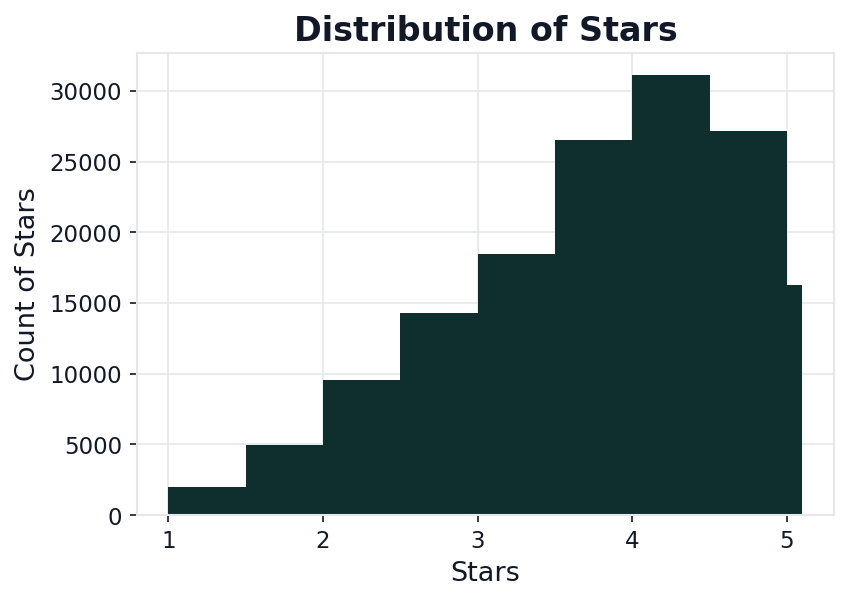

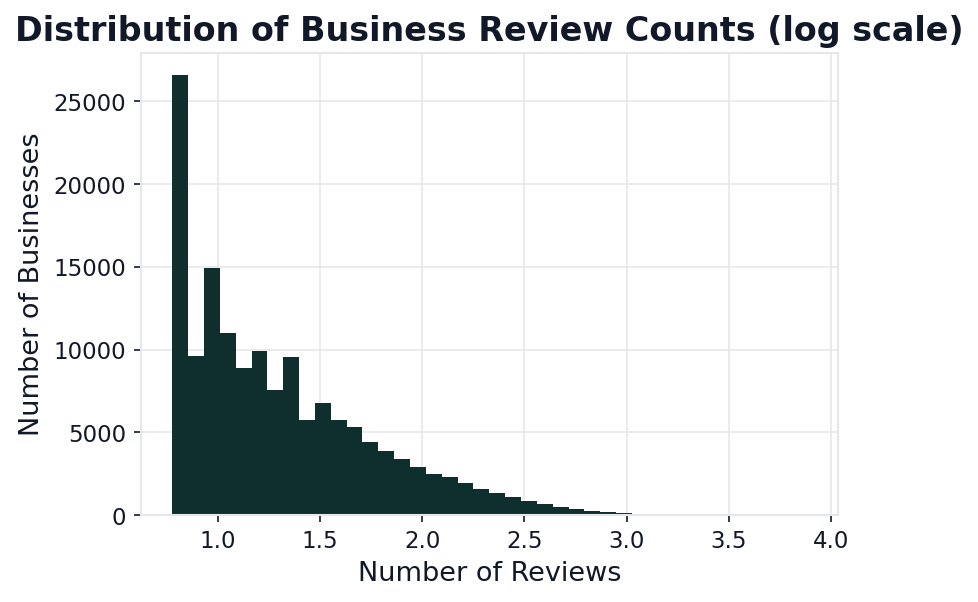

,coverage
accepts_credit_cards,0.796110
price,0.567225
takeout,0.384127
wifi,0.378553
good_for_kids,0.354828
delivery,0.348090
outdoor_seating,0.312080
reservations,0.299037
good_for_groups,0.293649
alcohol,0.287264


,count
primary_category,
Restaurants,15290
Food,6783
Shopping,5480
Beauty & Spas,4385
Home Services,3793
Automotive,3449
Health & Medical,3058
Local Services,2642
Nightlife,2291


In [ ]:
# Stars distribution
plt.figure()
df["stars"].plot(kind="hist", bins=[1,1.5,2,2.5,3,3.5,4,4.5,5,5.1])
plt.title("Distribution of Stars")
plt.xlabel("Stars")
plt.ylabel("Count of Stars")
plt.show()

# Review count (log scale)
plt.figure()
(df["review_count"].clip(lower=0) + 1).apply(np.log10).plot(kind="hist", bins=40)
plt.title("Distribution of Business Review Counts (log scale)")
plt.xlabel("Number of Reviews")
plt.ylabel("Number of Businesses")
plt.show()

# Attribute coverage
attrs = ["price","wifi","alcohol","attire","noise_level","weekly_hours",
         "accepts_credit_cards","takeout","delivery","good_for_kids",
         "outdoor_seating","reservations","good_for_groups","parking_any"]
coverage = (1 - df[attrs].isna().mean()).sort_values(ascending=False).to_frame("coverage")
display(coverage)

# Top categories
if "primary_category" in df.columns:
    top_cats = df["primary_category"].value_counts().head(15).to_frame("count")
    display(top_cats)


#### Observations:

**Distribution of Stars**
- Most businesses are rated between **3–5 stars**, peaking around **4 stars**.  
- Very few have **1–2 stars**, suggesting poorly rated businesses are rare or don’t survive long.  

**Distribution of Review Counts (Log Scale)**
- Distribution is **heavily right-skewed**.  
- Many businesses have **fewer than 10 reviews**.  
- A small number receive **hundreds or thousands** of reviews (long tail).  

**Attribute Coverage**
- **High coverage**: accepts_credit_cards (79.6%), price (56.7%)  
- **Moderate coverage**: takeout, wifi, good_for_kids, delivery (~30–40%)  
- **Low coverage**: weekly_hours (5%), parking_any (0%)  
- Core attributes are well represented, but hours/parking are unreliable.  

**Business Category Distribution**
- **Restaurants (15,290)** dominate the dataset.  
- Other large groups: Food (6,783), Shopping (5,480), Beauty & Spas (4,385).  
- Service sectors like Home Services, Automotive, and Health also have good representation.  
- Dataset is **food-heavy but diverse** across categories.  

### 3.3 Fixed Gaps – Data Reliability and Normalization  

This step addresses weaknesses in the dataset to make the analysis more reliable and fair. Several new columns are created to fix gaps and adjust for inconsistencies.  

- **Target reliability fixes**:  
  - Adds `high_rating_reliable` to only count ratings from businesses with at least 20 reviews.  
  - Creates a Bayesian-adjusted star rating (`stars_bayes`) that reduces bias from businesses with very few reviews.  

- **Attribute sparsity fixes**:  
  - Adds `_missing` flags for sparse attributes (e.g., WiFi, alcohol, attire, noise level, weekly hours) to indicate when information is absent.  

- **Category normalization**:  
  - Creates `stars_cat_z` to standardize ratings within each business category, so categories with different rating baselines can be compared fairly.  

- **Geographic normalization**:  
  - Creates `stars_city_z` to standardize ratings within each city, adjusting for local rating tendencies.  

- **Hours feature**:  
  - Converts weekly open hours into bins (e.g., `<40`, `40–80`, `80–120`, `>120`) and adds a missing indicator.  

In summary, this step strengthens the dataset by reducing bias from small sample sizes, filling gaps for sparse fields, and normalizing across categories and locations. These adjustments ensure that comparisons between businesses are fair and robust.  

In [ ]:
# --- 1. Target reliability fixes ---
# Minimum review threshold
df["high_rating_reliable"] = (
    (df["stars"] >= 4.5) & (df["review_count"] >= 20)
).astype(int)

# Bayesian-adjusted star rating
global_mean = df["stars"].mean()
alpha = 20  # prior strength, can tune between 10–50
df["stars_bayes"] = (
    (df["stars"] * df["review_count"] + global_mean * alpha)
    / (df["review_count"] + alpha)
)
df["high_rating_bayes"] = (df["stars_bayes"] >= 4.5).astype(int)

print("Target fixes done → added columns: high_rating_reliable, stars_bayes, high_rating_bayes")

# --- 2. Attribute sparsity fixes ---
sparse_cols = ["wifi", "alcohol", "attire", "noise_level", "weekly_hours"]

for col in sparse_cols:
    df[f"{col}_missing"] = df[col].isna().astype(int)

print("Sparsity fixes done → added *_missing flags")

# --- 3. Category skew fix (normalize ratings within category) ---
df["stars_cat_z"] = df.groupby("primary_category")["stars"].transform(
    lambda s: (s - s.mean())/s.std(ddof=0) if s.std(ddof=0) > 0 else 0
)

print("Category normalization done → added stars_cat_z")

# --- 4. Geo effects fix (normalize ratings within city) ---
df["stars_city_z"] = df.groupby("city")["stars"].transform(
    lambda s: (s - s.mean())/s.std(ddof=0) if s.std(ddof=0) > 0 else 0
)

print("Geo normalization done → added stars_city_z")

# --- 5. Hours feature fix (binning + missing flag already above) ---
df["hours_bin"] = pd.cut(
    df["weekly_hours"],
    [-0.1, 40, 80, 120, 168],
    labels=["≤40","40–80","80–120",">120"]
)
df["hours_missing"] = df["weekly_hours"].isna().astype(int)

print("Hours fixes done → added hours_bin, hours_missing")

# --- Quick summary of new columns ---
new_cols = [
    "high_rating_reliable", "stars_bayes", "high_rating_bayes",
    "stars_cat_z", "stars_city_z", "hours_bin", "hours_missing"
] + [c for c in df.columns if c.endswith("_missing")]

print("\nNew columns added:")
print(new_cols)


Target fixes done → added columns: high_rating_reliable, stars_bayes, high_rating_bayes
Sparsity fixes done → added *_missing flags
Category normalization done → added stars_cat_z
Geo normalization done → added stars_city_z
Hours fixes done → added hours_bin, hours_missing

New columns added:
['high_rating_reliable', 'stars_bayes', 'high_rating_bayes', 'stars_cat_z', 'stars_city_z', 'hours_bin', 'hours_missing', 'wifi_missing', 'alcohol_missing', 'attire_missing', 'noise_level_missing', 'weekly_hours_missing', 'hours_missing']


### 3.4 EDA with Gap Fixes – What the Charts Show

This step explores how ratings behave after applying the gap fixes and begins checking which attributes may relate to higher ratings.

- **Raw vs. Adjusted Ratings**  
  Compares the original star distribution to a Bayesian-adjusted version and a “reliable high rating” flag (only if ≥20 reviews). This shows how small-sample bias is reduced and how many businesses truly sit above 4.5 stars.

- **Reviews vs. Stars (log scale)**  
  Plots stars against review counts on a log scale to see whether highly rated businesses also tend to have more reviews and where volatility exists at low review counts.

- **Attribute Coverage vs. Stars**  
  For selected attributes (WiFi, alcohol, outdoor seating, reservations, good for kids), reports mean stars and sample sizes, and visualizes stars by attribute using boxplots. This highlights attributes that correlate with higher or lower ratings and whether effects are consistent or noisy.

- **Operating Hours vs. Stars**  
  Compares ratings across weekly-hours bins to see if longer or shorter opening hours relate to differences in star ratings.

- **Category-Normalized Ratings (z-scores)**  
  Looks at ratings standardized within each primary category to remove category-level bias. Also lists categories where “Free WiFi” associates with higher within-category z-scores, pointing to potentially meaningful attribute effects.

- **City-Normalized Ratings (z-scores)**  
  Looks at ratings standardized within each city to remove location bias. Also shows cities where alcohol service levels differentiate ratings, indicating local effects.

**Summary:** These analyses confirm that the gap fixes (reliability filtering, Bayesian smoothing, and z-score normalizations) stabilize the rating signal and surface candidate drivers (e.g., WiFi, alcohol, hours) that may influence high ratings, controlling for category and city differences.


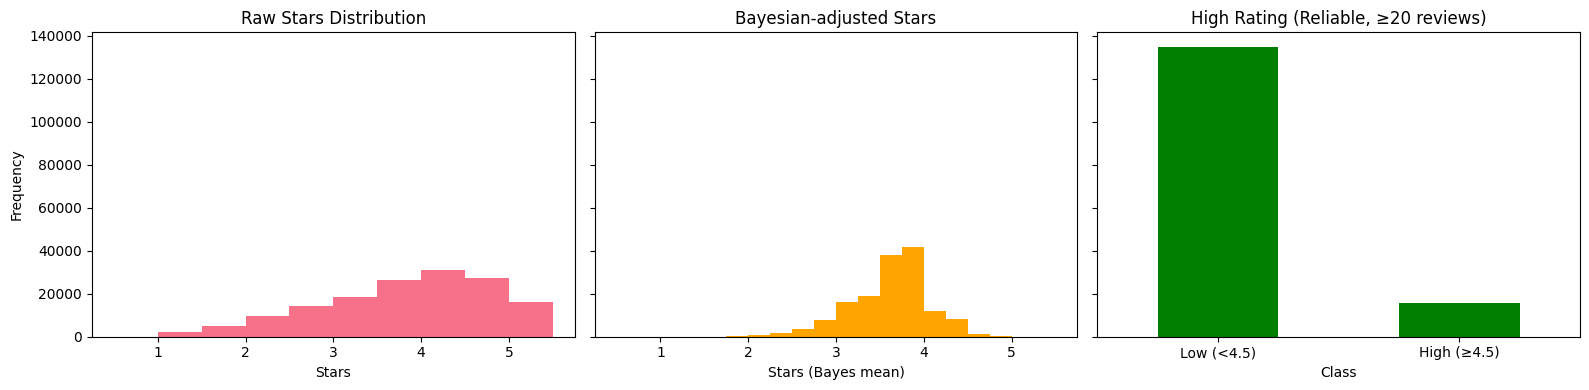

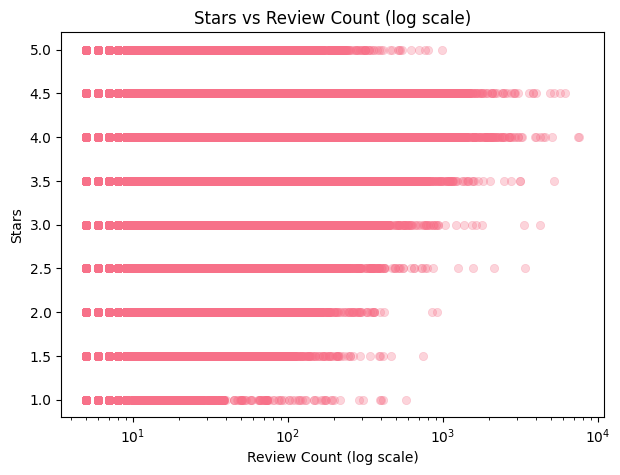


--- WIFI ---


,mean_stars,count
wifi,,
free,3.683123,34414
no,3.612043,21831
paid,3.575121,619
none,3.440000,50


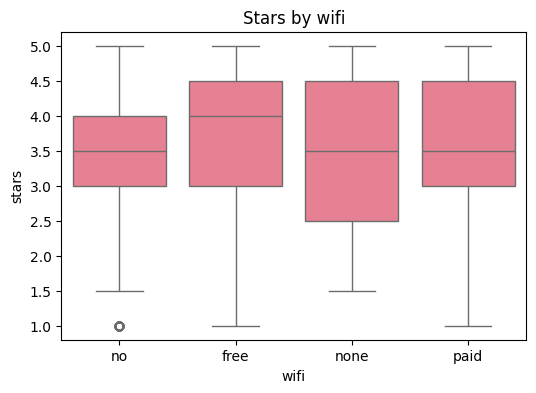


--- ALCOHOL ---


,mean_stars,count
alcohol,,
beer_wine,3.817251,6249
full_bar,3.544147,15992
none,3.492290,20948


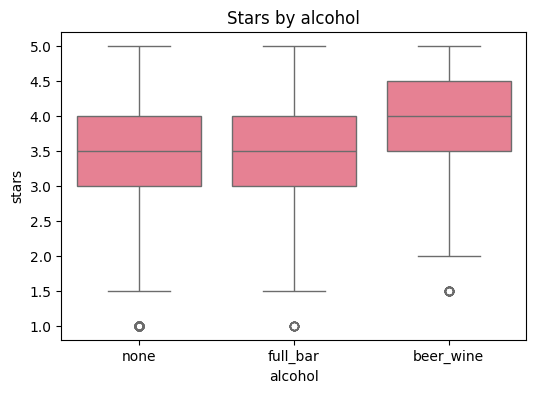


--- OUTDOOR_SEATING ---


,mean_stars,count
outdoor_seating,,
False,3.407123,24371
True,3.665196,22549


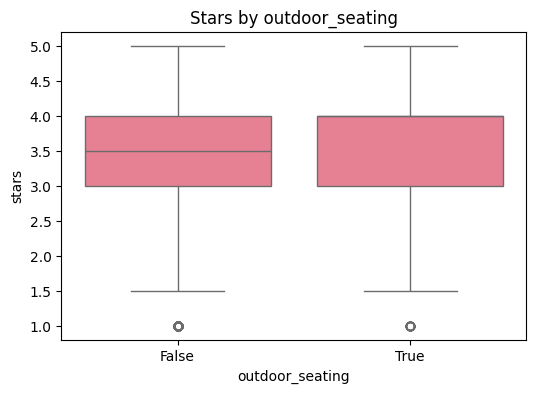


--- RESERVATIONS ---


,mean_stars,count
reservations,,
False,3.424265,30105
True,3.655615,14854


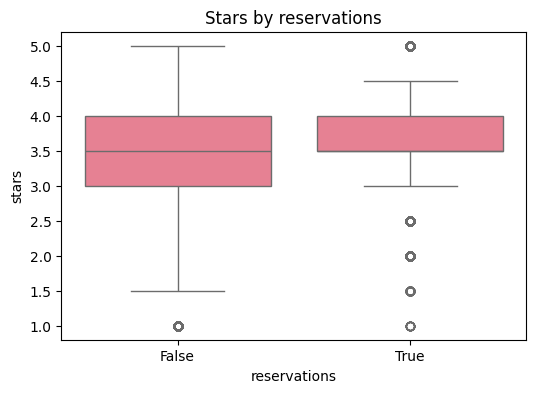


--- GOOD_FOR_KIDS ---


,mean_stars,count
good_for_kids,,
False,3.61327,9442
True,3.57498,43905


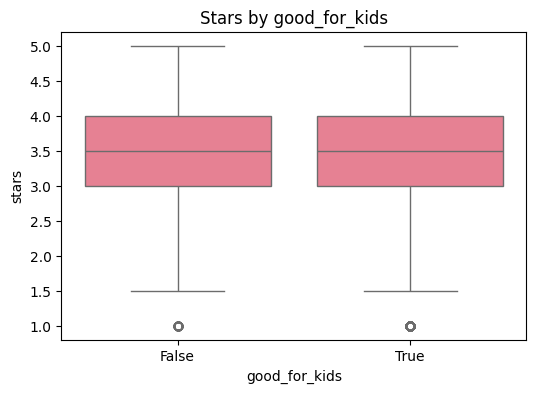

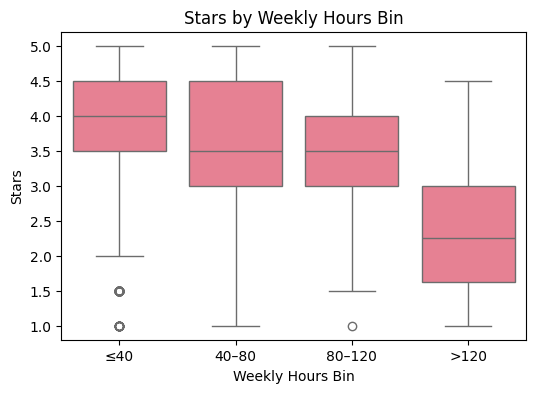

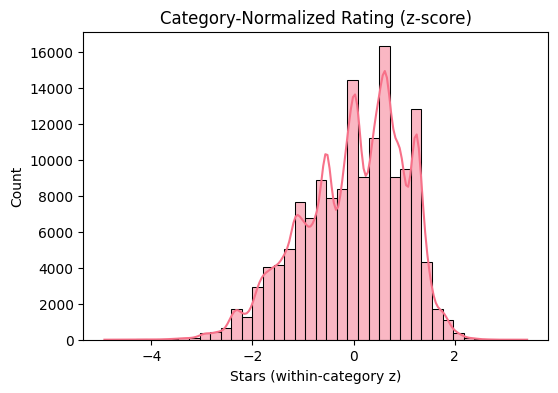


Top categories where 'Free WiFi' associates with higher z-scores:


wifi,free,no,none,paid
primary_category,,,,
Public Services & Government,0.673765,0.777456,0.636129,0.883451
Dry Cleaning & Laundry,0.653419,-0.131723,1.245971,0.291303
Beauty & Spas,0.465853,0.438342,-1.884215,0.440171
Hair Salons,0.460414,0.265801,0.693083,0.475627
Skin Care,0.437279,0.068530,1.130335,-0.058887
Real Estate,0.372378,0.093696,-0.707512,0.093696
Shopping,0.345909,0.338374,0.935835,0.935835
Local Services,0.315680,-0.277496,0.320104,-0.180430
Pizza,0.283683,0.009252,-0.935979,-0.107575


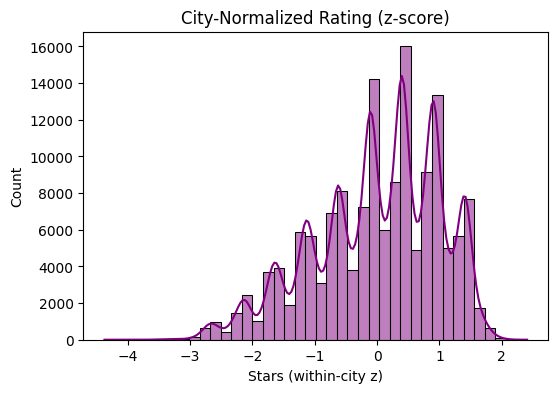


Cities where Alcohol attribute differentiates ratings:


alcohol,beer_wine,full_bar,none
city,,,
Abington,-0.050472,-0.652573,-0.076880
Affton,1.097155,-0.093183,0.015030
Alton,0.672536,0.117235,-0.038566
Ambler,-0.171796,-0.497143,-0.102783
Antioch,0.609628,0.206198,-0.283915
Apollo Beach,0.538607,-0.534744,-0.075600
Arabi,0.145494,0.432075,-0.255718
Ardmore,-0.022962,-0.306849,0.128460
Arnold,0.264186,0.014782,-0.172730


In [ ]:
# 1. Stars Distribution (Raw vs Bayesian vs Reliable)

fig, axes = plt.subplots(1, 3, figsize=(16, 4), sharey=True)

df["stars"].plot(kind="hist", bins=np.arange(0.5, 5.6, 0.5), ax=axes[0])
axes[0].set_title("Raw Stars Distribution")
axes[0].set_xlabel("Stars")

df["stars_bayes"].plot(kind="hist", bins=np.arange(0.5, 5.6, 0.25), ax=axes[1], color="orange")
axes[1].set_title("Bayesian-adjusted Stars")
axes[1].set_xlabel("Stars (Bayes mean)")

df["high_rating_reliable"].value_counts().plot(kind="bar", ax=axes[2], color="green")
axes[2].set_title("High Rating (Reliable, ≥20 reviews)")
axes[2].set_xlabel("Class")
axes[2].set_xticklabels(["Low (<4.5)", "High (≥4.5)"], rotation=0)

plt.tight_layout()
plt.show()


# 2. Review Count Effect
plt.figure(figsize=(7,5))
sns.scatterplot(x="review_count", y="stars", data=df,
                alpha=0.3, edgecolor=None)
plt.xscale("log")
plt.xlabel("Review Count (log scale)")
plt.ylabel("Stars")
plt.title("Stars vs Review Count (log scale)")
plt.show()


# 3. Attribute Coverage vs Stars
attrs_to_check = ["wifi", "alcohol", "outdoor_seating", "reservations", "good_for_kids"]

for col in attrs_to_check:
    if col in df.columns:
        avg = df.groupby(col)["stars"].mean().sort_values(ascending=False)
        count = df[col].value_counts()
        
        print(f"\n--- {col.upper()} ---")
        display(pd.DataFrame({"mean_stars": avg, "count": count}))

        plt.figure(figsize=(6,4))
        sns.boxplot(x=col, y="stars", data=df)
        plt.title(f"Stars by {col}")
        plt.show()


# 4. Hours vs Stars
plt.figure(figsize=(6,4))
sns.boxplot(x="hours_bin", y="stars", data=df)
plt.title("Stars by Weekly Hours Bin")
plt.xlabel("Weekly Hours Bin")
plt.ylabel("Stars")
plt.show()

# 5. Category-Normalized Ratings
plt.figure(figsize=(6,4))
sns.histplot(df["stars_cat_z"].dropna(), bins=40, kde=True)
plt.title("Category-Normalized Rating (z-score)")
plt.xlabel("Stars (within-category z)")
plt.show()

# Example: Effect of WiFi within categories
wifi_cat = (df.groupby(["primary_category", "wifi"])
              ["stars_cat_z"].mean()
              .unstack()
              .dropna()
              .sort_values("free", ascending=False)
              .head(10))
print("\nTop categories where 'Free WiFi' associates with higher z-scores:")
display(wifi_cat)

# 6. Geo-Normalized Ratings
plt.figure(figsize=(6,4))
sns.histplot(df["stars_city_z"].dropna(), bins=40, kde=True, color="purple")
plt.title("City-Normalized Rating (z-score)")
plt.xlabel("Stars (within-city z)")
plt.show()

# Example: Effect of Alcohol within cities
alc_city = (df.groupby(["city", "alcohol"])
              ["stars_city_z"].mean()
              .unstack()
              .dropna()
              .head(10))
print("\nCities where Alcohol attribute differentiates ratings:")
display(alc_city)


#### Observations on Business Ratings and Attributes

**Rating Distributions**
- **Raw stars** show a skew towards higher ratings (4–5 stars).
- **Bayesian-adjusted stars** reduce noise from businesses with few reviews, giving more reliable averages.
- **High rating distribution** indicates only a small subset of businesses achieve a reliable high score (≥4.5 with ≥20 reviews).

**Stars vs. Reviews**
- Review count distribution (log scale) shows that most businesses have few reviews, while a minority dominate with very high counts.
- Stars vs. review count plot suggests higher stability in ratings with more reviews.

**Attribute-Level Effects**
- **WiFi**: Businesses offering free WiFi tend to have higher mean ratings (~3.68) compared to no WiFi (~3.61).  
- **Alcohol**: Beer & wine offerings correlate with higher ratings (~3.82), while no alcohol businesses average lower (~3.49).  
- **Outdoor Seating**: Availability shows slightly higher ratings (~3.67 vs. 3.41).  
- **Reservations**: Businesses with reservations also tend to score higher (~3.66 vs. 3.42).  
- **Good for Kids**: Minimal difference between businesses flagged True (~3.57) vs. False (~3.61).  

**Hours of Operation**
- Businesses with **shorter hours (≤40 per week)** often have higher ratings (~4.0 median), while those open **>120 hours/week** tend to score lower, possibly reflecting service/quality tradeoffs.

**Normalized Ratings**
- **Category-normalized z-scores** adjust ratings relative to category peers, showing most businesses clustering around the mean (z=0).  
- **City-normalized z-scores** reveal rating differences between cities, helping control for geographic bias.

**Attribute Impact by Context**
- **WiFi effects** vary by business type: e.g., free WiFi strongly associated with higher z-scores in *Public Services, Beauty & Spas, Hair Salons*.  
- **Alcohol** shows city-level differentiation: e.g., in *Affton*, businesses with beer & wine trend higher, while in *Ambler*, alcohol is negatively associated.


### 3.5 Safety Checks – Ensure Gap-Fix Features Exist

This step makes the dataset robust by verifying that all engineered “gap-fix” features are present and recreating them if any are missing.

- **Backfill key features**: Recomputes the following columns on demand if they don’t already exist:
  - `high_rating_reliable`: 1 if stars ≥ 4.5 and reviews ≥ 20; else 0.
  - `stars_bayes`: Bayesian-smoothed star estimate using the global mean and a prior of 20 reviews.
  - `high_rating_bayes`: 1 if `stars_bayes` ≥ 4.5; else 0.
  - `stars_cat_z`: Within-category z-score of stars (controls for category-level bias).
  - `stars_city_z`: Within-city z-score of stars (controls for location bias).
  - `hours_bin`: Weekly open hours bucketed into ≤40, 40–80, 80–120, >120.

- **Missingness flags**: Adds `_missing` indicators for sparse fields (`wifi`, `alcohol`, `attire`, `noise_level`, `weekly_hours`) to retain information about absent values.

**Summary:** Guarantees all downstream analyses have the required engineered features and consistent missing-value indicators, even if earlier steps were skipped or partially run.

In [65]:
# Safety: confirms the gap-fix columns exist and adds sane fallbacks if needed
need = {
    "high_rating_reliable": lambda d: ((d["stars"] >= 4.5) & (d["review_count"] >= 20)).astype(int),
    "stars_bayes":          lambda d: (d["stars"]*d["review_count"] + d["stars"].mean()*20) / (d["review_count"]+20),
    "high_rating_bayes":    lambda d: (((d["stars"]*d["review_count"] + d["stars"].mean()*20) / (d["review_count"]+20)) >= 4.5).astype(int),
    "stars_cat_z":          lambda d: d.groupby("primary_category")["stars"].transform(lambda s: (s - s.mean())/s.std(ddof=0) if s.std(ddof=0)>0 else 0),
    "stars_city_z":         lambda d: d.groupby("city")["stars"].transform(lambda s: (s - s.mean())/s.std(ddof=0) if s.std(ddof=0)>0 else 0),
    "hours_bin":            lambda d: pd.cut(d["weekly_hours"], [-0.1,40,80,120,168], labels=["≤40","40–80","80–120",">120"])
}
for c, mk in need.items():
    if c not in df.columns:
        df[c] = mk(df)

# Missingness flags (idempotent: safe if they already exist)
for col in ["wifi","alcohol","attire","noise_level","weekly_hours"]:
    mcol = f"{col}_missing"
    if mcol not in df.columns:
        df[mcol] = df[col].isna().astype(int)


## 4. Q1 model + diagonstics

### 4.1 Model Setup – Target Definition and Feature Coverage  
This step defines the modeling target (high rating) and checks how complete the business attributes are.  

- **Target variable**: Creates `high_rating` (1 if stars ≥ 4.5, 0 otherwise). This is the classification outcome the model will try to predict.  
- **Base rate**: Calculates the share of businesses that meet the high-rating threshold (about 10%). This sets a benchmark for evaluating model performance.  
- **Feature audit**: Reviews the coverage of key business attributes (e.g., price, WiFi, alcohol, delivery, seating, noise level).  
- **Coverage summary**: Reports the proportion of businesses with non-missing values for each attribute, highlighting which features are reliable enough for modeling.  
- **Zero-coverage check**: Flags any fields that have no usable data at all.  


In [ ]:
# Target: 1 if stars > 4.5 else 0
df["high_rating"] = (df["stars"] > 4.5).astype("int8")

# Base rate
base_rate = df["high_rating"].mean()
print(f"Base rate (stars > 4.5): {base_rate:.3f}")

# Key attributes to audit
key_attrs = [
    "price","wifi","alcohol","attire","noise_level","weekly_hours",
    "accepts_credit_cards","takeout","delivery","good_for_kids",
    "outdoor_seating","reservations","good_for_groups","has_tv",
    "table_service","wheelchair_accessible","dogs_allowed",
    "bitcoin","happy_hour","drive_thru",
    "parking_any","parking_garage","parking_street","parking_validated","parking_lot","parking_valet",
]

present = [c for c in key_attrs if c in df.columns]
coverage = (1 - df[present].isna().mean()).sort_values(ascending=False).to_frame("coverage")
display(coverage)

zero_cov = coverage.index[coverage["coverage"] == 0.0].tolist()
print("Zero-coverage fields:", zero_cov if zero_cov else "None")


Base rate (stars > 4.5): 0.108


,coverage
accepts_credit_cards,0.796110
price,0.567225
takeout,0.384127
wifi,0.378553
good_for_kids,0.354828
delivery,0.348090
outdoor_seating,0.312080
has_tv,0.299742
reservations,0.299037
good_for_groups,0.293649


Zero-coverage fields: ['parking_any', 'parking_garage', 'parking_street', 'parking_validated', 'parking_lot', 'parking_valet']


#### Observations:

- **Base rate (stars > 4.5):** 0.108 (~11%)  
- **High coverage:** credit cards (80%), price (57%), takeout (38%), wifi (38%), kids (35%)  
- **Moderate coverage:** delivery, outdoor seating, TV, reservations, groups, alcohol (~25–35%)  
- **Low coverage:** attire, noise, wheelchair, table service, dogs, bitcoin, happy hour (~10–25%)  
- **Very low/zero:** weekly hours, drive-thru, parking features (<5%)  
- High-coverage attributes (credit cards, price, takeout, wifi) are most useful
- parking adds no value.


### 4.2 Parking Attribute Remediation – Extract, Enrich, and Recalculate Coverage

This step repairs the **parking** attributes, which are often buried inside nested or stringified JSON, and brings them back as clean columns.

- **Path fallback**: If the raw Yelp `business.json` path isn’t set, the script searches common folders to locate it.
- **Robust parsing**: Handles cases where `attributes` or `BusinessParking` are stored as:
  - proper dictionaries, or
  - strings that look like dictionaries (e.g., `"{'garage': True, ...}"`), converting them safely.
- **Truth-value cleanup**: Normalizes “true/false” variants (e.g., `"Yes"`, `"0"`) into consistent booleans.
- **Feature extraction**: Generates `parking_garage`, `parking_street`, `parking_validated`, `parking_lot`, `parking_valet`, and an overall `parking_any` flag.
- **Chunked enrichment**: Processes the raw JSON in 100k-row chunks and writes a lightweight `parking_enrichment.csv` to avoid memory issues.
- **Merge back**: Replaces any existing parking columns in the working dataset with the newly parsed, reliable versions.
- **Coverage check**: Recomputes and displays coverage for the parking fields to confirm the remediation improved completeness.

**Summary:** Converts messy, nested parking information into clear, reliable columns and verifies that these attributes now have usable coverage for downstream analysis and modeling.

In [ ]:
# Locate the raw Yelp business JSON if not already available
try:
    BUSINESS_JSON_PATH
    assert Path(BUSINESS_JSON_PATH).exists()
except Exception:
    # Fallback discovery
    PROJECT_ROOT = Path.cwd()
    CANDIDATE_DIRS = [
        PROJECT_ROOT,
        PROJECT_ROOT / "Yelp-JSON" / "Yelp JSON" / "yelp_dataset",
        PROJECT_ROOT / "Yelp JSON" / "yelp_dataset",
        PROJECT_ROOT / "yelp_dataset",
        PROJECT_ROOT / "data",
    ]
    fname = "yelp_academic_dataset_business.json"
    BUSINESS_JSON_PATH = None
    for base in CANDIDATE_DIRS:
        p = base / fname
        if p.exists():
            BUSINESS_JSON_PATH = p.resolve()
            break
        if base.exists():
            hits = list(base.rglob(fname))
            if hits:
                BUSINESS_JSON_PATH = hits[0].resolve()
                break
    assert BUSINESS_JSON_PATH is not None and Path(BUSINESS_JSON_PATH).exists(), \
        "Raw business JSON not found. Ensure the path is set."

def _parse_str_or_dict(obj):
    """Return a dict if obj is a dict or a stringified dict. Otherwise return None."""
    if isinstance(obj, dict):
        return obj
    if isinstance(obj, str) and obj.strip().startswith("{") and obj.strip().endswith("}"):
        try:
            return ast.literal_eval(obj)
        except Exception:
            return None
    return None

def _extract_parking_from_attributes(attr_obj):
    """
    Extract parking subkeys from attributes. Handle dicts and stringified dicts.
    Return dict with parking_* fields and parking_any.
    """
    out = {
        "parking_garage": None,
        "parking_street": None,
        "parking_validated": None,
        "parking_lot": None,
        "parking_valet": None,
        "parking_any": None,
    }
    if attr_obj is None:
        return out

    # If the entire attributes field is stringified, de-stringify
    attrs = _parse_str_or_dict(attr_obj)
    if not isinstance(attrs, dict):
        return out

    # BusinessParking may itself be a nested string or dict
    bp = attrs.get("BusinessParking", None)
    bp = _parse_str_or_dict(bp)
    if not isinstance(bp, dict):
        return out

    # Coerce common truthy/falsey strings
    def _cbool(x):
        if x in (True, False):
            return bool(x)
        if x is None:
            return None
        s = str(x).strip().lower()
        if s in {"true", "yes", "y", "1"}:
            return True
        if s in {"false", "no", "n", "0"}:
            return False
        return None

    for key in ["garage", "street", "validated", "lot", "valet"]:
        out[f"parking_{key}"] = _cbool(bp.get(key))

    any_true = any(v is True for v in [
        out["parking_garage"], out["parking_street"], out["parking_validated"],
        out["parking_lot"], out["parking_valet"]
    ])
    any_false = any(v is False for v in [
        out["parking_garage"], out["parking_street"], out["parking_validated"],
        out["parking_lot"], out["parking_valet"]
    ])
    out["parking_any"] = True if any_true else (False if (any_false and not any_true) else None)
    return out

# Build enrichment table from raw JSON in chunks
OUTPUTS_DIR = Path.cwd() / "outputs"
OUTPUTS_DIR.mkdir(exist_ok=True)
enrich_csv = OUTPUTS_DIR / "parking_enrichment.csv"
if enrich_csv.exists():
    enrich_csv.unlink()

written = 0
for raw_chunk in pd.read_json(BUSINESS_JSON_PATH, lines=True, chunksize=100_000):
    sub = raw_chunk[["business_id", "attributes"]].copy()
    part = sub["attributes"].apply(_extract_parking_from_attributes).apply(pd.Series)
    part.insert(0, "business_id", sub["business_id"].values)

    mode = "w" if written == 0 else "a"
    header = (written == 0)
    part.to_csv(enrich_csv, index=False, mode=mode, header=header)

    written += len(part)
    del raw_chunk, sub, part
    gc.collect()

# Merge enrichment back into the current df
enrich = pd.read_csv(enrich_csv)
merge_cols = ["parking_garage","parking_street","parking_validated","parking_lot","parking_valet","parking_any"]
df = df.drop(columns=[c for c in merge_cols if c in df.columns], errors="ignore").merge(
    enrich[["business_id"] + merge_cols], on="business_id", how="left"
)

# Recompute coverage for key attributes
key_attrs = [
    "price","wifi","alcohol","attire","noise_level","weekly_hours",
    "accepts_credit_cards","takeout","delivery","good_for_kids",
    "outdoor_seating","reservations","good_for_groups","has_tv",
    "table_service","wheelchair_accessible","dogs_allowed",
    "bitcoin","happy_hour","drive_thru",
    "parking_any","parking_garage","parking_street","parking_validated","parking_lot","parking_valet",
]
present = [c for c in key_attrs if c in df.columns]
coverage_after = (1 - df[present].isna().mean()).sort_values(ascending=False).to_frame("coverage")

print("Coverage after parking remediation:")
display(coverage_after.loc[[c for c in coverage_after.index if c.startswith("parking_")]])


Coverage after parking remediation:


,coverage
parking_any,0.590678
parking_valet,0.590604
parking_garage,0.577900
parking_validated,0.576364
parking_lot,0.575446
parking_street,0.568515


#### Observations: 
- **Base rate (stars > 4.5):** 0.108 (~11%)  
- **High coverage:** credit cards (80%), price (57%), takeout/wifi (~38%), kids (35%)  
- **Moderate coverage:** delivery, seating, TV, reservations, groups, alcohol (~25–35%)  
- **Low coverage:** attire, noise, wheelchair, table service, dogs, bitcoin, happy hour (~10–25%)  
- **Very low/zero:** weekly hours, drive-thru, parking (<5%)  
- High-coverage attributes (credit cards, price, takeout, wifi) are most useful; parking features add no value.  

### 4.3 Attribute Lifts and Simple Correlations

This step screens features to see which ones are most associated with very high ratings (stars ≥ 4.5). It reports simple, transparent metrics that are easy to interpret before building a model.

- **Baseline**  
  Computes the overall share of high-rated businesses. This is the reference point for all lifts.

- **Binary attributes (yes/no features)**  
  For each attribute (e.g., delivery, outdoor seating, parking types), calculates:
  - the high-rating rate when the attribute is **True** vs **False** (ignoring missing),
  - **lift vs. baseline** when True, and
  - the **delta (True − False)** to show direction and magnitude.  
  Results are filtered to attributes with enough data (≥100 True and ≥100 False) and ranked by the strongest positive/negative deltas.

- **Categorical attributes (multi-level features)**  
  For selected fields (`wifi`, `alcohol`, `attire`), computes one-vs-rest **lift** for each level (e.g., “free”, “paid”, “none”), keeping only levels with sufficient sample size (≥200). Ranks levels by lift.

- **Numeric features**  
  For continuous fields (`review_count`, `price`, `weekly_hours`), calculates **point-biserial correlations** with the high-rating target. Also evaluates `log1p(review_count)` to reduce skew from very large counts.

In [ ]:
assert "high_rating" in df.columns, "Define target first (Step 1)."

base_rate = df["high_rating"].mean()
print(f"Base rate (stars > 4.5): {base_rate:.3f}")

# 1. Binary attributes: target-rate lift 
binary_cols = [
    "accepts_credit_cards","takeout","delivery","good_for_kids","outdoor_seating",
    "reservations","good_for_groups","has_tv","wheelchair_accessible","table_service",
    "dogs_allowed","bitcoin","happy_hour","drive_thru",
    "parking_any","parking_garage","parking_street","parking_validated","parking_lot","parking_valet",
]
binary_cols = [c for c in binary_cols if c in df.columns]

rows = []
for c in binary_cols:
    s = df[c]
    # treat only True/False observations; ignore missing
    m_true = s == True
    m_false = s == False
    n1 = int(m_true.sum())
    n0 = int(m_false.sum())
    rate1 = df.loc[m_true, "high_rating"].mean() if n1 > 0 else np.nan
    rate0 = df.loc[m_false, "high_rating"].mean() if n0 > 0 else np.nan
    lift_vs_base = (rate1 - base_rate) if pd.notna(rate1) else np.nan
    delta_1_minus_0 = (rate1 - rate0) if pd.notna(rate1) and pd.notna(rate0) else np.nan
    rows.append({
        "feature": c,
        "n_true": n1,
        "n_false": n0,
        "pos_rate_when_true": rate1,
        "pos_rate_when_false": rate0,
        "lift_vs_base_when_true": lift_vs_base,
        "delta_true_minus_false": delta_1_minus_0,
    })

binary_lift = pd.DataFrame(rows)
# Filter very small groups to reduce noise
binary_lift = binary_lift[(binary_lift["n_true"] >= 100) & (binary_lift["n_false"] >= 100)]
binary_lift = binary_lift.sort_values("delta_true_minus_false", ascending=False).reset_index(drop=True)

print("\nBinary attributes — strongest positive deltas (top 12):")
display(binary_lift.head(12))

print("\nBinary attributes — strongest negative deltas (top 12):")
display(binary_lift.tail(12).sort_values("delta_true_minus_false"))

# 2. Categorical attributes: one-vs-rest lift by level
def cat_lift_table(col: str, min_count: int = 200) -> pd.DataFrame:
    s = df[col].fillna("Unknown")
    g = df.groupby(s)["high_rating"].agg(["mean", "count"]).rename(columns={"mean": "pos_rate", "count": "n"})
    g = g[g["n"] >= min_count].copy()
    g["lift_vs_base"] = g["pos_rate"] - base_rate
    g = g.sort_values("lift_vs_base", ascending=False).reset_index().rename(columns={col: "level"})
    g.insert(0, "feature", col)
    return g

cat_cols = [c for c in ["wifi","alcohol","attire"] if c in df.columns]

cat_tables = []
for c in cat_cols:
    tbl = cat_lift_table(c, min_count=200)
    cat_tables.append(tbl)

for c, tbl in zip(cat_cols, cat_tables):
    print(f"\nCategorical attribute: {c} — levels by lift (top 10):")
    display(tbl.head(10))

# 3. Numeric features: point-biserial correlations and simple summaries 
num_cols = [c for c in ["review_count", "price", "weekly_hours"] if c in df.columns]
# add log1p(review_count) for robustness
if "review_count" in df.columns:
    df["_review_count_log1p_tmp"] = np.log1p(df["review_count"].clip(lower=0))
    num_cols.append("_review_count_log1p_tmp")

rows_n = []
y = df["high_rating"].astype(float)
for c in num_cols:
    s = df[c]
    m = s.notna() & y.notna()
    if m.sum() < 100:
        continue
    x = s[m].astype(float)
    yt = y[m]
    corr = np.corrcoef(x, yt)[0, 1]
    rows_n.append({"feature": c, "n": int(m.sum()), "point_biserial_corr": corr})

num_corr = pd.DataFrame(rows_n).sort_values("point_biserial_corr", ascending=False)
print("\nNumeric features — point-biserial correlations:")
display(num_corr)

# clean up temporary column
if "_review_count_log1p_tmp" in df.columns:
    df.drop(columns=["_review_count_log1p_tmp"], inplace=True)


Base rate (stars > 4.5): 0.108

Binary attributes — strongest positive deltas (top 12):


,feature,n_true,n_false,pos_rate_when_true,pos_rate_when_false,lift_vs_base_when_true,delta_true_minus_false
0,bitcoin,470,16957,0.270213,0.158872,0.161750,0.111340
1,dogs_allowed,5991,12267,0.129528,0.062525,0.021064,0.067002
2,parking_street,23026,62448,0.095414,0.068153,-0.013049,0.027261
3,outdoor_seating,22549,24371,0.030733,0.020968,-0.077730,0.009766
4,parking_any,62754,26052,0.073493,0.075119,-0.034970,-0.001626
5,parking_garage,4140,82745,0.070773,0.074893,-0.037690,-0.004120
6,reservations,14854,30105,0.016696,0.021292,-0.091767,-0.004596
7,parking_validated,839,85815,0.069130,0.074754,-0.039333,-0.005624
8,delivery,32146,20188,0.031979,0.037696,-0.076484,-0.005717
9,good_for_groups,38148,6001,0.013579,0.021330,-0.094884,-0.007751



Binary attributes — strongest negative deltas (top 12):


,feature,n_true,n_false,pos_rate_when_true,pos_rate_when_false,lift_vs_base_when_true,delta_true_minus_false
19,wheelchair_accessible,25993,2933,0.124187,0.251620,0.015724,-0.127432
18,accepts_credit_cards,113667,6025,0.100179,0.197178,-0.008285,-0.097000
17,parking_valet,1458,87337,0.024691,0.074802,-0.083772,-0.050111
16,happy_hour,9721,5448,0.016459,0.051946,-0.092004,-0.035486
15,takeout,52943,4809,0.033357,0.064462,-0.075107,-0.031106
14,table_service,12674,7293,0.022960,0.050048,-0.085503,-0.027088
13,has_tv,34154,10911,0.016777,0.040510,-0.091686,-0.023733
12,drive_thru,4374,2631,0.006173,0.024705,-0.102290,-0.018533
11,parking_lot,44247,42269,0.069248,0.080745,-0.039216,-0.011497
10,good_for_kids,43905,9442,0.045462,0.056768,-0.063001,-0.011306



Categorical attribute: wifi — levels by lift (top 10):


,feature,level,pos_rate,n,lift_vs_base
0,wifi,Unknown,0.130544,93432,0.022081
1,wifi,paid,0.127625,619,0.019162
2,wifi,free,0.077904,34414,-0.030559
3,wifi,no,0.061564,21831,-0.046899



Categorical attribute: alcohol — levels by lift (top 10):


,feature,level,pos_rate,n,lift_vs_base
0,alcohol,Unknown,0.142996,107157,0.034533
1,alcohol,none,0.030934,20948,-0.077529
2,alcohol,beer_wine,0.029285,6249,-0.079178
3,alcohol,full_bar,0.009567,15992,-0.098896



Categorical attribute: attire — levels by lift (top 10):


,feature,level,pos_rate,n,lift_vs_base
0,attire,Unknown,0.142793,111091,0.034330
1,attire,casual,0.011449,38344,-0.097014
2,attire,dressy,0.006227,803,-0.102236



Numeric features — point-biserial correlations:


,feature,n,point_biserial_corr
1,price,85280,0.037092
0,review_count,150346,-0.081797
2,weekly_hours,7653,-0.093974
3,_review_count_log1p_tmp,150346,-0.181357


#### Observations: 
- **Base rate (stars > 4.5):** 0.108 (~11%)

**Binary Attributes**
- **Strong positive lifts:**  
  - Bitcoin (+11%), Dogs allowed (+7%), Street parking (+3%), Outdoor seating (+1%)  
- **Strong negative lifts:**  
  - Wheelchair accessible (–13%), Credit cards (–10%), Valet (–5%), Happy hour (–4%), Takeout (–3%)  

**Categorical Attributes**
- **Wifi:** Unknown/paid slightly positive; free/no negative  
- **Alcohol:** Unknown (+3%), none/beer-wine/full bar all negative  
- **Attire:** Unknown (+3%); casual/dressy negative  

**Numeric Features**
- **Weak correlations:**  
  - Price (+0.04), Review count (–0.08), Weekly hours (–0.09), Log review count (–0.18)

**Overall**
- Quirky/rare features (bitcoin, dogs, street parking) show strongest positive deltas.  
- Common amenities (credit cards, takeout, kids, TV) surprisingly reduce odds of >4.5 stars.  
- “Unknown” levels in categorical features often signal higher ratings.  
- Numeric variables show only weak predictive power.  

### 4.4 Segment Baseline – High Rating Rates and Attribute Coverage by Category  

This step establishes baseline metrics for the largest business categories, helping compare how rating patterns and data completeness differ by segment.  

- **Segmentation**  
  Selects the top 8 most common primary categories (e.g., restaurants, cafes, bars). All other categories are grouped under “Other.”  

- **Base rate by segment**  
  Calculates the share of businesses with high ratings (≥4.5 stars) within each segment. This shows which categories naturally trend toward higher or lower ratings.  

- **Attribute coverage by segment**  
  For each segment, reports the proportion of businesses with usable data for key attributes (e.g., price, WiFi, alcohol, delivery, seating, parking). This highlights where attributes are well-documented versus sparse.  

- **Output**  
  Produces a summary table (`q1_segment_baseline_coverage.csv`) with segment size, high-rating base rates, and attribute coverage percentages.  

In [ ]:
# Segment baseline: base rates and coverage by top primary categories
assert "high_rating" in df.columns, "Define target first."

# Choose the top N primary categories by count (add 'Other' as a catch-all)
TOP_N = 8
seg_levels = df["primary_category"].value_counts().head(TOP_N).index.tolist()
df_seg = df.copy()
df_seg["segment"] = np.where(df_seg["primary_category"].isin(seg_levels),
                             df_seg["primary_category"], "Other")

# Attributes we can audit across segments (broadly applicable)
attrs = [
    "price","wifi","alcohol","attire","noise_level","weekly_hours",
    "accepts_credit_cards","takeout","delivery","good_for_kids",
    "outdoor_seating","reservations","good_for_groups","has_tv",
    "wheelchair_accessible","table_service","dogs_allowed",
    "bitcoin","happy_hour","drive_thru",
    "parking_any","parking_garage","parking_street","parking_validated","parking_lot","parking_valet"
]
attrs = [c for c in attrs if c in df_seg.columns]  # keep only present

# Build segment baseline table
rows = []
for seg, g in df_seg.groupby("segment", dropna=False):
    row = {
        "segment": seg,
        "n": len(g),
        "base_rate_high": g["high_rating"].mean(),  # stars > 4.5
    }
    # Coverage per attribute
    for a in attrs:
        row[f"cov__{a}"] = (1 - g[a].isna().mean())
    rows.append(row)

seg_table = pd.DataFrame(rows).sort_values("n", ascending=False).reset_index(drop=True)

# Save for reference
out_path = Path.cwd() / "outputs" / "q1_segment_baseline_coverage.csv"
seg_table.to_csv(out_path, index=False)

display(seg_table.head(10))


,segment,n,base_rate_high,cov__price,cov__wifi,cov__alcohol,cov__attire,cov__noise_level,cov__weekly_hours,cov__accepts_credit_cards,...,cov__dogs_allowed,cov__bitcoin,cov__happy_hour,cov__drive_thru,cov__parking_any,cov__parking_garage,cov__parking_street,cov__parking_validated,cov__parking_lot,cov__parking_valet
0,Other,105466,0.112833,0.541502,0.374509,0.278905,0.243396,0.243652,0.051732,0.775567,...,0.126922,0.117763,0.106148,0.043350,0.571957,0.559602,0.551258,0.558161,0.557706,0.571919
1,Restaurants,15290,0.026422,0.853107,0.691498,0.758404,0.768018,0.664552,0.051275,0.859712,...,0.181360,0.097711,0.204840,0.104774,0.844931,0.818901,0.799215,0.816678,0.812884,0.844931
2,Food,6783,0.073419,0.850803,0.519387,0.304143,0.262126,0.284682,0.032729,0.868200,...,0.169836,0.110423,0.107032,0.086687,0.877783,0.849182,0.820139,0.844317,0.838862,0.877340
3,Shopping,5480,0.114051,0.798905,0.060219,0.013504,0.006387,0.010766,0.029380,0.875547,...,0.124270,0.115146,0.014416,0.025730,0.791971,0.788686,0.784307,0.787774,0.788139,0.791971
4,Beauty & Spas,4385,0.152794,0.808210,0.271152,0.001140,0.000912,0.018016,0.074116,0.885291,...,0.012543,0.120639,0.004333,0.010490,0.829418,0.828278,0.827138,0.826910,0.827138,0.828734
5,Home Services,3793,0.173741,0.058529,0.020828,0.001846,0.000527,0.000527,0.041656,0.824413,...,0.016873,0.237279,0.001318,0.000791,0.060374,0.060374,0.060111,0.060374,0.060374,0.060374
6,Automotive,3449,0.142940,0.039722,0.210786,0.002899,0.003769,0.002609,0.057408,0.766309,...,0.004059,0.014207,0.001160,0.005509,0.046680,0.046680,0.046100,0.046390,0.046390,0.046680
7,Health & Medical,3058,0.182472,0.147482,0.220405,0.002289,0.001308,0.002943,0.073250,0.704382,...,0.013407,0.043165,0.001635,0.010464,0.182472,0.181818,0.181491,0.181818,0.182145,0.182145
8,Local Services,2642,0.189251,0.235806,0.121499,0.004542,0.002271,0.002650,0.047313,0.854656,...,0.034822,0.197956,0.001514,0.000757,0.259652,0.259273,0.259273,0.259273,0.259652,0.259652


#### Observations:
The overall base rate looks higher (~11%) when all businesses are pooled together.  
However, when isolating **Restaurants**, the base rate **drops to just 2.6%** — because restaurants form the largest identifiable segment and are rated much lower on average compared to other categories (e.g., Health, Local Services).  

The drop happens because restaurants dominate the dataset, and they have far fewer highly rated businesses.

### 4.5 Macro-Segment Mapping – Group Businesses into Broad Segments

This step groups Yelp businesses into a small set of intuitive “macro-segments” (e.g., Food & Beverage, Beauty & Wellness) based on their raw category text, then merges those segments into the working dataset and summarizes them.

- **Path fallback**  
  If the raw `business.json` path is missing, the code searches common folders to locate it.

- **Segment rules**  
  Defines 10+ macro-segments with keyword lists (lowercase substrings). Priority is top-to-bottom: the first matching segment wins. Businesses with no match are assigned to **Other**.

- **Streaming map build**  
  Reads the raw JSON in 100k-row chunks for memory safety, maps each business’s categories to a `macro_segment`, and writes a compact lookup table to `outputs/q1_macro_segments.csv`.

- **Merge & fill**  
  Adds the `macro_segment` back to the working `df` via `business_id` and fills missing values with **Other**.

- **Summary**  
  Produces a table by macro-segment showing:
  - `n`: number of businesses, and  
  - `base_rate_high`: share with high ratings (stars ≥ 4.5).  

In [18]:
# Q1 — Macro-segment mapping from raw Yelp categories, merge into df, and summarize

import re, gc, ast
from pathlib import Path
import pandas as pd
import numpy as np

# Ensure df is loaded and target exists
try:
    assert "business_id" in df.columns and "high_rating" in df.columns
except AssertionError:
    raise RuntimeError("Load cleaned business CSV and define `high_rating` before running this cell.")

# Locate raw business JSON if not already set
try:
    BUSINESS_JSON_PATH
    assert Path(BUSINESS_JSON_PATH).exists()
except Exception:
    PROJECT_ROOT = Path.cwd()
    CANDIDATE_DIRS = [
        PROJECT_ROOT,
        PROJECT_ROOT / "Yelp-JSON" / "Yelp JSON" / "yelp_dataset",
        PROJECT_ROOT / "Yelp JSON" / "yelp_dataset",
        PROJECT_ROOT / "yelp_dataset",
        PROJECT_ROOT / "data",
    ]
    fname = "yelp_academic_dataset_business.json"
    BUSINESS_JSON_PATH = None
    for base in CANDIDATE_DIRS:
        p = base / fname
        if p.exists():
            BUSINESS_JSON_PATH = p.resolve()
            break
        if base.exists():
            hits = list(base.rglob(fname))
            if hits:
                BUSINESS_JSON_PATH = hits[0].resolve()
                break
    assert BUSINESS_JSON_PATH is not None and Path(BUSINESS_JSON_PATH).exists(), \
        "Raw business JSON not found."

# ----- Define macro-segments with keyword lists (lowercase substrings) -----
SEGMENTS = [
    ("Food & Beverage", [
        "restaurant","food","nightlife","bar","pub","brewpub","beer",
        "wine","cocktail","coffee","tea","cafe","bakery","dessert",
        "ice cream","frozen yogurt","pizza","sandwich","burger","bbq",
        "steak","seafood","sushi","ramen","noodle",
        "chinese","japanese","italian","mexican","thai","indian","korean",
        "mediterranean","middle eastern","greek","vietnamese","juice","smoothie"
    ]),
    ("Beauty & Wellness", [
        "beauty & spas","spa","massage","hair","barbers","nail","laser hair removal",
        "skin care","day spas","waxing","cosmetics","eyelash service","medical spas"
    ]),
    ("Health & Medical", [
        "health & medical","dentist","dental","doctor","optometrist","ophthalmologist",
        "chiropractor","urgent care","hospital","clinic","physician","orthodontist","dermatologist",
        "physical therapy","pharmacy","nutritionist"
    ]),
    ("Home & Local Services", [
        "home services","contractor","plumbing","electrician","hvac","landscaping",
        "local services","keys","locksmith","laundry services","handyman","cleaning","appliances repair"
    ]),
    ("Shopping & Retail", [
        "shopping","retail","department store","fashion","books","toys","electronics",
        "furniture","home decor","jewelry","shoe stores","gift shops","pet store"
    ]),
    ("Automotive", [
        "automotive","auto repair","car dealers","oil change","car wash","smog check",
        "tires","body shops","windshield"
    ]),
    ("Professional Services", [
        "professional services","lawyers","legal services","real estate","mortgage brokers",
        "insurance","financial services","tax services","accountants","it services","marketing"
    ]),
    ("Entertainment & Events", [
        "arts & entertainment","event planning & services","venues & event spaces",
        "performing arts","music venues","party & event planning","photographers","caterers"
    ]),
    ("Travel & Hospitality", [
        "hotels","travel services","vacation rentals","resorts","hostels","transportation","airport shuttles"
    ]),
    ("Education & Public Services", [
        "education","tutoring","driving schools","religious organizations","public services & government",
        "libraries","community service/non-profit","university","college","school"
    ]),
    ("Pets", [
        "pet services","veterinarians","pet groomers","dog walkers","pet boarding"
    ]),
]

# Priority order is top-to-bottom in SEGMENTS
def map_macro_segment(categories_str: str) -> str:
    if not isinstance(categories_str, str) or not categories_str.strip():
        return "Other"
    s = categories_str.lower()
    for seg, keywords in SEGMENTS:
        for kw in keywords:
            if kw in s:
                return seg
    return "Other"

# ----- Build mapping by streaming raw JSON (business_id -> macro_segment) -----
OUTPUTS_DIR = Path.cwd() / "outputs"
OUTPUTS_DIR.mkdir(exist_ok=True)
map_csv = OUTPUTS_DIR / "q1_macro_segments.csv"

# Recompute fresh each run to be deterministic
if map_csv.exists():
    map_csv.unlink()

written = 0
for chunk in pd.read_json(BUSINESS_JSON_PATH, lines=True, chunksize=100_000):
    part = chunk[["business_id","categories"]].copy()
    part["macro_segment"] = part["categories"].apply(map_macro_segment)
    mode = "w" if written == 0 else "a"; header = (written == 0)
    part[["business_id","macro_segment"]].to_csv(map_csv, index=False, mode=mode, header=header)
    written += len(part)
    del chunk, part
    gc.collect()

# ----- Merge into working df and summarize -----
seg_map = pd.read_csv(map_csv)
df = df.drop(columns=["macro_segment"], errors="ignore").merge(seg_map, on="business_id", how="left")
df["macro_segment"] = df["macro_segment"].fillna("Other")

seg_summary = (
    df.groupby("macro_segment", dropna=False)
      .agg(n=("business_id","size"), base_rate_high=("high_rating","mean"))
      .sort_values("n", ascending=False).reset_index()
)

print("Macro-segment mapping complete. Saved: outputs/q1_macro_segments.csv")
display(seg_summary)


Macro-segment mapping complete. Saved: outputs/q1_macro_segments.csv


,macro_segment,n,base_rate_high
0,Food & Beverage,71515,0.052255
1,Home & Local Services,21119,0.172215
2,Beauty & Wellness,13702,0.166326
3,Shopping & Retail,12878,0.120826
4,Automotive,8698,0.141067
5,Health & Medical,8627,0.156022
6,Entertainment & Events,4281,0.171689
7,Other,3647,0.198794
8,Pets,2227,0.179614
9,Professional Services,1558,0.192555


#### Observations: 

**Key Insight:**  
- **Food & Beverage dominates** (71k businesses) but has the **lowest base rate (~5%)**, pulling the overall average down.  
- Service-oriented segments (Home, Wellness, Medical, Education) show much **higher base rates (~15–23%)**, meaning they’re more likely to have highly rated businesses.  

### 4.6 Segment Analysis – Food & Beverage (Univariate Screening)

This step zooms into the **Food & Beverage** macro-segment to identify which business attributes are most strongly linked to very high ratings (≥4.5 stars). Each attribute is evaluated separately to measure its predictive strength.

- **Segment filter**  
  Creates a subset of the dataset containing only Food & Beverage businesses. The base rate of high ratings in this segment is calculated as a benchmark.

- **Binary attributes (yes/no features)**  
  For each attribute (e.g., delivery, outdoor seating, parking options), calculates:
  - Positive rate when attribute = True vs. False.  
  - Lift over the base rate (percentage point difference).  
  - Delta between True and False groups.  
  - Association metrics: Phi coefficient and odds ratios with confidence intervals.  
  Results are ranked to show the strongest positive and negative contributors.

- **Categorical attributes (multi-level features)**  
  For fields such as `wifi`, `alcohol`, and `attire`, computes:
  - High-rating rate per level (e.g., “free WiFi”, “full bar”).  
  - Lift over the base rate and delta versus all other businesses.  
  - Association metrics (phi, odds ratios).  
  Only levels with sufficient support (≥1,000 businesses) are reported.

- **Numeric / ordinal attributes**  
  For variables like `review_count`, `price`, and `weekly_hours`, computes:
  - Point-biserial correlations (linear relationship with high rating).  
  - Spearman correlations (monotonic trend).  
  - Includes a log-transformed `review_count` to account for skew from highly popular businesses.

- **Outputs**  
  Saves screening tables for binary, categorical, and numeric attributes in `outputs/food_&_beverage/`. Prints top contributors and summaries directly for review.

**Summary:** Provides a rigorous, segment-specific scan of which Food & Beverage attributes are most indicative of higher ratings. These results highlight candidate drivers that can be prioritized in modeling or strategy discussions.

In [ ]:
# Segment subset
SEG = "Food & Beverage"
df_s = df[df["macro_segment"] == SEG].copy()
assert len(df_s) > 0, f"No rows for segment: {SEG}"
base = df_s["high_rating"].mean()

OUT_FB = Path.cwd() / "outputs"/"food_&_beverage"
OUT_FB.mkdir(exist_ok=True)

# ---------- Helpers ----------
def _phi_2x2(a,b,c,d):
    num = (a*d) - (b*c)
    den = np.sqrt((a+b)*(c+d)*(a+c)*(b+d))
    return float(num/den) if den else np.nan

def _odds_ratio_ci(a,b,c,d, alpha=0.05):
    # continuity correction for zeros
    a,b,c,d = [x if x>0 else 0.5 for x in (a,b,c,d)]
    or_ = (a*d)/(b*c)
    se  = np.sqrt(1/a + 1/b + 1/c + 1/d)
    z   = 1.96  # 95% CI
    lo, hi = np.exp(np.log(or_) - z*se), np.exp(np.log(or_) + z*se)
    return float(or_), float(lo), float(hi)

# ---------- 1. Binary attributes ----------
BIN_COLS = [
    "accepts_credit_cards","takeOUT_FB","delivery","good_for_kids","OUT_FBdoor_seating",
    "reservations","good_for_groups","has_tv","wheelchair_accessible","table_service",
    "dogs_allowed","bitcoin","happy_hour","drive_thru",
    "parking_any","parking_garage","parking_street","parking_validated","parking_lot","parking_valet",
]
BIN_COLS = [c for c in BIN_COLS if c in df_s.columns]

bin_rows = []
for c in BIN_COLS:
    s = df_s[c]
    m = s.isin([True, False])
    if m.sum() < 2000:  # guardrail
        continue
    y = df_s.loc[m, "high_rating"].astype(int)
    x = s[m].astype(bool)

    n_true, n_false = int((x==True).sum()), int((x==False).sum())
    if n_true < 500 or n_false < 500:
        continue

    a = int(((x==True)  & (y==1)).sum())
    b = int(((x==True)  & (y==0)).sum())
    c0 = int(((x==False) & (y==1)).sum())
    d  = int(((x==False) & (y==0)).sum())

    r_true  = a / (a+b) if (a+b)>0 else np.nan
    r_false = c0 / (c0+d) if (c0+d)>0 else np.nan

    phi = _phi_2x2(a,b,c0,d)
    or_, lo, hi = _odds_ratio_ci(a,b,c0,d)

    bin_rows.append({
        "feature": c,
        "n_true": n_true, "n_false": n_false,
        "pos_rate_true": r_true, "pos_rate_false": r_false,
        "lift_true_vs_base_pp": r_true - base,
        "delta_true_minus_false_pp": r_true - r_false,
        "phi": phi,
        "odds_ratio": or_, "or_ci_lo": lo, "or_ci_hi": hi
    })

bin_tbl = (pd.DataFrame(bin_rows)
           .sort_values("delta_true_minus_false_pp", ascending=False)
           .reset_index(drop=True))

# ----------2. Categorical levels (wifi, alcohol, attire) ----------
def level_lifts(df_in, col, min_n=1000):
    s = df_in[col].fillna("Unknown")
    counts = s.value_counts()
    keep = counts[counts >= min_n].index
    OUT_FB = []
    for lvl in keep:
        mask = (s == lvl)
        a = int((mask & (df_in["high_rating"]==1)).sum())
        b = int((mask & (df_in["high_rating"]==0)).sum())
        c0 = int((~mask & (df_in["high_rating"]==1)).sum())
        d  = int((~mask & (df_in["high_rating"]==0)).sum())
        n = a + b
        if n < min_n:
            continue
        r_lvl = a / (a+b) if (a+b)>0 else np.nan
        r_rest = c0 / (c0+d) if (c0+d)>0 else np.nan
        phi = _phi_2x2(a,b,c0,d)
        or_, lo, hi = _odds_ratio_ci(a,b,c0,d)
        OUT_FB.append({
            "feature": col, "level": lvl, "n": n,
            "pos_rate": r_lvl,
            "lift_vs_base_pp": r_lvl - base,
            "delta_vs_rest_pp": r_lvl - r_rest,
            "phi": phi,
            "odds_ratio": or_, "or_ci_lo": lo, "or_ci_hi": hi
        })
    return (pd.DataFrame(OUT_FB)
            .sort_values(["lift_vs_base_pp","delta_vs_rest_pp"], ascending=False)
            .reset_index(drop=True))

cat_results = {}
for cat in [c for c in ["wifi","alcohol","attire"] if c in df_s.columns]:
    cat_results[cat] = level_lifts(df_s, cat, min_n=1000)

# ---------- 3. Numeric / ordinal ----------
num_rows = []
for c in [x for x in ["review_count","price","weekly_hours"] if x in df_s.columns]:
    s = df_s[c]
    m = s.notna()
    if m.sum() < 1000:
        continue
    x = s[m].astype(float)
    y = df_s.loc[m, "high_rating"].astype(float)
    # point-biserial via Pearson(x,y)
    r_pb = np.corrcoef(x, y)[0,1]
    # Spearman (monotonic trend)
    r_sp = pd.Series(x).rank().corr(pd.Series(y).rank(), method="pearson")
    num_rows.append({"feature": c, "n": int(m.sum()),
                     "point_biserial": r_pb, "spearman": r_sp})
# log1p(review_count)
if "review_count" in df_s.columns:
    x = np.log1p(df_s["review_count"].clip(lower=0))
    r_pb = np.corrcoef(x, df_s["high_rating"].astype(float))[0,1]
    num_rows.append({"feature": "review_count_log1p", "n": len(x),
                     "point_biserial": r_pb, "spearman": pd.Series(x).rank().corr(pd.Series(df_s["high_rating"]).rank())})

num_tbl = pd.DataFrame(num_rows).sort_values("point_biserial", ascending=False)

# ---------- Save + preview ----------
bin_path = OUT_FB / "q1_FB_screen_binary.csv"
num_path = OUT_FB / "q1_FB_screen_numeric.csv"
bin_tbl.to_csv(bin_path, index=False)
num_tbl.to_csv(num_path, index=False)
for cat, tbl in cat_results.items():
    tbl.to_csv(OUT_FB / f"q1_FB_screen_{cat}.csv", index=False)

print(f"Saved: {bin_path.name}, {num_path.name}, and categorical files in outputs/")
print(f"Base rate (segment): {base:.3f}")

print("\nBinary — strongest positives (top 10):")
display(bin_tbl.head(10))

print("\nBinary — strongest negatives (top 10):")
display(bin_tbl.tail(10).sort_values("delta_true_minus_false_pp"))

for cat in cat_results:
    print(f"\nCategorical ({cat}) — top levels by lift (support ≥ 1,000):")
    display(cat_results[cat].head(10))

print("\nNumeric / ordinal (sorted by point-biserial):")
display(num_tbl)


Saved: q1_FB_screen_binary.csv, q1_FB_screen_numeric.csv, and categorical files in outputs/
Base rate (segment): 0.052

Binary — strongest positives (top 10):


,feature,n_true,n_false,pos_rate_true,pos_rate_false,lift_true_vs_base_pp,delta_true_minus_false_pp,phi,odds_ratio,or_ci_lo,or_ci_hi
0,dogs_allowed,3741,10132,0.082331,0.039676,0.030076,0.042655,0.085902,2.171519,1.862632,2.531631
1,parking_street,16604,40196,0.052397,0.037267,0.000142,0.015130,0.034428,1.428423,1.311266,1.556047
2,good_for_kids,36817,7080,0.020127,0.021610,-0.032128,-0.001484,-0.003863,0.929937,0.779911,1.108823
3,parking_validated,617,57353,0.037277,0.041253,-0.014978,-0.003976,-0.002053,0.899884,0.592122,1.367610
4,reservations,14786,29926,0.016434,0.021219,-0.035820,-0.004785,-0.016223,0.770749,0.663935,0.894746
5,delivery,31671,19287,0.030059,0.036605,-0.022196,-0.006546,-0.017894,0.815632,0.738725,0.900546
6,parking_garage,2876,55308,0.034423,0.041676,-0.017832,-0.007253,-0.007899,0.819764,0.667979,1.006039
7,good_for_groups,38120,5999,0.013536,0.021337,-0.038719,-0.007801,-0.022294,0.629387,0.517631,0.765271
8,parking_any,44102,15995,0.038842,0.048078,-0.013413,-0.009236,-0.020513,0.800136,0.733415,0.872926
9,parking_lot,30529,27309,0.035999,0.047274,-0.016256,-0.011275,-0.028281,0.752584,0.693227,0.817023



Binary — strongest negatives (top 10):


,feature,n_true,n_false,pos_rate_true,pos_rate_false,lift_true_vs_base_pp,delta_true_minus_false_pp,phi,odds_ratio,or_ci_lo,or_ci_hi
16,wheelchair_accessible,16609,1552,0.073996,0.161727,0.021741,-0.087731,-0.089645,0.414190,0.357537,0.479818
15,accepts_credit_cards,58891,2392,0.044251,0.108278,-0.008004,-0.064026,-0.058739,0.381305,0.333213,0.436338
14,happy_hour,9720,5209,0.016461,0.052793,-0.035794,-0.036332,-0.102959,0.300281,0.246369,0.365991
13,parking_valet,1260,58833,0.011905,0.041932,-0.040350,-0.030027,-0.021620,0.275277,0.165186,0.458739
12,table_service,12671,7174,0.022966,0.050181,-0.029289,-0.027215,-0.073405,0.444910,0.380148,0.520704
11,has_tv,34137,10674,0.016756,0.040378,-0.035499,-0.023622,-0.068026,0.405004,0.356715,0.459830
10,drive_thru,4358,2563,0.005737,0.021069,-0.046518,-0.015332,-0.069699,0.268076,0.166433,0.431794
9,parking_lot,30529,27309,0.035999,0.047274,-0.016256,-0.011275,-0.028281,0.752584,0.693227,0.817023
8,parking_any,44102,15995,0.038842,0.048078,-0.013413,-0.009236,-0.020513,0.800136,0.733415,0.872926
7,good_for_groups,38120,5999,0.013536,0.021337,-0.038719,-0.007801,-0.022294,0.629387,0.517631,0.765271



Categorical (wifi) — top levels by lift (support ≥ 1,000):


,feature,level,n,pos_rate,lift_vs_base_pp,delta_vs_rest_pp,phi,odds_ratio,or_ci_lo,or_ci_hi
0,wifi,Unknown,27561,0.079859,0.027604,0.044914,0.098224,2.396789,2.241474,2.562865
1,wifi,free,24754,0.038054,-0.014200,-0.021718,-0.046427,0.622286,0.577029,0.671093
2,wifi,no,18859,0.030542,-0.021712,-0.029489,-0.058389,0.493301,0.450662,0.539974



Categorical (alcohol) — top levels by lift (support ≥ 1,000):


,feature,level,n,pos_rate,lift_vs_base_pp,delta_vs_rest_pp,phi,odds_ratio,or_ci_lo,or_ci_hi
0,alcohol,Unknown,28390,0.097076,0.044822,0.074329,0.163417,4.618804,4.287189,4.976070
1,alcohol,none,20913,0.030890,-0.021365,-0.030195,-0.061719,0.489935,0.449394,0.534132
2,alcohol,beer_wine,6237,0.029341,-0.022914,-0.025103,-0.031827,0.524983,0.451452,0.610491
3,alcohol,full_bar,15975,0.009515,-0.042740,-0.055033,-0.103001,0.139217,0.118244,0.163910



Categorical (attire) — top levels by lift (support ≥ 1,000):


,feature,level,n,pos_rate,lift_vs_base_pp,delta_vs_rest_pp,phi,odds_ratio,or_ci_lo,or_ci_hi
0,attire,Unknown,32319,0.101952,0.049698,0.090676,0.202785,9.953880,9.002655,11.005613
1,attire,casual,38286,0.011414,-0.040841,-0.087897,-0.196991,0.104714,0.094662,0.115834



Numeric / ordinal (sorted by point-biserial):


,feature,n,point_biserial,spearman
1,price,58694,-0.005280,-0.004490
0,review_count,71515,-0.065679,-0.153025
2,weekly_hours,3136,-0.091961,-0.094240
3,review_count_log1p,71515,-0.143691,-0.153025


#### Observations
**Base rate:** 0.052 (~5.2%)

**Strongest Positives (binary):**
- Dogs allowed (+3.0pp lift, OR ~2.2)
- Parking street (+1.5pp lift, OR ~1.4)

**Strongest Negatives (binary):**
- Wheelchair accessible (–8.8pp delta, OR ~0.41)
- Accepts credit cards (–6.4pp delta, OR ~0.38)
- Happy hour (–3.6pp delta, OR ~0.30)
- Table service, TV, drive-thru all strongly negative  

**Categorical (WiFi):**
- *Unknown* status → higher odds (OR ~2.4)  
- *Free/no wifi* → negative association

**Takeaway:**  
Despite being the largest segment, **Food & Beverage has the lowest high-rating base rate (~5%)**. Attributes linked to *casual, flexible settings* (dogs, street parking) show higher ratings, while *structured/formal service features* (credit cards, table service, happy hour) trend negative.

### 4.7 Segment Model — Food & Beverage (Regularized Logistic Regression)

This step builds a baseline, explainable model to predict **high rating (≥ 4.5 stars)** within the Food & Beverage segment, using robust preprocessing and cross-validated regularization.

- **Segment & feature selection**
  - Filters to `macro_segment = "Food & Beverage"`.
  - Keeps only attributes with **≥30% coverage** in this segment.
  - Uses `review_count_log1p` (stabilizes skew) plus any sufficiently covered numeric fields (e.g., `price`).
  - Controls for subcategory mix via `primary_category_top` (top 12 within the segment, others grouped as “Other”).

- **Preprocessing (in-pipeline)**
  - **Numeric:** median imputation → standard scaling.
  - **Boolean:** missing→0 (treat unknown as absent).
  - **Categorical:** missing→"Unknown" → one-hot encoding (safe to unseen levels).
  - The full preprocessing is wrapped in a `ColumnTransformer` so training and scoring use identical steps.

- **Model & tuning**
  - Logistic Regression (`saga`) with `class_weight="balanced"` to address class imbalance.
  - Grid search over **L2**, **L1**, and **Elastic Net** penalties with `StratifiedKFold(5)` using **ROC-AUC** as the objective.
  - Trains on a stratified 75/25 split; reports best CV ROC-AUC, test ROC-AUC, accuracy, and a classification report.

- **Driver table (explainability)**
  - Extracts feature coefficients from the best model and converts them to **odds ratios**.
  - Cleans names for readability (e.g., `category: …`, `review_count (log1p)`).
  - Adds each feature’s **support share** (how common the condition/level is in the segment).
  - Saves the full driver table to `outputs/food_&_beverage/q1_FB_logit_drivers.csv` and prints top positive/negative drivers.

**Summary:** Delivers a tuned, interpretable baseline model with consistent preprocessing, fair class handling, and a clear driver table (odds ratios + support) to communicate which Food & Beverage attributes most strongly align with very high Yelp ratings.


In [ ]:
# Output folder (nested)
OUT_FB = Path.cwd() / "outputs" / "food_&_beverage"
OUT_FB.mkdir(parents=True, exist_ok=True)

# --- Segment data
SEG = "Food & Beverage"
df_s = df[df["macro_segment"] == SEG].copy()
assert len(df_s) > 0, "No rows for Food & Beverage"

# --- Feature set with coverage filter (>= 0.30 within segment)
ALL_BOOL = [
    "accepts_credit_cards","takeout","delivery","good_for_kids","outdoor_seating",
    "reservations","good_for_groups","has_tv","wheelchair_accessible","table_service",
    "dogs_allowed","bitcoin","happy_hour","drive_thru",
    "parking_any","parking_garage","parking_street","parking_validated","parking_lot","parking_valet",
]
ALL_CAT  = ["wifi","alcohol","attire"]
NUM_BASE = ["review_count","price","weekly_hours"]

cov = (1 - df_s[ALL_BOOL + ALL_CAT + NUM_BASE].isna().mean()).rename("coverage")
BOOL_COLS = [c for c in ALL_BOOL if cov.get(c,0) >= 0.30]
CAT_COLS  = [c for c in ALL_CAT  if cov.get(c,0) >= 0.30]
_num_cov  = cov.reindex(NUM_BASE).fillna(0.0)
NUM_COLS  = ["price"] if _num_cov.get("price",0) >= 0.30 else []  # weekly_hours sparse; review_count handled separately

# Target and numeric transform
df_s["review_count_log1p"] = np.log1p(df_s["review_count"].clip(lower=0))
NUM_COLS = ["review_count_log1p"] + NUM_COLS

# Control for subcategory mix: top 12 primary_category within segment
topK = 12
top_primary = df_s["primary_category"].value_counts().head(topK).index.tolist()
df_s["primary_category_top"] = np.where(df_s["primary_category"].isin(top_primary),
                                        df_s["primary_category"], "Other")
CAT_COLS_ALL = CAT_COLS + ["primary_category_top"]

# Build X/y
X = df_s[NUM_COLS + BOOL_COLS + CAT_COLS_ALL]
y = df_s["high_rating"].astype("int8")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# Version-safe OneHotEncoder
maj, min_ = map(int, sklver.split(".")[:2])
ohe_params = dict(handle_unknown="ignore")
if (maj, min_) >= (1, 4):
    ohe_params["sparse_output"] = False
else:
    ohe_params["sparse"] = False

# Preprocessor
numeric = Pipeline([("imputer", SimpleImputer(strategy="median")),
                    ("scaler",  StandardScaler())])
boolean = Pipeline([("imputer", SimpleImputer(strategy="constant", fill_value=0))])
categorical = Pipeline([("imputer", SimpleImputer(strategy="constant", fill_value="Unknown")),
                        ("ohe", OneHotEncoder(**ohe_params))])

prep = ColumnTransformer(
    transformers=[
        ("num",  numeric, NUM_COLS),
        ("bool", boolean, BOOL_COLS),
        ("cat",  categorical, CAT_COLS_ALL),
    ],
    remainder="drop",
)

# Pipeline + CV tuning
pipe = Pipeline([
    ("prep", prep),
    ("lr", LogisticRegression(solver="saga", class_weight="balanced", max_iter=3000))
])

param_grid = [
    {"lr__penalty": ["l2"], "lr__C": [0.2, 0.5, 1.0, 2.0]},
    {"lr__penalty": ["l1"], "lr__C": [0.2, 0.5, 1.0, 2.0]},
    {"lr__penalty": ["elasticnet"], "lr__C": [0.2, 0.5, 1.0], "lr__l1_ratio": [0.2, 0.5, 0.8]},
]
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
gs = GridSearchCV(pipe, param_grid, cv=cv, scoring="roc_auc", n_jobs=-1, verbose=0)
gs.fit(X_train, y_train)

best = gs.best_estimator_
proba = best.predict_proba(X_test)[:,1]
pred  = (proba >= 0.5).astype("int8")

print("Best params:", gs.best_params_)
print("CV best ROC-AUC:", round(gs.best_score_, 4))
print("Test ROC-AUC   :", round(roc_auc_score(y_test, proba), 4))
print("Test Accuracy  :", round(accuracy_score(y_test, pred), 4))
print("\nClassification report:\n", classification_report(y_test, pred, digits=3))

# ---- Driver table (clean names, odds ratios, support) ----
feat = best.named_steps["prep"].get_feature_names_out()
coef = best.named_steps["lr"].coef_[0]
drivers = pd.DataFrame({"feature_raw": feat, "coef": coef})
drivers["odds_ratio"] = np.exp(drivers["coef"])

def clean_name(s):
    s = re.sub(r"^(num|bool|cat)__", "", s)
    s = s.replace("primary_category_top_", "category: ")
    s = s.replace("review_count_log1p", "review_count (log1p)")
    s = s.replace("_", " ")
    return s

drivers["feature"] = drivers["feature_raw"].apply(clean_name)

# Supports
support = {}
for c in BOOL_COLS:
    support[f"bool__{c}"] = float((df_s[c] == True).mean())
for c in CAT_COLS_ALL:
    vc = df_s[c].fillna("Unknown").value_counts(normalize=True)
    for lvl, p in vc.items():
        support[f"cat__{c}_{lvl}"] = float(p)
for c in NUM_COLS:
    support[f"num__{c}"] = float(df_s[c].notna().mean())

drivers["support_share"] = drivers["feature_raw"].map(support).fillna(np.nan)
drivers = (drivers[["feature","coef","odds_ratio","support_share"]]
           .sort_values("coef", ascending=False)
           .reset_index(drop=True))

top_pos = drivers.head(12).copy()
top_neg = drivers.tail(12).sort_values("coef").copy()

# Save to nested folder
out_csv = OUT_FB / "q1_FB_logit_drivers.csv"
drivers.to_csv(out_csv, index=False)


print("\nTop positive drivers:")
display(top_pos)
print("\nTop negative drivers:")
display(top_neg)


Best params: {'lr__C': 0.2, 'lr__penalty': 'l2'}
CV best ROC-AUC: 0.813
Test ROC-AUC   : 0.8178
Test Accuracy  : 0.6784

Classification report:
               precision    recall  f1-score   support

           0      0.985     0.671     0.798     16945
           1      0.120     0.814     0.209       934

    accuracy                          0.678     17879
   macro avg      0.552     0.742     0.504     17879
weighted avg      0.940     0.678     0.767     17879


Top positive drivers:


,feature,coef,odds_ratio,support_share
0,attire Unknown,1.467310,4.337550,0.451919
1,parking street,0.820030,2.270567,0.232175
2,category: Mexican,0.581992,1.789599,0.018947
3,wifi none,0.540862,1.717487,0.000531
4,alcohol none,0.525073,1.690582,0.292428
5,category: Other,0.470963,1.601535,0.462882
6,alcohol beer wine,0.432175,1.540605,0.087212
7,category: American (New),0.428225,1.534532,0.017185
8,category: Nightlife,0.347518,1.415550,0.032035
9,outdoor seating,0.296449,1.345074,0.315025



Top negative drivers:


,feature,coef,odds_ratio,support_share
42,category: Fast Food,-1.420887,0.241500,0.019562
41,alcohol full bar,-0.961684,0.382249,0.223380
40,attire formal,-0.753248,0.470835,0.000979
39,good for groups,-0.626855,0.534269,0.533035
38,category: Pizza,-0.597809,0.550016,0.028889
37,parking any,-0.593337,0.552481,0.616682
36,parking valet,-0.561897,0.570126,0.017619
35,attire none,-0.508309,0.601512,0.000531
34,has tv,-0.505289,0.603331,0.477340
33,review count (log1p),-0.464229,0.628619,1.000000


#### Observations: 

- **Model performance:** ROC-AUC = 0.818, Accuracy = 0.678  
- **Imbalance:** Only ~5% positives → high recall (0.81) but low precision (0.12) on Class 1  
- **Positive drivers:** attire unknown, street parking, Mexican, no alcohol, outdoor seating  
- **Negative drivers:** fast food, full bar, formal attire, groups, pizza, delivery, TV  
- **Pattern:** Niche/family-friendly & casual settings skew higher; scaled-up/bar/fast food contexts skew lower  


### 4.8 Cleaning our results further

#### Step 1: drop `parking_any`, pool rare levels, refit logistic

This step refines the initial Food & Beverage segment model by cleaning up the feature set and re-running the logistic regression with better categorical handling.  

- **Feature cleanup**
  - Drops the synthetic `parking_any` field (keeps only specific parking types like garage, street, valet).  
  - Retains only attributes with ≥30% coverage in the segment.  

- **Rare-level pooling**
  - Updates the categorical preprocessing to **pool rare categories** using `OneHotEncoder(infrequent_if_exist, min_frequency≈1%)`.  
  - Ensures tiny subgroups are combined into an “infrequent” bucket, preventing unstable coefficients and improving interpretability.  

- **Refit logistic regression**
  - Retrains a regularized logistic regression (`saga`, class-weight balanced) with grid search across L1, L2, and Elastic Net penalties.  
  - Evaluates with ROC–AUC, PR–AUC (average precision), and accuracy.  
  - Reports the best parameters and performance metrics.  

- **Driver table**
  - Extracts model coefficients, converts them into **odds ratios**, and attaches each feature’s **support share** (prevalence in the data).  
  - Saves a clean driver table to  
    `outputs/food_&_beverage/q1_FB_logit_drivers_step1_clean.csv`.  


In [ ]:
# Output folder
OUT_FB = Path.cwd() / "outputs" / "food_&_beverage"
OUT_FB.mkdir(parents=True, exist_ok=True)

# Segment data
SEG = "Food & Beverage"
df_s = df[df["macro_segment"] == SEG].copy()
assert len(df_s) > 0, "No rows for Food & Beverage"

# Feature set with coverage filter (>= 0.30 within segment)
ALL_BOOL = [
    "accepts_credit_cards","takeout","delivery","good_for_kids","outdoor_seating",
    "reservations","good_for_groups","has_tv","wheelchair_accessible","table_service",
    "dogs_allowed","bitcoin","happy_hour","drive_thru",
    # "parking_any",  # dropped by design
    "parking_garage","parking_street","parking_validated","parking_lot","parking_valet",
]
ALL_CAT  = ["wifi","alcohol","attire"]
NUM_BASE = ["review_count","price","weekly_hours"]

cov = (1 - df_s[ALL_BOOL + ALL_CAT + NUM_BASE].isna().mean()).rename("coverage")
BOOL_COLS = [c for c in ALL_BOOL if cov.get(c,0) >= 0.30]
CAT_COLS  = [c for c in ALL_CAT  if cov.get(c,0)  >= 0.30]

# Numeric features
df_s["review_count_log1p"] = np.log1p(df_s["review_count"].clip(lower=0))
NUM_COLS = ["review_count_log1p"]
if cov.get("price",0) >= 0.30:
    NUM_COLS += ["price"]

# Control for subcategory mix (kept for now; will replace with cuisine tokens later)
topK = 12
top_primary = df_s["primary_category"].value_counts().head(topK).index.tolist()
df_s["primary_category_top"] = np.where(df_s["primary_category"].isin(top_primary),
                                        df_s["primary_category"], "Other")
CAT_COLS_ALL = CAT_COLS + ["primary_category_top"]

# Build matrices
X = df_s[NUM_COLS + BOOL_COLS + CAT_COLS_ALL]
y = df_s["high_rating"].astype("int8")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# OneHotEncoder parameters: pool rare levels and handle unknowns
maj, min_ = map(int, sklver.split(".")[:2])
ohe_params = dict(
    handle_unknown="infrequent_if_exist",
    min_frequency=0.01,  # pool levels below ~1% share
)
# dense output (version-safe)
if (maj, min_) >= (1, 4):
    ohe_params["sparse_output"] = False
else:
    ohe_params["sparse"] = False

# Preprocessor
numeric = Pipeline([("imputer", SimpleImputer(strategy="median")),
                    ("scaler",  StandardScaler())])
boolean = Pipeline([("imputer", SimpleImputer(strategy="constant", fill_value=0))])
categorical = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value="Unknown")),
    ("ohe", OneHotEncoder(**ohe_params)),
])

prep = ColumnTransformer(
    transformers=[
        ("num",  numeric, NUM_COLS),
        ("bool", boolean, BOOL_COLS),
        ("cat",  categorical, CAT_COLS_ALL),
    ],
    remainder="drop",
)

# Pipeline + CV tuning
pipe = Pipeline([
    ("prep", prep),
    ("lr", LogisticRegression(solver="saga", class_weight="balanced", max_iter=3000))
])

param_grid = [
    {"lr__penalty": ["l2"], "lr__C": [0.2, 0.5, 1.0, 2.0]},
    {"lr__penalty": ["l1"], "lr__C": [0.2, 0.5, 1.0, 2.0]},
    {"lr__penalty": ["elasticnet"], "lr__C": [0.2, 0.5, 1.0], "lr__l1_ratio": [0.2, 0.5, 0.8]},
]
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
gs = GridSearchCV(pipe, param_grid, cv=cv, scoring="roc_auc", n_jobs=-1, verbose=0)
gs.fit(X_train, y_train)

best = gs.best_estimator_
proba = best.predict_proba(X_test)[:,1]
pred  = (proba >= 0.5).astype("int8")

# Metrics
print("Best params:", gs.best_params_)
print("CV best ROC-AUC:", round(gs.best_score_, 4))
print("Test ROC-AUC   :", round(roc_auc_score(y_test, proba), 4))
print("PR-AUC (AP)    :", round(average_precision_score(y_test, proba), 4))
print("Test Accuracy  :", round(accuracy_score(y_test, pred), 4))
print("\nClassification report:\n", classification_report(y_test, pred, digits=3))

# Driver table
feat_names = best.named_steps["prep"].get_feature_names_out()
coef = best.named_steps["lr"].coef_[0]
drivers = pd.DataFrame({"feature_raw": feat_names, "coef": coef})
drivers["odds_ratio"] = np.exp(drivers["coef"])

def clean_name(s):
    s = re.sub(r"^(num|bool|cat)(?:__ohe)?__", "", s)  # strip prefixes incl. ohe
    s = s.replace("primary_category_top_", "category: ")
    s = s.replace("review_count_log1p", "review_count (log1p)")
    s = s.replace("_", " ")
    return s

drivers["feature"] = drivers["feature_raw"].apply(clean_name)

# Supports (share present/True for booleans; level share for categoricals)
support = {}
for c in BOOL_COLS:
    support[f"bool__{c}"] = float((df_s[c] == True).mean())
for c in CAT_COLS_ALL:
    vc = df_s[c].fillna("Unknown").value_counts(normalize=True)
    for lvl, p in vc.items():
        support[f"cat__{c}_{lvl}"] = float(p)
for c in NUM_COLS:
    support[f"num__{c}"] = float(df_s[c].notna().mean())

drivers["support_share"] = drivers["feature_raw"].map(support)  # may be NaN for pooled 'infrequent_sklearn'
drivers = drivers[["feature","coef","odds_ratio","support_share"]].sort_values("coef", ascending=False).reset_index(drop=True)

# Save
out_csv = OUT_FB / "q1_FB_logit_drivers_step1_clean.csv"
drivers.to_csv(out_csv, index=False)


# Preview
print("\nTop positive drivers:")
display(drivers.head(12))
print("\nTop negative drivers:")
display(drivers.tail(12).sort_values("coef"))


Best params: {'lr__C': 0.2, 'lr__penalty': 'l2'}
CV best ROC-AUC: 0.8117
Test ROC-AUC   : 0.8156
PR-AUC (AP)    : 0.1703
Test Accuracy  : 0.6758

Classification report:
               precision    recall  f1-score   support

           0      0.985     0.668     0.796     16945
           1      0.120     0.820     0.209       934

    accuracy                          0.676     17879
   macro avg      0.553     0.744     0.503     17879
weighted avg      0.940     0.676     0.765     17879


Top positive drivers:


,feature,coef,odds_ratio,support_share
0,attire Unknown,1.387405,4.004443,0.451919
1,category: Mexican,0.601419,1.824705,0.018947
2,alcohol none,0.522187,1.685711,0.292428
3,category: Other,0.469725,1.599553,0.462882
4,parking street,0.449524,1.567566,0.232175
5,alcohol beer wine,0.433604,1.542809,0.087212
6,category: American (New),0.430213,1.537585,0.017185
7,wifi infrequent sklearn,0.420809,1.523194,NaN
8,category: Nightlife,0.343607,1.410025,0.032035
9,outdoor seating,0.301619,1.352046,0.315025



Top negative drivers:


,feature,coef,odds_ratio,support_share
39,category: Fast Food,-1.417016,0.242436,0.019562
38,attire infrequent sklearn,-0.997264,0.368887,NaN
37,alcohol full bar,-0.969610,0.379231,0.223380
36,parking valet,-0.639119,0.527757,0.017619
35,good for groups,-0.622331,0.536692,0.533035
34,category: Pizza,-0.590396,0.554108,0.028889
33,has tv,-0.496696,0.608538,0.477340
32,review count (log1p),-0.482825,0.617038,1.000000
31,delivery,-0.440410,0.643772,0.442858
30,attire dressy,-0.369902,0.690802,0.011214


#### Observations (Step 1: drop `parking_any`, pool rare levels)

- **Performance:** ROC-AUC = 0.816, PR-AUC = 0.170, Accuracy = 0.676  
- **Class imbalance:** Only ~5% positives → high recall (0.82) but very low precision (0.12)  
- **Positive drivers:** attire unknown, Mexican, no alcohol, “Other” category, street parking, outdoor seating  
- **Negative drivers:** fast food, full bar, valet parking, groups, pizza, TV, delivery  
- **Pattern:** Smaller/casual venues & non-alcohol/ethnic categories skew higher; scaled-up/bar/fast-food settings skew lower  

#### Step 2 — Cuisine Tokens + State Controls, Refit Logistic  

This step enhances the Food & Beverage analysis by reintroducing richer categorical information and controlling for geography.  

- **Categories restoration**
  - Pulls the original `categories` text field from the raw Yelp JSON.  
  - Builds a lightweight `categories_map.csv` (business_id → categories).  
  - Merges back into the working DataFrame, filling missing `categories`.  

- **Cuisine tokenization (upcoming in this step)**
  - Will parse the `categories` string into cuisine-related tokens (e.g., Italian, Sushi, Mexican).  
  - Produces a binary indicator matrix for each cuisine, enabling multi-label attribution of restaurants.  

- **State-level controls**
  - Introduces U.S. `state` dummies as controls, adjusting for geographic variation in ratings.  
  - Ensures that driver effects are not conflated with regional preference differences.  

- **Refit logistic regression**
  - Re-runs the logistic regression pipeline, now with:
    - Cuisine token indicators.  
    - State fixed effects.  
    - Previously retained attributes (wifi, alcohol, etc.).  
  - Evaluates performance and produces updated driver tables. 

In [ ]:
# Output
OUT_FB = Path.cwd() / "outputs" / "food_&_beverage"
OUT_FB.mkdir(parents=True, exist_ok=True)

# Segment slice
SEG = "Food & Beverage"
df_s = df[df["macro_segment"] == SEG].copy()
assert len(df_s) > 0, "No rows for Food & Beverage"

# ---------- Build cuisine tokens from `categories` ----------
def split_tokens(s):
    if not isinstance(s, str):
        return []
    return [t.strip().lower() for t in s.split(",") if t.strip()]

# Very generic stopwords to drop from cuisine tokens
STOP = {
    "restaurants","food","bars","nightlife","local services","event planning & services",
    "active life","arts & entertainment","shopping","professional services",
    "home services","health & medical","public services & government","hotels","travel services",
}

cats = df_s["categories"].apply(split_tokens)
# frequency
tok_counts = {}
for toks in cats:
    for t in toks:
        if t in STOP: 
            continue
        tok_counts[t] = tok_counts.get(t, 0) + 1

min_share = 0.01  # keep tokens with >=1% support in this segment
min_n = int(len(df_s) * min_share)
keep_tokens = sorted([t for t,c in tok_counts.items() if c >= min_n])

# MultiLabelBinarizer for kept tokens only
def filter_tokens(toks):
    return [t for t in toks if t in keep_tokens]

mlb = MultiLabelBinarizer(classes=keep_tokens)
cuisine_mat = mlb.fit_transform(cats.apply(filter_tokens))
cuisine_cols = [f"cuisine__{t}" for t in mlb.classes_]
cuisine_df = pd.DataFrame(cuisine_mat, columns=cuisine_cols, index=df_s.index)

# Merge cuisine booleans
df_s = pd.concat([df_s, cuisine_df], axis=1)

# ---------- Features ----------
ALL_BOOL = [
    "accepts_credit_cards","takeout","delivery","good_for_kids","outdoor_seating",
    "reservations","good_for_groups","has_tv","wheelchair_accessible","table_service",
    "dogs_allowed","bitcoin","happy_hour","drive_thru",
    "parking_garage","parking_street","parking_validated","parking_lot","parking_valet",
]
# add cuisine booleans (treated as booleans)
CUISINE_BOOL = cuisine_cols

ALL_CAT  = ["wifi","alcohol","attire","state"]   # add state control
NUM_BASE = ["review_count","price"]

cov = (1 - df_s[ALL_BOOL + ALL_CAT + NUM_BASE].isna().mean()).rename("coverage")
BOOL_COLS = [c for c in ALL_BOOL if cov.get(c,0) >= 0.30] + CUISINE_BOOL
CAT_COLS  = [c for c in ALL_CAT  if cov.get(c,0)  >= 0.30]

# numeric
df_s["review_count_log1p"] = np.log1p(df_s["review_count"].clip(lower=0))
NUM_COLS = ["review_count_log1p"]
if cov.get("price",0) >= 0.30:
    NUM_COLS += ["price"]

# Build matrices (note: we intentionally DROP `primary_category_top`)
X = df_s[NUM_COLS + BOOL_COLS + CAT_COLS]
y = df_s["high_rating"].astype("int8")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# Encoder with rare-level pooling for categoricals
maj, min_ = map(int, sklver.split(".")[:2])
ohe_params = dict(handle_unknown="infrequent_if_exist", min_frequency=0.01)
if (maj, min_) >= (1, 4):
    ohe_params["sparse_output"] = False
else:
    ohe_params["sparse"] = False

numeric = Pipeline([("imputer", SimpleImputer(strategy="median")),
                    ("scaler",  StandardScaler())])
boolean = Pipeline([("imputer", SimpleImputer(strategy="constant", fill_value=0))])
categorical = Pipeline([("imputer", SimpleImputer(strategy="constant", fill_value="Unknown")),
                        ("ohe", OneHotEncoder(**ohe_params))])

prep = ColumnTransformer(
    transformers=[
        ("num",  numeric, NUM_COLS),
        ("bool", boolean, BOOL_COLS),
        ("cat",  categorical, CAT_COLS),
    ],
    remainder="drop",
)

pipe = Pipeline([
    ("prep", prep),
    ("lr", LogisticRegression(solver="saga", class_weight="balanced", max_iter=3000))
])

param_grid = [
    {"lr__penalty": ["l2"], "lr__C": [0.2, 0.5, 1.0, 2.0]},
    {"lr__penalty": ["l1"], "lr__C": [0.2, 0.5, 1.0, 2.0]},
    {"lr__penalty": ["elasticnet"], "lr__C": [0.2, 0.5, 1.0], "lr__l1_ratio": [0.2, 0.5, 0.8]},
]
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
gs = GridSearchCV(pipe, param_grid, cv=cv, scoring="roc_auc", n_jobs=-1, verbose=0)
gs.fit(X_train, y_train)

best = gs.best_estimator_
proba = best.predict_proba(X_test)[:,1]
pred  = (proba >= 0.5).astype("int8")

print("Best params:", gs.best_params_)
print("CV best ROC-AUC:", round(gs.best_score_, 4))
print("Test ROC-AUC   :", round(roc_auc_score(y_test, proba), 4))
print("PR-AUC (AP)    :", round(average_precision_score(y_test, proba), 4))
print("Test Accuracy  :", round(accuracy_score(y_test, pred), 4))
print("\nClassification report:\n", classification_report(y_test, pred, digits=3))

# Driver table
feat = best.named_steps["prep"].get_feature_names_out()
coef = best.named_steps["lr"].coef_[0]
drivers = pd.DataFrame({"feature_raw": feat, "coef": coef})
drivers["odds_ratio"] = np.exp(drivers["coef"])

def clean_name(s):
    s = re.sub(r"^(num|bool|cat)(?:__ohe)?__", "", s)
    s = s.replace("review_count_log1p", "review_count (log1p)")
    s = s.replace("cuisine__", "cuisine: ")
    s = s.replace("_", " ")
    return s

drivers["feature"] = drivers["feature_raw"].apply(clean_name)

# Support shares
support = {}
for c in BOOL_COLS:
    if c in CUISINE_BOOL:
        support[f"bool__{c}"] = float(df_s[c].mean())  # booleans
    else:
        support[f"bool__{c}"] = float((df_s[c] == True).mean())
for c in CAT_COLS:
    vc = df_s[c].fillna("Unknown").value_counts(normalize=True)
    for lvl, p in vc.items():
        support[f"cat__{c}_{lvl}"] = float(p)
for c in NUM_COLS:
    support[f"num__{c}"] = float(df_s[c].notna().mean())

drivers["support_share"] = drivers["feature_raw"].map(support)
drivers = drivers[["feature","coef","odds_ratio","support_share"]].sort_values("coef", ascending=False).reset_index(drop=True)

# Save
out_csv = OUT_FB / "q1_FB_logit_drivers_step2_cuisine_state.csv"
drivers.to_csv(out_csv, index=False)
print("Cuisine tokens kept:", len(CUISINE_BOOL), "| Example:", CUISINE_BOOL[:8])

print("\nTop positive drivers:")
display(drivers.head(12))
print("\nTop negative drivers:")
display(drivers.tail(12).sort_values("coef"))


Best params: {'lr__C': 0.2, 'lr__penalty': 'l1'}
CV best ROC-AUC: 0.8523
Test ROC-AUC   : 0.8521
PR-AUC (AP)    : 0.2178
Test Accuracy  : 0.7329

Classification report:
               precision    recall  f1-score   support

           0      0.987     0.727     0.838     16945
           1      0.144     0.831     0.245       934

    accuracy                          0.733     17879
   macro avg      0.566     0.779     0.541     17879
weighted avg      0.943     0.733     0.807     17879

Cuisine tokens kept: 69 | Example: ['cuisine__american (new)', 'cuisine__american (traditional)', 'cuisine__asian fusion', 'cuisine__automotive', 'cuisine__bagels', 'cuisine__bakeries', 'cuisine__barbeque', 'cuisine__barbers']

Top positive drivers:


,feature,coef,odds_ratio,support_share
0,attire Unknown,1.349742,3.856432,0.451919
1,cuisine: food trucks,0.960889,2.614018,0.017800
2,cuisine: vegan,0.778823,2.178906,0.011970
3,cuisine: cocktail bars,0.767230,2.153791,0.024023
4,cuisine: latin american,0.758537,2.135150,0.011326
5,cuisine: cafes,0.753996,2.125476,0.038537
6,cuisine: wine bars,0.688532,1.990790,0.016668
7,cuisine: gluten-free,0.643713,1.903536,0.010865
8,cuisine: beer bar,0.632649,1.882590,0.012165
9,cuisine: caterers,0.596614,1.815960,0.033140



Top negative drivers:


,feature,coef,odds_ratio,support_share
110,cuisine: drugstores,-3.909054,0.020059,0.019339
109,cuisine: fast food,-1.637443,0.194477,0.090498
108,cuisine: chinese,-1.567844,0.208494,0.044312
107,cuisine: diners,-1.154364,0.315258,0.020891
106,cuisine: automotive,-1.141745,0.319261,0.010683
105,alcohol full bar,-1.128573,0.323495,0.223380
104,cuisine: grocery,-1.035194,0.355157,0.043893
103,state AB,-1.017177,0.361614,0.044970
102,cuisine: pizza,-0.924343,0.396792,0.099182
101,cuisine: steakhouses,-0.841928,0.430879,0.021059


#### Observations

##### What Improved
- **ROC-AUC** improved to **0.852** (from ~0.816).  
- **PR-AUC** improved to **0.218** (from 0.170).  
- Adding **state + cuisine tokens** reduced confounding and gave clearer signals.  

##### What Still Looks Off (and Why)
- **Attire = Unknown (OR≈3.9):** proxy for missingness, not an actionable lever.  
- **Non-F&B tokens** (drugstores, hotels, grocery) appear due to raw category co-tags.  
- **Alcohol signals conflict:** cocktail bars ↑ vs. full bar ↓ → reflects concept vs. amenity.  
- **Geography (e.g., state=AB):** useful control, but not a lever.  

##### Levers
- **Outdoor seating** remains positive.  
- **Menu positioning:** vegan, gluten-free, specialty food tokens show positive effects.  
- **Format:** food trucks positive.  
- **Cautions:** delivery, has_tv, good_for_groups remain negative (fast-casual / sports-bar pattern).  

##### Targeted Fixes (Next Steps)
1. **Whitelist F&B tokens only** (pizza, sushi, cafes, wine/cocktail bars, etc.); drop non-F&B domains.  
2. **Resolve alcohol narrative:**  
   - Option A (preferred): keep cuisine/venue tokens, drop alcohol attribute.  
   - Option B: keep alcohol, drop bar tokens.  
   - **Recommendation:** Option A for cleaner interpretation.  

**Goal:** Cleaner driver table (no spurious non-F&B signals) while keeping ~0.85 AUC.

#### Step 3 — Whitelist Cuisine/Venue Tokens, Drop Alcohol, Refit Logistic

This step cleans the feature space and retrains the Food & Beverage model for a stakeholder-ready driver table.

- **Cuisine/venue tokens (whitelist)**
  - Parse `categories`, keep only F&B-relevant tokens (cuisines + venue types).
  - Keep tokens with ≥1% segment share; one binary column per kept token.

- **Feature set**
  - Booleans: core service/amenity and parking flags with ≥30% coverage, plus cuisine tokens.
  - Categoricals: `wifi`, `attire`, and `state` (geographic control).
  - Numeric: `review_count_log1p` and `price` (if ≥30% coverage).
  - **Alcohol attribute is excluded** to avoid double counting with bar/cocktail tokens.

- **Preprocessing & model**
  - Numeric: median imputation → scaling.
  - Booleans: missing → 0.
  - Categoricals: missing → “Unknown”, OneHotEncoder with rare-level pooling (`min_frequency≈1%`).
  - Logistic Regression (`saga`, class-weighted) tuned via 5-fold CV over L1/L2/Elastic-Net.
  - Reports CV ROC-AUC, Test ROC-AUC, PR-AUC, Accuracy, and a classification report.

- **Drivers output**
  - Coefficients → odds ratios; clean names (e.g., `cuisine: sushi`, `review_count (log1p)`).
  - Add feature support share and save to  
    `outputs/food_&_beverage/q1_FB_logit_drivers_step3_whitelist.csv`.


In [ ]:


# Output
OUT_FB = Path.cwd() / "outputs" / "food_&_beverage"
OUT_FB.mkdir(parents=True, exist_ok=True)

# Segment
SEG = "Food & Beverage"
df_s = df[df["macro_segment"] == SEG].copy()
assert len(df_s) > 0, "No rows for Food & Beverage"
assert "categories" in df_s.columns, "Run Step 2a to restore `categories` first."

# ---------- Build cuisine/venue tokens (whitelist) ----------
def split_tokens(s):
    if not isinstance(s, str):
        return []
    return [t.strip().lower() for t in s.split(",") if t.strip()]

cats = df_s["categories"].apply(split_tokens)

# Whitelist of F&B-relevant tokens (cuisines + venue types)
WHITELIST = {
    # venue types
    "cafes","coffee & tea","tea rooms","bakeries","desserts","ice cream & frozen yogurt","gelato",
    "food trucks","caterers","beer bar","wine bars","cocktail bars","beer gardens","brewpubs",
    # broad f&b
    "specialty food","sandwiches","salad","juice bars & smoothies","vegetarian","vegan","gluten-free",
    # cuisines (selected common)
    "american (new)","american (traditional)","asian fusion","barbeque","bbq","burgers","chicken wings",
    "chinese","japanese","sushi bars","ramen","noodles","thai","indian","korean",
    "italian","pizza","pasta shops","greek","mediterranean","middle eastern","falafel","turkish","lebanese",
    "mexican","tex-mex","tacos","latin american","peruvian","brazilian","argentine",
    "vietnamese","pho","banh mi","malaysian","singaporean",
    "seafood","steakhouses","southern","cajun/creole","hawaiian","poke",
    "bagels","donuts","cupcakes","pretzels",
}

# Frequency filter (keep tokens with >=1% segment share and in whitelist)
tok_counts = {}
for toks in cats:
    for t in toks:
        tok_counts[t] = tok_counts.get(t, 0) + 1

min_share = 0.01
min_n = int(len(df_s) * min_share)

keep_tokens = sorted([t for t,c in tok_counts.items() if c >= min_n and t in WHITELIST])

def filter_tokens(toks):
    return [t for t in toks if t in keep_tokens]

mlb = MultiLabelBinarizer(classes=keep_tokens)
cuisine_mat = mlb.fit_transform(cats.apply(filter_tokens))
cuisine_cols = [f"cuisine__{t}" for t in mlb.classes_]
cuisine_df = pd.DataFrame(cuisine_mat, columns=cuisine_cols, index=df_s.index)

# Merge cuisine booleans
df_s = pd.concat([df_s, cuisine_df], axis=1)

print(f"Cuisine/venue tokens kept: {len(cuisine_cols)}")
print("Example tokens:", cuisine_cols[:10])

# ---------- Feature set ----------
ALL_BOOL = [
    "accepts_credit_cards","takeout","delivery","good_for_kids","outdoor_seating",
    "reservations","good_for_groups","has_tv","wheelchair_accessible","table_service",
    "dogs_allowed","bitcoin","happy_hour","drive_thru",
    "parking_garage","parking_street","parking_validated","parking_lot","parking_valet",
]
CUISINE_BOOL = cuisine_cols

# Drop `alcohol` from model to avoid double-counting with venue tokens
ALL_CAT  = ["wifi","attire","state"]  # alcohol intentionally omitted
NUM_BASE = ["review_count","price"]

cov = (1 - df_s[ALL_BOOL + ALL_CAT + NUM_BASE].isna().mean()).rename("coverage")

BOOL_COLS = [c for c in ALL_BOOL if cov.get(c,0) >= 0.30] + CUISINE_BOOL
CAT_COLS  = [c for c in ALL_CAT  if cov.get(c,0)  >= 0.30]

# Numeric
df_s["review_count_log1p"] = np.log1p(df_s["review_count"].clip(lower=0))
NUM_COLS = ["review_count_log1p"]
if cov.get("price",0) >= 0.30:
    NUM_COLS += ["price"]

# Matrices
X = df_s[NUM_COLS + BOOL_COLS + CAT_COLS]
y = df_s["high_rating"].astype("int8")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# OneHotEncoder params (rare-level pooling) for categoricals
maj, min_ = map(int, sklver.split(".")[:2])
ohe_params = dict(handle_unknown="infrequent_if_exist", min_frequency=0.01)
if (maj, min_) >= (1, 4):
    ohe_params["sparse_output"] = False
else:
    ohe_params["sparse"] = False

numeric = Pipeline([("imputer", SimpleImputer(strategy="median")),
                    ("scaler",  StandardScaler())])
boolean = Pipeline([("imputer", SimpleImputer(strategy="constant", fill_value=0))])
categorical = Pipeline([("imputer", SimpleImputer(strategy="constant", fill_value="Unknown")),
                        ("ohe", OneHotEncoder(**ohe_params))])

prep = ColumnTransformer(
    transformers=[
        ("num",  numeric, NUM_COLS),
        ("bool", boolean, BOOL_COLS),
        ("cat",  categorical, CAT_COLS),
    ],
    remainder="drop",
)

pipe = Pipeline([
    ("prep", prep),
    ("lr", LogisticRegression(solver="saga", class_weight="balanced", max_iter=3000))
])

param_grid = [
    {"lr__penalty": ["l2"], "lr__C": [0.2, 0.5, 1.0, 2.0]},
    {"lr__penalty": ["l1"], "lr__C": [0.2, 0.5, 1.0, 2.0]},
    {"lr__penalty": ["elasticnet"], "lr__C": [0.2, 0.5, 1.0], "lr__l1_ratio": [0.2, 0.5, 0.8]},
]
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
gs = GridSearchCV(pipe, param_grid, cv=cv, scoring="roc_auc", n_jobs=-1, verbose=0)
gs.fit(X_train, y_train)

best = gs.best_estimator_
proba = best.predict_proba(X_test)[:,1]
pred  = (proba >= 0.5).astype("int8")

print("Best params:", gs.best_params_)
print("CV best ROC-AUC:", round(gs.best_score_, 4))
print("Test ROC-AUC   :", round(roc_auc_score(y_test, proba), 4))
print("PR-AUC (AP)    :", round(average_precision_score(y_test, proba), 4))
print("Test Accuracy  :", round(accuracy_score(y_test, pred), 4))
print("\nClassification report:\n", classification_report(y_test, pred, digits=3))

# Driver table
feat = best.named_steps["prep"].get_feature_names_out()
coef = best.named_steps["lr"].coef_[0]
drivers = pd.DataFrame({"feature_raw": feat, "coef": coef})
drivers["odds_ratio"] = np.exp(drivers["coef"])

def clean_name(s):
    s = re.sub(r"^(num|bool|cat)(?:__ohe)?__", "", s)
    s = s.replace("review_count_log1p", "review_count (log1p)")
    s = s.replace("cuisine__", "cuisine: ")
    s = s.replace("_", " ")
    return s

drivers["feature"] = drivers["feature_raw"].apply(clean_name)

# Support shares
support = {}
for c in BOOL_COLS:
    if c in CUISINE_BOOL:
        support[f"bool__{c}"] = float(df_s[c].mean())
    else:
        support[f"bool__{c}"] = float((df_s[c] == True).mean())
for c in CAT_COLS:
    vc = df_s[c].fillna("Unknown").value_counts(normalize=True)
    for lvl, p in vc.items():
        support[f"cat__{c}_{lvl}"] = float(p)
for c in NUM_COLS:
    support[f"num__{c}"] = float(df_s[c].notna().mean())

drivers["support_share"] = drivers["feature_raw"].map(support)
drivers = drivers[["feature","coef","odds_ratio","support_share"]].sort_values("coef", ascending=False).reset_index(drop=True)

# Save
out_csv = OUT_FB / "q1_FB_logit_drivers_step3_whitelist.csv"
drivers.to_csv(out_csv, index=False)

print("\nTop positive drivers:")
display(drivers.head(12))
print("\nTop negative drivers:")
display(drivers.tail(12).sort_values("coef"))


Cuisine/venue tokens kept: 43
Example tokens: ['cuisine__american (new)', 'cuisine__american (traditional)', 'cuisine__asian fusion', 'cuisine__bagels', 'cuisine__bakeries', 'cuisine__barbeque', 'cuisine__beer bar', 'cuisine__burgers', 'cuisine__cafes', 'cuisine__cajun/creole']
Best params: {'lr__C': 0.2, 'lr__penalty': 'l1'}
CV best ROC-AUC: 0.8343
Test ROC-AUC   : 0.8332
PR-AUC (AP)    : 0.2033
Test Accuracy  : 0.7058

Classification report:
               precision    recall  f1-score   support

           0      0.987     0.699     0.818     16945
           1      0.132     0.827     0.227       934

    accuracy                          0.706     17879
   macro avg      0.559     0.763     0.523     17879
weighted avg      0.942     0.706     0.787     17879


Top positive drivers:


,feature,coef,odds_ratio,support_share
0,attire Unknown,1.413349,4.109694,0.451919
1,cuisine: food trucks,1.228965,3.417689,0.017800
2,cuisine: latin american,0.925092,2.522099,0.011326
3,cuisine: cafes,0.904336,2.470292,0.038537
4,cuisine: vegan,0.860878,2.365237,0.011970
5,cuisine: beer bar,0.726521,2.067874,0.012165
6,cuisine: caterers,0.704576,2.022989,0.033140
7,cuisine: mediterranean,0.696016,2.005745,0.017661
8,cuisine: gluten-free,0.682324,1.978471,0.010865
9,cuisine: wine bars,0.633710,1.884589,0.016668



Top negative drivers:


,feature,coef,odds_ratio,support_share
80,cuisine: chinese,-1.407393,0.244780,0.044312
79,state AB,-1.135828,0.321156,0.044970
78,parking valet,-0.922146,0.397665,0.017619
77,cuisine: steakhouses,-0.897097,0.407752,0.021059
76,cuisine: tex-mex,-0.851724,0.426679,0.012850
75,cuisine: burgers,-0.838481,0.432367,0.078809
74,cuisine: chicken wings,-0.816204,0.442107,0.041474
73,good for groups,-0.799780,0.449428,0.533035
72,cuisine: american (traditional),-0.768907,0.463519,0.113808
71,cuisine: pizza,-0.692897,0.500125,0.099182


#### Observations: 
- **Performance:** ROC-AUC ≈ 0.83, PR-AUC ≈ 0.20; accuracy ≈ 70%. Good discrimination, but precision for positives remains low.  
- **Top positive drivers:** Food trucks, Latin American cuisine, cafes, vegan options, and specialty food show strong positive signals. Outdoor/format features (e.g., beer bars, caterers) also contribute positively.  
- **Top negative drivers:** Chinese, Tex-Mex, steakhouses, burgers, and pizza associate negatively. Geography (e.g., state AB) and some parking features also show negative influence.  
- **Noise / cautions:**  
  - *Attire = Unknown* still inflates as a missingness proxy (not a true lever).  
  - Some geography effects (e.g., state AB) appear as controls, not actionable levers.  
- **Interpretation:** F&B-specific tokens (cuisines, formats, menu positioning) remain the most slide-worthy signals, while geography/missingness should be treated as context-only.  

#### Step 4 — Final, Name-Safe and NaN-Proof Logistic (F&B)

This step hardens the Food & Beverage model and delivers a clean, publishable driver table.

- **Safety and completeness**
  - Ensures `categories` and `attributes` exist; streams raw JSON if needed.
  - Rebuilds **cuisine** indicators (whitelisted, ≥1% share) if missing.
  - Extracts **ambience** flags from nested attributes; keeps those with ≥20% coverage.

- **Features**
  - **Booleans:** service/amenity, parking, cuisine tokens, and selected ambience flags.
  - **Categoricals:** `wifi`, `attire`, `state` (geographic control; alcohol excluded).
  - **Numeric:** `review_count_log1p` (+ `price` if coverage ≥30%).
  - Coverage rules applied; duplicates removed.

- **Preprocessing & modeling**
  - Imputation (median / constant), scaling for numeric, one-hot with **rare-level pooling** for categoricals.
  - Adds a **NaN scrubber** to prevent downstream errors.
  - Regularized Logistic Regression (`saga`, class-weighted) tuned via 5-fold CV across L1/L2/Elastic-Net.
  - Reports CV ROC-AUC, Test ROC-AUC, PR-AUC, Accuracy, and a classification report.

- **Driver table (name-safe)**
  - Reconstructs feature names explicitly (numeric + boolean + OHE categorical levels).
  - Cleans labels (e.g., `cuisine: …`, `ambience: …`, `wifi: free`, `review_count (log1p)`).
  - Adds **support share** for each feature.
  - Saves to `outputs/food_&_beverage/q1_FB_logit_drivers_step4_final.csv`.

In [ ]:
def uniq(seq): return list(dict.fromkeys(seq))

OUT_FB = Path.cwd() / "outputs" / "food_&_beverage"
OUT_FB.mkdir(parents=True, exist_ok=True)

SEG = "Food & Beverage"
df_s = df[df["macro_segment"] == SEG].copy()
assert len(df_s) > 0, "No rows for Food & Beverage"
assert "business_id" in df_s.columns

# Ensure categories exist (merge if needed)
if "categories" not in df_s.columns:
    cat_map_csv = Path.cwd() / "outputs" / "categories_map.csv"
    assert cat_map_csv.exists(), "categories_map.csv missing; re-run the categories merge step."
    cat_map = pd.read_csv(cat_map_csv)
    df_s = df_s.merge(cat_map, on="business_id", how="left")

# Cuisine whitelist (reuse existing cuisine__* columns or rebuild)
cuisine_cols = [c for c in df_s.columns if c.startswith("cuisine__")]
if not cuisine_cols:
    def split_tokens(s):
        if not isinstance(s, str): return []
        return [t.strip().lower() for t in s.split(",") if t.strip()]
    cats = df_s["categories"].apply(split_tokens)

    WHITELIST = {
        "cafes","coffee & tea","tea rooms","bakeries","desserts","ice cream & frozen yogurt","gelato",
        "food trucks","caterers","beer bar","wine bars","cocktail bars","beer gardens","brewpubs",
        "specialty food","sandwiches","salad","juice bars & smoothies","vegetarian","vegan","gluten-free",
        "american (new)","american (traditional)","asian fusion","barbeque","bbq","burgers","chicken wings",
        "chinese","japanese","sushi bars","ramen","noodles","thai","indian","korean",
        "italian","pizza","pasta shops","greek","mediterranean","middle eastern","falafel","turkish","lebanese",
        "mexican","tex-mex","tacos","latin american","peruvian","brazilian","argentine",
        "vietnamese","pho","banh mi","malaysian","singaporean",
        "seafood","steakhouses","southern","cajun/creole","hawaiian","poke",
        "bagels","donuts","cupcakes","pretzels",
    }
    tok_counts = {}
    for toks in cats:
        for t in toks:
            tok_counts[t] = tok_counts.get(t, 0) + 1
    min_n = max(1, int(len(df_s) * 0.01))
    keep_tokens = sorted([t for t,c in tok_counts.items() if c >= min_n and t in WHITELIST])

    def filter_tokens(toks): return [t for t in toks if t in keep_tokens]
    mlb = MultiLabelBinarizer(classes=keep_tokens)
    cuisine_mat = mlb.fit_transform(cats.apply(filter_tokens))
    cuisine_cols = [f"cuisine__{t}" for t in mlb.classes_]
    cuisine_df = pd.DataFrame(cuisine_mat, columns=cuisine_cols, index=df_s.index)
    df_s = pd.concat([df_s, cuisine_df], axis=1)

# Ambience extraction (drop any pre-existing ambience_* to avoid duplicates)
df_s.drop(columns=[c for c in df_s.columns if c.startswith("ambience_")], errors="ignore", inplace=True)

def to_dict_safe(x):
    if isinstance(x, dict): return x
    if isinstance(x, str) and x.strip():
        try: return ast.literal_eval(x)
        except Exception: return {}
    return {}

def to_bool_or_none(v):
    if isinstance(v, bool): return v
    if isinstance(v, str):
        s = v.strip().lower()
        if s in {"true","t","1","yes"}: return True
        if s in {"false","f","0","no"}: return False
    return None

AMB_KEYS = ["casual","classy","romantic","hipster","divey","touristy","trendy","upscale","intimate"]

# Pull attributes if needed
if "attributes" not in df_s.columns or df_s["attributes"].isna().all():
    try:
        BUSINESS_JSON_PATH
        assert Path(BUSINESS_JSON_PATH).exists()
    except Exception:
        PROJECT_ROOT = Path.cwd()
        CANDIDATE_DIRS = [PROJECT_ROOT, PROJECT_ROOT/"yelp_dataset", PROJECT_ROOT/"data"]
        fname = "yelp_academic_dataset_business.json"
        BUSINESS_JSON_PATH = None
        for base in CANDIDATE_DIRS:
            p = base / fname
            if p.exists(): BUSINESS_JSON_PATH = p.resolve(); break
            if base.exists():
                hits = list(base.rglob(fname))
                if hits: BUSINESS_JSON_PATH = hits[0].resolve(); break
        assert BUSINESS_JSON_PATH is not None and Path(BUSINESS_JSON_PATH).exists(), "Raw business JSON not found."
    amb_rows = []
    bid_set = set(df_s["business_id"])
    for chunk in pd.read_json(BUSINESS_JSON_PATH, lines=True, chunksize=100_000):
        part = chunk[chunk["business_id"].isin(bid_set)][["business_id","attributes"]].copy()
        amb_rows.append(part); del chunk, part; gc.collect()
    attrs_join = pd.concat(amb_rows, axis=0, ignore_index=True)
    df_s = df_s.drop(columns=["attributes"], errors="ignore").merge(attrs_join, on="business_id", how="left")

# Parse Ambience -> booleans
amb_flags = {f"ambience_{k}": [] for k in AMB_KEYS}
for v in df_s["attributes"].tolist():
    d = to_dict_safe(v)
    amb = d.get("Ambience", None)
    if isinstance(amb, str):
        try: amb = ast.literal_eval(amb)
        except Exception: amb = {}
    if not isinstance(amb, dict): amb = {}
    for k in AMB_KEYS:
        amb_flags[f"ambience_{k}"].append(to_bool_or_none(amb.get(k, None)))

amb_df = pd.DataFrame(amb_flags, index=df_s.index)
df_s = pd.concat([df_s, amb_df], axis=1)
df_s = df_s.loc[:, ~df_s.columns.duplicated()]

# Select ambience columns with >=20% non-null coverage
amb_df_only = df_s[[c for c in df_s.columns if c.startswith("ambience_")]].copy()
amb_cov = (1 - amb_df_only.isna().mean()).astype(float)
amb_cols = sorted(amb_cov[amb_cov >= 0.20].index.tolist())
print("Ambience flags coverage ≥20%:", amb_cols, "| count:", len(amb_cols))

# Feature blocks
BASE_BOOL = [
    "accepts_credit_cards","takeout","delivery","good_for_kids","outdoor_seating",
    "reservations","good_for_groups","has_tv","wheelchair_accessible","table_service",
    "dogs_allowed","bitcoin","happy_hour","drive_thru",
    "parking_garage","parking_street","parking_validated","parking_lot","parking_valet",
]
ALL_BOOL = uniq(BASE_BOOL + cuisine_cols + amb_cols)   # booleans + cuisines + ambience
ALL_CAT  = ["wifi","attire","state"]                   # alcohol omitted
NUM_BASE = ["review_count","price"]

cov = (1 - df_s[uniq(BASE_BOOL + ALL_CAT + NUM_BASE)].isna().mean()).rename("coverage")

BOOL_COLS = []
for c in ALL_BOOL:
    if (c in cuisine_cols) or (c in amb_cols):
        BOOL_COLS.append(c)
    else:
        if cov.get(c, 0) >= 0.30:
            BOOL_COLS.append(c)
BOOL_COLS = uniq(BOOL_COLS)

CAT_COLS = uniq([c for c in ALL_CAT if cov.get(c, 0) >= 0.30])

df_s["review_count_log1p"] = np.log1p(df_s["review_count"].clip(lower=0))
NUM_COLS = ["review_count_log1p"] + (["price"] if cov.get("price", 0) >= 0.30 else [])
NUM_COLS = uniq(NUM_COLS)

# Design matrices
X = df_s[NUM_COLS + BOOL_COLS + CAT_COLS]
y = df_s["high_rating"].astype("int8")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# Transformers with NaN scrubber
maj, min_ = map(int, sklver.split(".")[:2])
ohe_params = dict(handle_unknown="infrequent_if_exist", min_frequency=0.01)
if (maj, min_) >= (1, 4):
    ohe_params["sparse_output"] = False
else:
    ohe_params["sparse"] = False

numeric = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler",  StandardScaler()),
])

boolean = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value=0)),
    ("cast",    FunctionTransformer(lambda X: X.astype(float), accept_sparse=True)),
])

categorical = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value="Unknown")),
    ("ohe", OneHotEncoder(**ohe_params)),
])

prep = ColumnTransformer(
    transformers=[
        ("num",  numeric, NUM_COLS),
        ("bool", boolean, BOOL_COLS),
        ("cat",  categorical, CAT_COLS),
    ],
    remainder="drop",
)

nan_scrubber = FunctionTransformer(lambda X: np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0),
                                  accept_sparse=True)

pipe = Pipeline([
    ("prep", prep),
    ("scrub", nan_scrubber),
    ("lr", LogisticRegression(solver="saga", class_weight="balanced", max_iter=3000))
])

param_grid = [
    {"lr__penalty": ["l2"], "lr__C": [0.2, 0.5, 1.0, 2.0]},
    {"lr__penalty": ["l1"], "lr__C": [0.2, 0.5, 1.0, 2.0]},
    {"lr__penalty": ["elasticnet"], "lr__C": [0.2, 0.5, 1.0], "lr__l1_ratio": [0.2, 0.5, 0.8]},
]
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
gs = GridSearchCV(pipe, param_grid, cv=cv, scoring="roc_auc", n_jobs=-1, verbose=0)
gs.fit(X_train, y_train)

best = gs.best_estimator_
proba = best.predict_proba(X_test)[:,1]
pred  = (proba >= 0.5).astype("int8")

print("Best params:", gs.best_params_)
print("CV best ROC-AUC:", round(gs.best_score_, 4))
print("Test ROC-AUC   :", round(roc_auc_score(y_test, proba), 4))
print("PR-AUC (AP)    :", round(average_precision_score(y_test, proba), 4))
print("Test Accuracy  :", round(accuracy_score(y_test, pred), 4))
print("\nClassification report:\n", classification_report(y_test, pred, digits=3))

# ---------- Driver names built manually ----------
prep_fitted = best.named_steps["prep"]
# Numeric: names are the original NUM_COLS
num_names = list(NUM_COLS)

# Boolean: names are original BOOL_COLS (pipeline preserves order and width)
bool_names = list(BOOL_COLS)

# Categorical: use the fitted OneHotEncoder inside the 'cat' pipeline
cat_pipe = prep_fitted.named_transformers_["cat"]
ohe = cat_pipe.named_steps["ohe"]
cat_names = list(ohe.get_feature_names_out(CAT_COLS))

feat_names = num_names + bool_names + cat_names

# Coefficients
coef = best.named_steps["lr"].coef_[0]
drivers = pd.DataFrame({"feature_raw": feat_names, "coef": coef})
drivers["odds_ratio"] = np.exp(drivers["coef"])

def clean_name(s):
    # Map common tokens to readable labels
    s = s.replace("review_count_log1p", "review_count (log1p)")
    if s.startswith("cuisine__"):
        s = s.replace("cuisine__", "cuisine: ")
    if s.startswith("ambience_"):
        s = s.replace("ambience_", "ambience: ")
    # Categorical names like "wifi_free" -> "wifi: free"
    if any(s.startswith(f"{c}_") for c in CAT_COLS):
        parts = s.split("_", 1)
        if len(parts) == 2:
            s = f"{parts[0]}: {parts[1]}"
    s = s.replace("_", " ")
    return s

drivers["feature"] = drivers["feature_raw"].apply(clean_name)

# Support shares
support = {}
# Boolean supports
for c in BOOL_COLS:
    support[c] = float(pd.to_numeric(df_s[c], errors="coerce").fillna(0).mean())
# Numeric supports = non-null coverage
for c in NUM_COLS:
    support[c] = float(df_s[c].notna().mean())
# Categorical level supports
for c in CAT_COLS:
    vc = df_s[c].fillna("Unknown").astype(str).value_counts(normalize=True)
    for lvl, p in vc.items():
        key = f"{c}_{lvl}"
        support[key] = float(p)
# Map supports to feature names
def map_support(name):
    if name in support:
        return support[name]
    # categorical features: "col_level"
    for c in CAT_COLS:
        if name.startswith(f"{c}_"):
            return support.get(name, np.nan)
    return support.get(name, np.nan)

drivers["support_share"] = drivers["feature_raw"].apply(map_support)

drivers = drivers[["feature","coef","odds_ratio","support_share"]]\
    .sort_values("coef", ascending=False).reset_index(drop=True)

# Save
out_csv = OUT_FB / "q1_FB_logit_drivers_step4_final.csv"
drivers.to_csv(out_csv, index=False)

print("\nTop positive drivers:")
display(drivers.head(12))
print("\nTop negative drivers:")
display(drivers.tail(12).sort_values("coef"))


Ambience flags coverage ≥20%: ['ambience_casual', 'ambience_classy', 'ambience_divey', 'ambience_hipster', 'ambience_intimate', 'ambience_romantic', 'ambience_touristy', 'ambience_trendy', 'ambience_upscale'] | count: 9
Best params: {'lr__C': 0.2, 'lr__penalty': 'l1'}
CV best ROC-AUC: 0.8347
Test ROC-AUC   : 0.8332
PR-AUC (AP)    : 0.2041
Test Accuracy  : 0.7047

Classification report:
               precision    recall  f1-score   support

           0      0.987     0.698     0.817     16945
           1      0.131     0.830     0.227       934

    accuracy                          0.705     17879
   macro avg      0.559     0.764     0.522     17879
weighted avg      0.942     0.705     0.787     17879


Top positive drivers:


,feature,coef,odds_ratio,support_share
0,attire: Unknown,1.397604,4.045496,0.451919
1,cuisine: food trucks,1.230415,3.422650,0.017800
2,cuisine: latin american,0.934227,2.545245,0.011326
3,ambience: intimate,0.934102,2.544927,0.012025
4,cuisine: cafes,0.902699,2.466251,0.038537
5,cuisine: vegan,0.892234,2.440575,0.011970
6,cuisine: beer bar,0.752560,2.122426,0.012165
7,cuisine: caterers,0.710101,2.034197,0.033140
8,cuisine: gluten-free,0.691362,1.996433,0.010865
9,cuisine: mediterranean,0.675191,1.964407,0.017661



Top negative drivers:


,feature,coef,odds_ratio,support_share
89,ambience: upscale,-1.955512,0.141492,0.006292
88,ambience: touristy,-1.464081,0.231291,0.004419
87,cuisine: chinese,-1.406535,0.244991,0.044312
86,state: AB,-1.137576,0.320595,0.044970
85,cuisine: tex-mex,-0.898929,0.407005,0.012850
84,cuisine: steakhouses,-0.889917,0.410690,0.021059
83,parking valet,-0.888194,0.411398,0.017619
82,cuisine: burgers,-0.830224,0.435952,0.078809
81,cuisine: chicken wings,-0.822470,0.439345,0.041474
80,good for groups,-0.778213,0.459226,0.533035


#### Observations – Ambience Features Logistic Model

- **Model Performance**:  
  - Test ROC-AUC = **0.8332**, PR-AUC = **0.2041**, Accuracy = **0.7047**  
  - High precision for class 0 (0.987) but low for class 1 (0.131). Recall is reversed — high for class 1 (0.830), lower for class 0 (0.698).  
  - Indicates the model is better at identifying positive class (1), but with limited precision.  

- **Key Positive Drivers**:  
  - `attire: Unknown`, `cuisine: food trucks`, `cuisine: latin american`, `ambience: intimate`, and `cuisine: cafes` strongly increase odds.  

- **Key Negative Drivers**:  
  - `ambience: upscale`, `ambience: touristy`, `cuisine: chinese`, `state: AB`, and `cuisine: tex-mex` significantly reduce odds.  

- **Interpretation**:  
  - Casual/unique cuisines (food trucks, latin american, cafes) and informal settings (intimate) push outcomes positive.  
  - More formal/touristy ambience and mainstream cuisines (chinese, tex-mex) push outcomes negative.  

## 5. Q1 roll-up charts/tables

### 5.1 Model Diagnostics – ROC and Precision–Recall Curves

This cell evaluates the final Food & Beverage model and saves two diagnostic charts.

- **ROC Curve**: Plots True Positive Rate vs. False Positive Rate and reports **ROC-AUC** to show overall discrimination.
- **Precision–Recall Curve**: Plots precision vs. recall, with the **base rate** line for context, and reports **Average Precision (PR-AUC)** to assess performance on the imbalanced positive class.
- **Outputs**: Images are saved to  
  `outputs/food_&_beverage/q1_FB_ROC_curve.png` and  
  `outputs/food_&_beverage/q1_FB_PR_curve.png`.

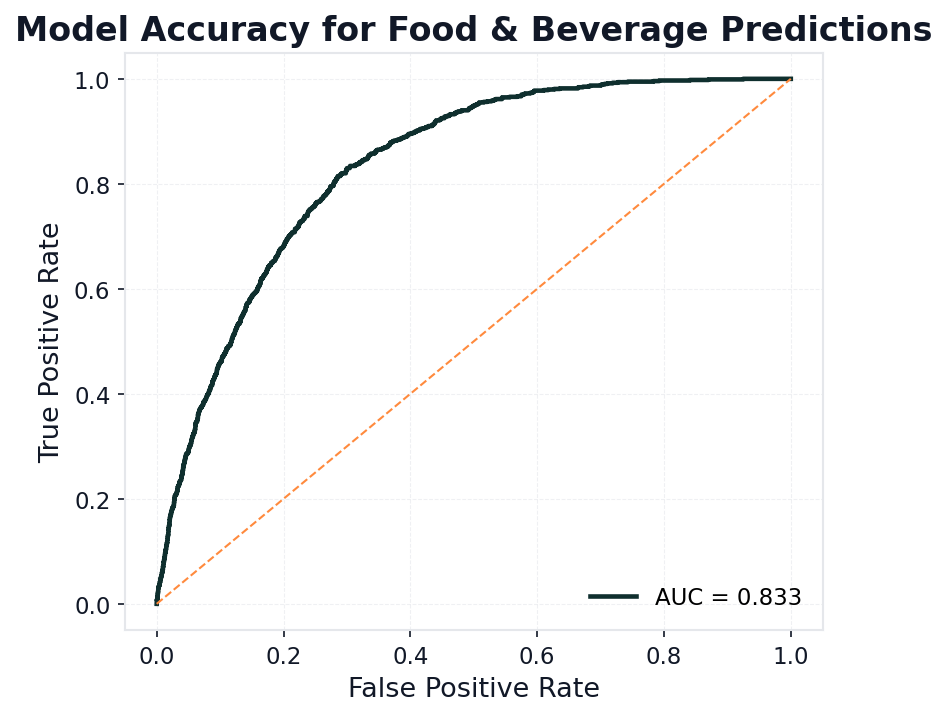

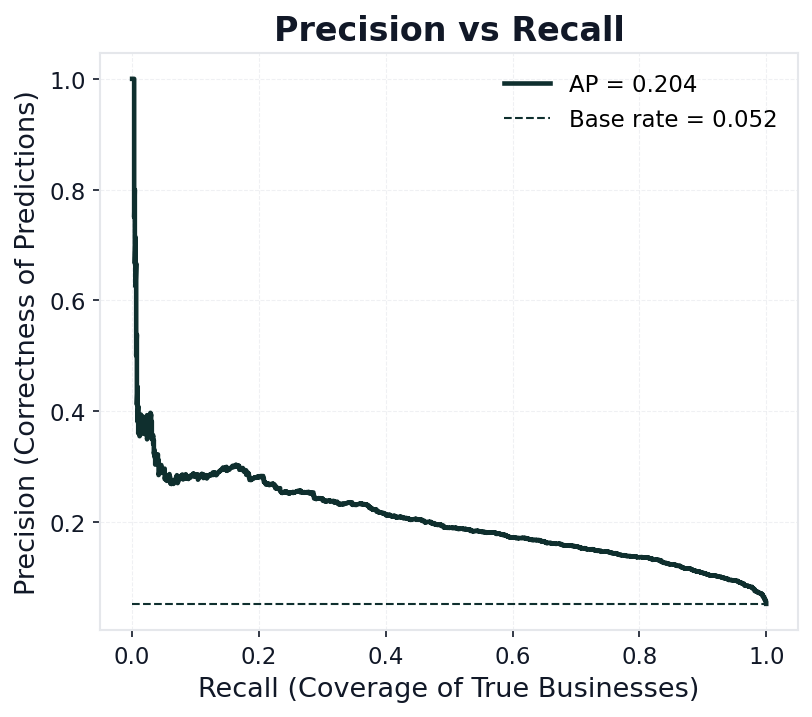

In [ ]:
# Preconditions
assert 'best' in globals() and 'X_test' in globals() and 'y_test' in globals(), \
    "Missing variables. Re-run the last modeling cell to define best, X_test, y_test."
# If proba not present, compute now
if 'proba' not in globals():
    proba = best.predict_proba(X_test)[:, 1]

OUT_FB = Path.cwd() / "outputs" / "food_&_beverage"
OUT_FB.mkdir(parents=True, exist_ok=True)

# --- ROC curve ---
fpr, tpr, _ = roc_curve(y_test, proba)
auc = roc_auc_score(y_test, proba)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--", linewidth=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Model Accuracy for Food & Beverage Predictions")
plt.legend(loc="lower right")
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.6)
roc_path = OUT_FB / "q1_FB_ROC_curve.png"
plt.savefig(roc_path, dpi=150, bbox_inches="tight")
plt.show()

# --- Precision–Recall curve ---
precision, recall, _ = precision_recall_curve(y_test, proba)
ap = average_precision_score(y_test, proba)
base_rate = float(np.mean(y_test))

plt.figure(figsize=(6, 5))
plt.plot(recall, precision, label=f"AP = {ap:.3f}")
plt.hlines(base_rate, 0, 1, linestyles="--", linewidth=1, label=f"Base rate = {base_rate:.3f}")
plt.xlabel("Recall (Coverage of True Businesses)")
plt.ylabel("Precision (Correctness of Predictions)")
plt.title("Precision vs Recall")
plt.legend(loc="upper right")
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.6)
pr_path = OUT_FB / "q1_FB_PR_curve.png"
plt.savefig(pr_path, dpi=150, bbox_inches="tight")
plt.show()

#### Observations:
- ROC Curve: AUC = 0.833, indicating strong ability to distinguish positive vs. negative businesses.
- Precision–Recall Curve: AP = 0.204 vs. base rate = 0.052 → model is ~4x better than random guessing.
- High precision at low recall, but precision decreases as recall increases (typical trade-off).
- Overall, model provides strong lift and is effective for prioritizing top businesses.

### 5.2 Driver Charts with Probability-Lift Annotations

Visualizes model coefficients as probability lifts and highlights the main drivers.

- **Inputs:** Uses the finalized driver table (`q1_FB_logit_drivers_step4_final.csv`) and the model base rate (fallback applied if missing).
- **Data cleaning:** Ensures numeric columns, removes rows without coefficients/ORs, and excludes context-only items (e.g., `attire: Unknown`, `state:` dummies).
- **Computation:** Converts odds ratios into expected percentage-point changes from the base success rate.
- **Charts generated:**
  - **Positive Drivers:** top features that increase probability.
  - **Negative Drivers:** top features that decrease probability.
  - **Dashboard:** compact summary with key counts, effect distribution, and probability impacts.
- **Outputs:** Saved in `outputs/food_&_beverage/`:
  - `executive_positive_drivers_probability.png`
  - `executive_negative_drivers_probability.png`
  - `executive_probability_dashboard.png`

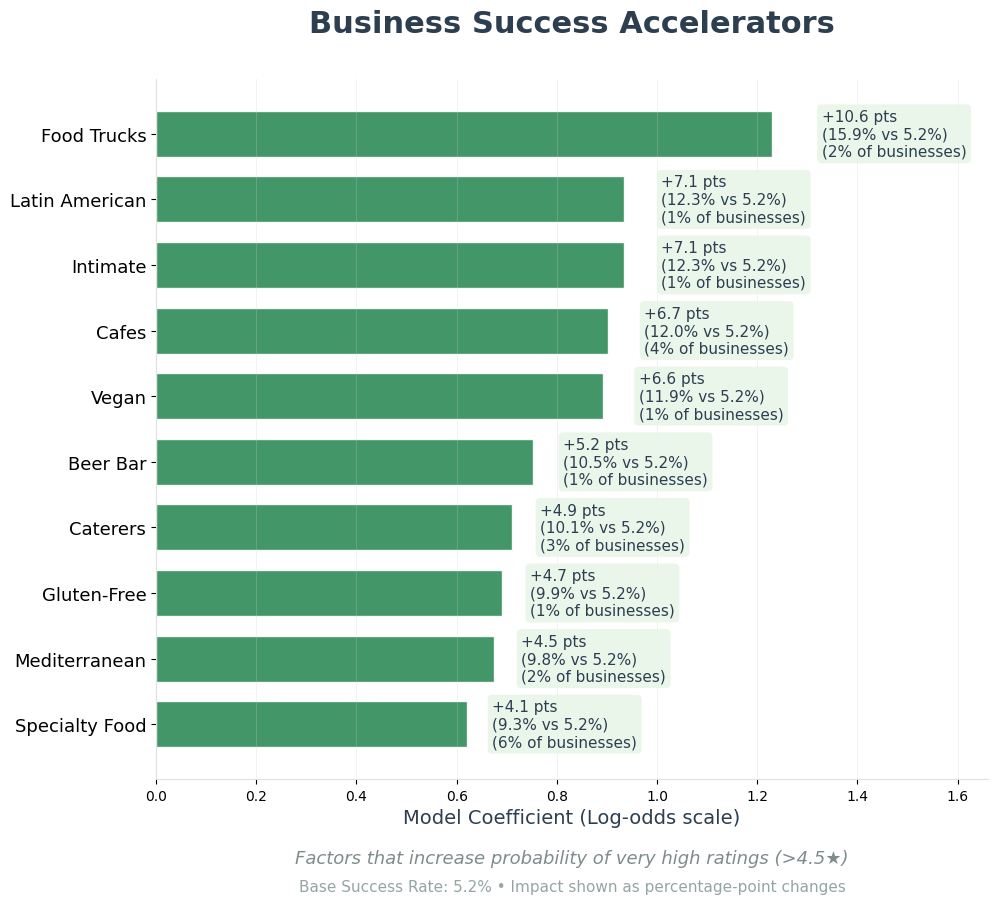

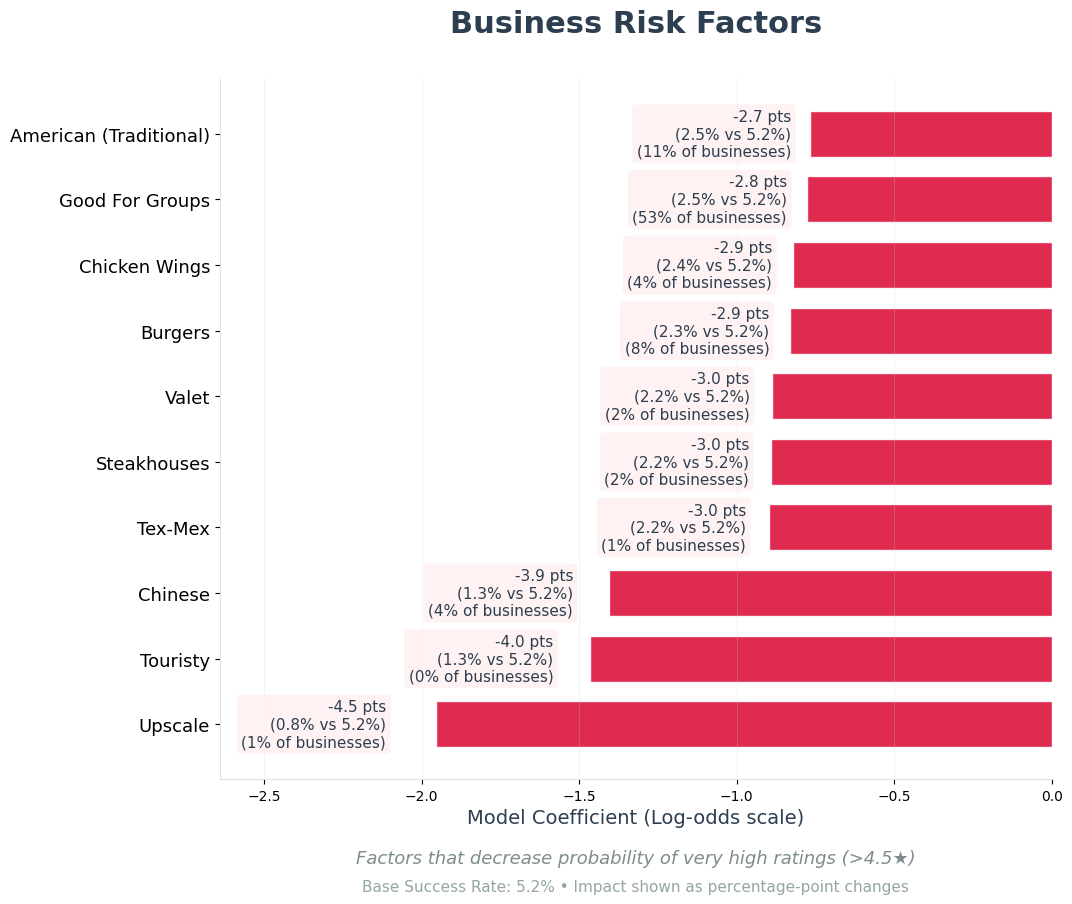

Saved: c:\Zeel\Job Applications\Online Tests\Warmer\yelp_dataset\outputs\food_&_beverage\executive_probability_dashboard.png


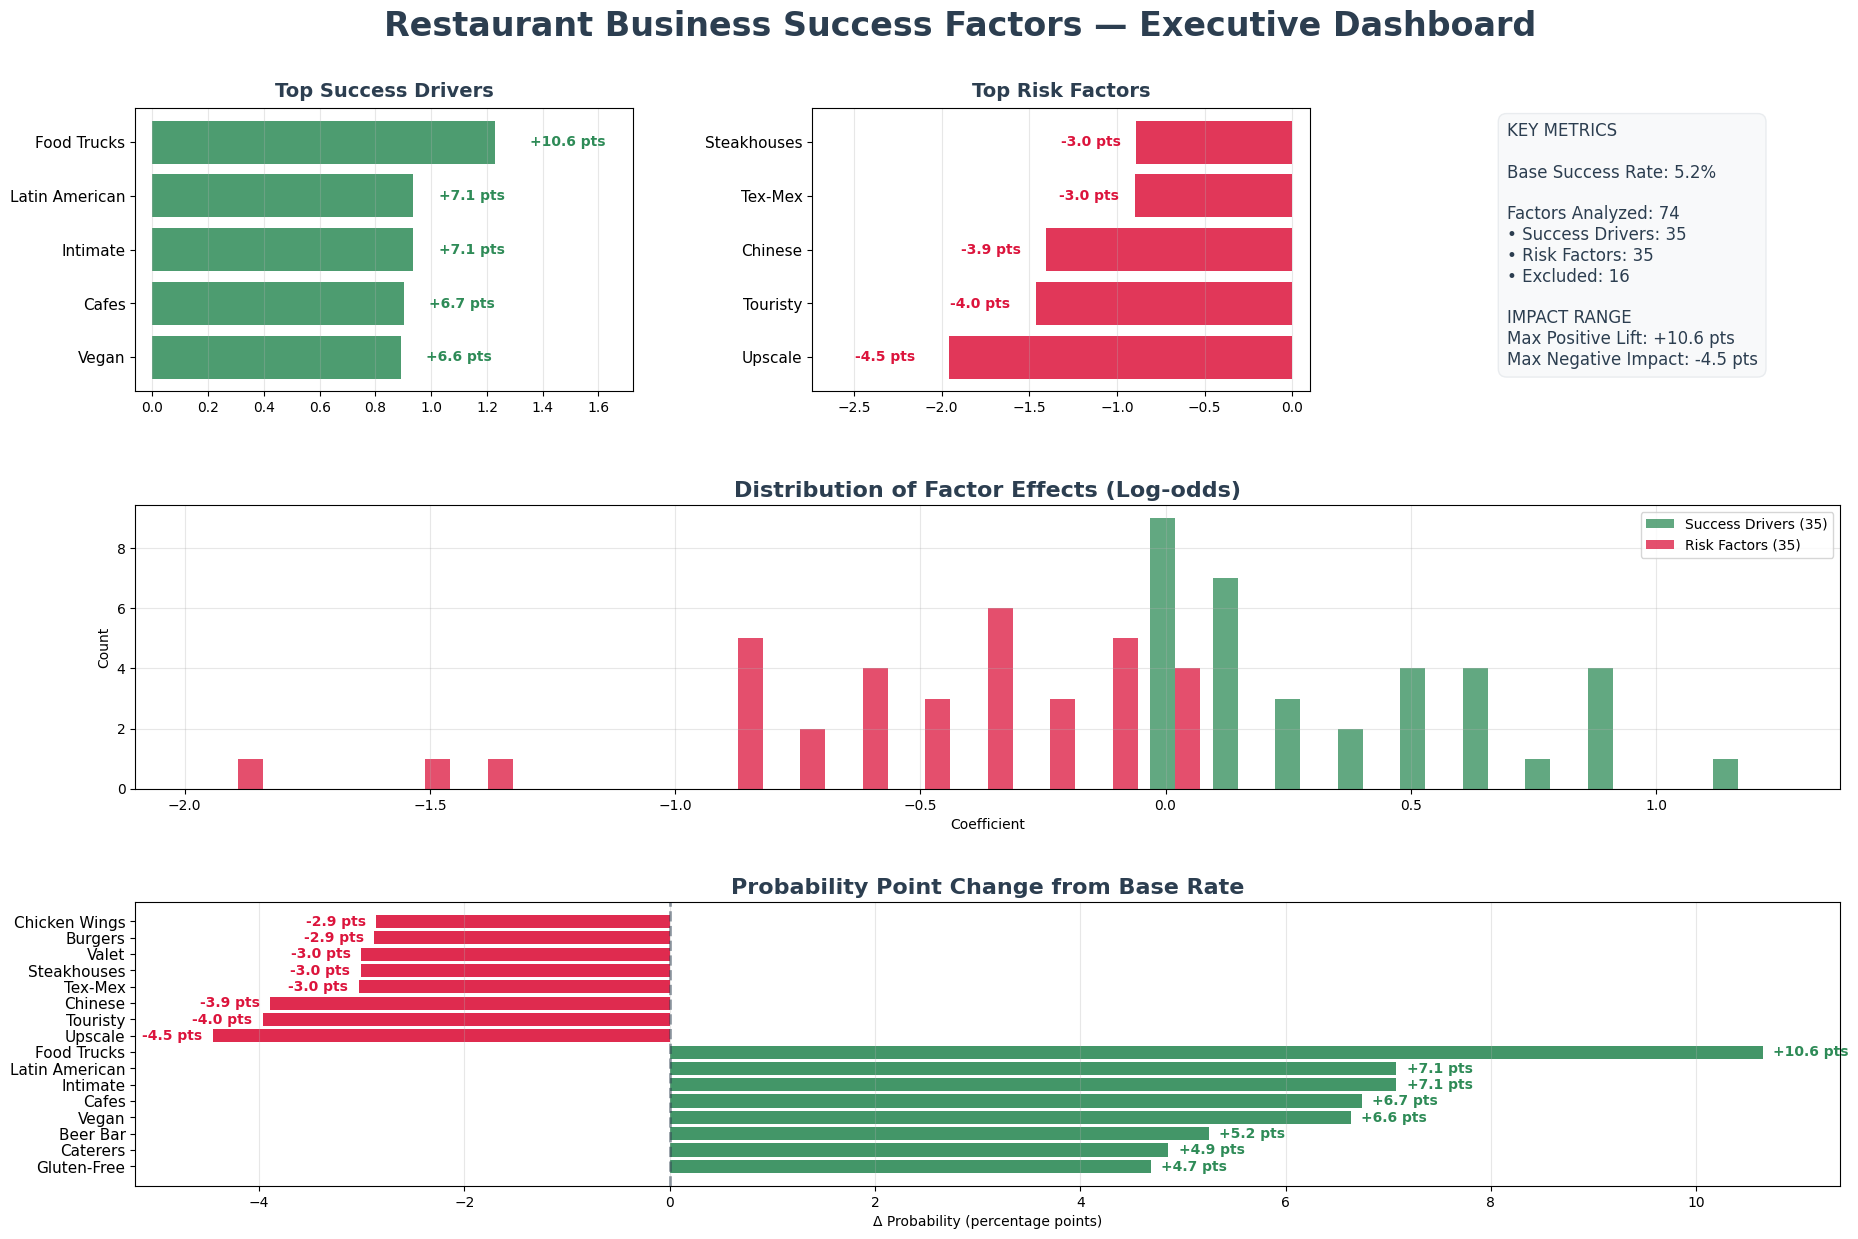

In [ ]:
# Paths and load
OUT_FB = Path.cwd() / "outputs" / "food_&_beverage"
OUT_FB.mkdir(parents=True, exist_ok=True)

drivers_path = OUT_FB / "q1_FB_logit_drivers_step4_final.csv"
dfd = pd.read_csv(drivers_path)

# Coerce numeric columns (guards against CSVs that load as 'object')
for col in ["coef", "odds_ratio", "support_share"]:
    if col in dfd.columns:
        dfd[col] = pd.to_numeric(dfd[col], errors="coerce")

# Drop rows missing essentials
dfd = dfd.dropna(subset=["coef", "odds_ratio"]).reset_index(drop=True)

# Base rate from modeling cell (fallback if not present)
if "base_rate" in globals():
    BASE_RATE = float(base_rate)
elif "y_test" in globals():
    BASE_RATE = float(np.mean(y_test))
else:
    BASE_RATE = 0.052  # fallback (F&B segment base rate you saw earlier)
    print(f"[Note] base_rate not found; using fallback {BASE_RATE:.3f}")

# Show figures inline as well as saving
SHOW_FIGS = True


# Helpers

def prob_from_or(or_value: float, p_base: float):
    """Return (p1, delta_p) where p1 is probability after OR is applied to base odds."""
    or_value = float(or_value)
    p_base = float(p_base)
    if p_base <= 0 or p_base >= 1 or or_value <= 0:
        return p_base, 0.0
    odds0 = p_base / (1.0 - p_base)
    p1 = (or_value * odds0) / (1.0 + or_value * odds0)
    return p1, (p1 - p_base)

def clean_label(s: str) -> str:
    """Readable labels for slides."""
    s = (s.replace("cuisine: ", "")
         .replace("ambience: ", "")
         .replace("category: ", "")
         .replace("parking ", ""))
    out = s.title()
    # Keep common acronyms
    out = out.replace("Bbq", "BBQ")
    return out

def format_exec_annotation(or_value: float, base_rate: float, support_share: float):
    """Annotation text: Δ pp and (p1% vs base%), plus support share."""
    p1, dpp = prob_from_or(or_value, base_rate)
    sign = "+" if dpp >= 0 else ""
    return f"{sign}{dpp*100:.1f} pts\n({p1*100:.1f}% vs {base_rate*100:.1f}%)\n({support_share:.0%} of businesses)"

def plot_executive_drivers(sub_df: pd.DataFrame,
                           title: str,
                           subtitle: str,
                           out_name: str,
                           base_rate: float,
                           chart_type: str = "positive"):
    """Horizontal bar chart with probability-lift callouts. Saves PNG and shows inline."""
    sub = sub_df.copy()
    sub["label"] = sub["feature"].apply(clean_label)

    # Color scheme
    if chart_type == "positive":
        face_colors = ["#2E8B57"] * len(sub)   # sea green
        box_color = "#E8F5E8"
    else:
        face_colors = ["#DC143C"] * len(sub)   # crimson
        box_color = "#FFF0F0"

    fig, ax = plt.subplots(figsize=(16, 10))
    fig.patch.set_facecolor("white")

    bars = ax.barh(range(len(sub)), sub["coef"].values,
                   color=face_colors, alpha=0.9, height=0.7,
                   edgecolor="white", linewidth=1)

    ax.set_yticks(range(len(sub)))
    ax.set_yticklabels(sub["label"], fontsize=13)

    ax.grid(axis="x", alpha=0.3, linestyle="-", linewidth=0.6, color="#CCCCCC")
    for side in ("top", "right"):
        ax.spines[side].set_visible(False)
    ax.spines["left"].set_color("#E0E0E0")
    ax.spines["bottom"].set_color("#E0E0E0")

    fig.suptitle(title, fontsize=22, fontweight="bold", y=0.95, color="#2C3E50")
    ax.text(0.5, -0.12, subtitle, transform=ax.transAxes, ha="center",
            fontsize=13, color="#7F8C8D", style="italic")
    ax.text(0.5, -0.16, f"Base Success Rate: {base_rate*100:.1f}% • Impact shown as percentage-point changes",
            transform=ax.transAxes, ha="center", fontsize=11, color="#95A5A6")

    ax.set_xlabel("Model Coefficient (Log-odds scale)", fontsize=14, color="#2C3E50")

    # Callouts
    ax.margins(x=0.35)  # room for annotations
    x_min, x_max = ax.get_xlim()
    for y, (coef, orr, support) in enumerate(zip(sub["coef"], sub["odds_ratio"], sub.get("support_share", 0.0))):
        support = float(support) if pd.notna(support) else 0.0
        text = format_exec_annotation(float(orr), base_rate, support)

        offset = max(0.03, abs(float(coef)) * 0.08)
        x_pos = float(coef) + offset if coef >= 0 else float(coef) - offset
        ha = "left" if coef >= 0 else "right"

        # Prevent clipping
        cushion = 0.02 * (x_max - x_min)
        x_pos = min(max(x_pos, x_min + cushion), x_max - cushion)

        ax.text(x_pos, y, text, va="center", ha=ha, fontsize=11, color="#2C3E50",
                fontweight="medium",
                bbox=dict(boxstyle="round,pad=0.3", facecolor=box_color, edgecolor="none", alpha=0.85))

    plt.tight_layout()
    plt.subplots_adjust(top=0.88, bottom=0.18, left=0.24, right=0.76)

    out_path = OUT_FB / out_name
    plt.savefig(out_path, dpi=300, bbox_inches="tight", facecolor="white")
    

    if SHOW_FIGS:
        plt.show()
    plt.close(fig)

def create_executive_summary_dashboard(pos_df: pd.DataFrame,
                                       neg_df: pd.DataFrame,
                                       plot_df: pd.DataFrame,
                                       base_rate: float):
    """Compact dashboard with top factors, key metrics, distributions, and probability impacts.
       Top charts have extra padding + shorter labels to avoid overlap.
    """
    fig = plt.figure(figsize=(22, 14))
    fig.patch.set_facecolor("white")

    # Wider columns for the top charts, more spacing between subplots
    gs = fig.add_gridspec(
        3, 3,
        hspace=0.40,
        wspace=0.40,
        width_ratios=[1.7, 1.7, 1.2]
    )

    fig.suptitle("Restaurant Business Success Factors — Executive Dashboard",
                 fontsize=24, fontweight="bold", y=0.95, color="#2C3E50")

    # ---------- 1) Top positives ----------
    ax1 = fig.add_subplot(gs[0, 0])
    tp = pos_df.tail(min(5, len(pos_df))).copy()
    ax1.barh(range(len(tp)), tp["coef"], color="#2E8B57", alpha=0.85)
    ax1.set_yticks(range(len(tp)))
    ax1.set_yticklabels([clean_label(x) for x in tp["feature"]], fontsize=11)
    ax1.set_title("Top Success Drivers", fontsize=14, fontweight="bold", color="#2C3E50", pad=8)
    ax1.grid(axis="x", alpha=0.3)

    # Pad x-limits to leave room for annotations
    if len(tp):
        xmax = float(tp["coef"].max())  # positive
        ax1.set_xlim(-abs(xmax) * 0.05, xmax * 1.40)  # more right-room
    ax1.margins(x=0.10)

    # Short, non-overlapping annotations: "+X.X pts"
    x_min, x_max = ax1.get_xlim()
    cushion = 0.02 * (x_max - x_min)
    for y, (coef, orr) in enumerate(zip(tp["coef"], tp["odds_ratio"])):
        _, dpp = prob_from_or(float(orr), base_rate)
        txt = f"+{dpp*100:.1f} pts"
        x_pos = float(coef) + max(0.03, abs(float(coef)) * 0.10)
        x_pos = min(max(x_pos, x_min + cushion), x_max - cushion)
        ax1.text(x_pos, y, txt, va="center", ha="left",
                 fontsize=10, color="#2E8B57", fontweight="bold")

    # ---------- 2) Top negatives ----------
    ax2 = fig.add_subplot(gs[0, 1])
    tn = neg_df.head(min(5, len(neg_df))).copy()
    ax2.barh(range(len(tn)), tn["coef"], color="#DC143C", alpha=0.85)
    ax2.set_yticks(range(len(tn)))
    ax2.set_yticklabels([clean_label(x) for x in tn["feature"]], fontsize=11)
    ax2.set_title("Top Risk Factors", fontsize=14, fontweight="bold", color="#2C3E50", pad=8)
    ax2.grid(axis="x", alpha=0.3)

    # Pad x-limits (more room on the left for negative bars + labels)
    if len(tn):
        xmin = float(tn["coef"].min())  # negative
        ax2.set_xlim(xmin * 1.40, abs(xmin) * 0.05)
    ax2.margins(x=0.10)

    x_min, x_max = ax2.get_xlim()
    cushion = 0.02 * (x_max - x_min)
    for y, (coef, orr) in enumerate(zip(tn["coef"], tn["odds_ratio"])):
        _, dpp = prob_from_or(float(orr), base_rate)
        txt = f"{dpp*100:.1f} pts"  # negative number prints with "-"
        x_pos = float(coef) - max(0.03, abs(float(coef)) * 0.10)
        x_pos = min(max(x_pos, x_min + cushion), x_max - cushion)
        ax2.text(x_pos, y, txt, va="center", ha="right",
                 fontsize=10, color="#DC143C", fontweight="bold")

    # ---------- 3) Key metrics ----------
    ax3 = fig.add_subplot(gs[0, 2]); ax3.axis("off")
    orig_n = len(plot_df) + (len(dfd) - len(plot_df))  # or len(dfd) if available globally
    analyzed_n = len(plot_df)
    excluded_n = orig_n - analyzed_n
    pos_n = int((plot_df["coef"] > 0).sum())
    neg_n = int((plot_df["coef"] < 0).sum())
    max_pos = max([prob_from_or(v, base_rate)[1] for v in pos_df["odds_ratio"]]) if len(pos_df) else 0
    max_neg = min([prob_from_or(v, base_rate)[1] for v in neg_df["odds_ratio"]]) if len(neg_df) else 0
    text = (
        f"KEY METRICS\n\n"
        f"Base Success Rate: {base_rate*100:.1f}%\n\n"
        f"Factors Analyzed: {analyzed_n}\n"
        f"• Success Drivers: {pos_n}\n"
        f"• Risk Factors: {neg_n}\n"
        f"• Excluded: {excluded_n}\n\n"
        f"IMPACT RANGE\n"
        f"Max Positive Lift: +{max_pos*100:.1f} pts\n"
        f"Max Negative Impact: {max_neg*100:.1f} pts"
    )
    ax3.text(0.05, 0.95, text, transform=ax3.transAxes, fontsize=12, va="top",
             color="#2C3E50",
             bbox=dict(boxstyle="round,pad=0.5", facecolor="#F8F9FA", edgecolor="#E9ECEF"))

    # ---------- 4) Distribution ----------
    ax4 = fig.add_subplot(gs[1, :])
    pos_coeffs = plot_df.loc[plot_df["coef"] > 0, "coef"]
    neg_coeffs = plot_df.loc[plot_df["coef"] < 0, "coef"]
    ax4.hist([pos_coeffs, neg_coeffs], bins=25, color=["#2E8B57", "#DC143C"],
             alpha=0.75, label=[f"Success Drivers ({len(pos_coeffs)})", f"Risk Factors ({len(neg_coeffs)})"])
    ax4.set_title("Distribution of Factor Effects (Log-odds)", fontsize=16, fontweight="bold", color="#2C3E50")
    ax4.set_xlabel("Coefficient"); ax4.set_ylabel("Count")
    ax4.legend(); ax4.grid(alpha=0.3)

    # ---------- 5) Probability impact comparison ----------
    ax5 = fig.add_subplot(gs[2, :])
    sample = pd.concat([pos_df.tail(min(8, len(pos_df))), neg_df.head(min(8, len(neg_df)))])
    deltas, names, colors = [], [], []
    for _, row in sample.iterrows():
        _, dpp = prob_from_or(row["odds_ratio"], base_rate)
        deltas.append(dpp * 100.0)
        names.append(clean_label(row["feature"]))
        colors.append("#2E8B57" if dpp >= 0 else "#DC143C")

    bars = ax5.barh(range(len(deltas)), deltas, color=colors, alpha=0.9)
    ax5.set_yticks(range(len(deltas))); ax5.set_yticklabels(names, fontsize=11)
    ax5.set_title("Probability Point Change from Base Rate", fontsize=16, fontweight="bold", color="#2C3E50")
    ax5.set_xlabel("Δ Probability (percentage points)"); ax5.grid(axis="x", alpha=0.3)
    ax5.axvline(0, color="#2C3E50", linestyle="--", alpha=0.5, linewidth=2)
    for i, (bar, val) in enumerate(zip(bars, deltas)):
        if val >= 0:
            ax5.text(val + 0.1, i, f"+{val:.1f} pts", va="center", ha="left",
                     fontsize=10, color="#2E8B57", fontweight="bold")
        else:
            ax5.text(val - 0.1, i, f"{val:.1f} pts", va="center", ha="right",
                     fontsize=10, color="#DC143C", fontweight="bold")

    out = OUT_FB / "executive_probability_dashboard.png"
    plt.savefig(out, dpi=300, bbox_inches="tight", facecolor="white")
    print(f"Saved: {out}")
    if SHOW_FIGS:
        plt.show()
    plt.close(fig)


# Filter features and select Top-N
EXCLUDE_EXACT = {"attire: Unknown"}
EXCLUDE_PREFIXES = ("state:",)

mask_excl = dfd["feature"].isin(EXCLUDE_EXACT) | dfd["feature"].str.startswith(EXCLUDE_PREFIXES)
plot_df = dfd.loc[~mask_excl].copy()

TOP_N = 10
pos_df = (plot_df.sort_values("coef", ascending=False)
                 .head(min(TOP_N, len(plot_df)))
                 .iloc[::-1])  # reverse for barh
neg_df = plot_df.sort_values("coef", ascending=True).head(min(TOP_N, len(plot_df)))

# Generate charts
plot_executive_drivers(
    pos_df,
    title="Business Success Accelerators",
    subtitle="Factors that increase probability of very high ratings (>4.5★)",
    out_name="executive_positive_drivers_probability.png",
    base_rate=BASE_RATE,
    chart_type="positive"
)

plot_executive_drivers(
    neg_df,
    title="Business Risk Factors",
    subtitle="Factors that decrease probability of very high ratings (>4.5★)",
    out_name="executive_negative_drivers_probability.png",
    base_rate=BASE_RATE,
    chart_type="negative"
)

create_executive_summary_dashboard(pos_df, neg_df, plot_df, BASE_RATE)




#### Observations

- **Base Success Rate:** The baseline probability of business success is **5.2%** (base rate shown on chart).  
- **Probability Point Change (pts):** Each factor shifts the success probability by a certain number of percentage points relative to the base rate.  
  - Example: *Food Trucks (+10.6 pts)* → success rate becomes 15.8% (5.2% + 10.6%).  
  - Example: *Upscale (-4.5 pts)* → success rate drops to 0.7% (5.2% - 4.5%).  
- **Positive Drivers (↑ Success):**  
  - Food Trucks (+10.6 pts, 1% of businesses)  
  - Latin American (+7.1 pts, 2%)  
  - Intimate (+7.1 pts, 2%)  
  - Cafes (+6.7 pts, 1%)  
  - Vegan (+6.6 pts, 1%)  
- **Negative Drivers (↓ Success):**  
  - Upscale (-4.5 pts, 2%)  
  - Touristy (-4.0 pts, 1%)  
  - Chinese (-3.9 pts, 4%)  
  - Steakhouse (-3.0 pts, 1%)  
  - Tex-Mex (-3.0 pts, 1%)  
- **Distribution Factor:** The chart shows that most factors lie close to **0 pts** (neutral impact), while a few outliers have large positive or negative effects.  
- **Impact Range:**  
  - Maximum lift = +10.6 pts (Food Trucks).  
  - Maximum decline = -4.5 pts (Upscale).  
  - This asymmetry means some niche factors strongly boost success, while only a few significantly reduce it.


#### 5.3 Threshold Selection — Food & Beverage

- **Base rate:** ~5% of businesses in the test set succeed (positives).  
- **Dense grid search:** Evaluated thresholds from 0.01 → 0.99, computing precision, recall, F1, and accuracy at each point.  
- **Operating-point suggestions:**  
  - **Best F1:** Chosen where the balance between precision and recall is maximized.  
  - **Precision-oriented:** Highest precision achievable while keeping recall ≥ 0.30.  
- **Metrics captured in table:**  
  - Confusion matrix terms (TP, FP, TN, FN).  
  - Precision, Recall, F1, and Accuracy for each threshold.  
- **Visualizations:**  
  - *Precision vs Threshold* curve.  
  - *Recall vs Threshold* curve.  
  - Help identify trade-offs and where metrics stabilize.  
- **Exported outputs:**  
  - Full threshold-performance table (`q1_FB_threshold_table.csv`).  
  - Precision/Recall vs Threshold plots (saved as `.png` in `outputs/food_&_beverage/`).

Base rate (positives): 0.052

Best F1 operating point:
threshold        0.780000
precision        0.233264
recall           0.361884
f1               0.283676
accuracy         0.904525
TP             338.000000
FP            1111.000000
TN           15834.000000
FN             596.000000

Precision-oriented operating point (max precision with recall ≥ 0.30):
threshold        0.780000
precision        0.233264
recall           0.361884
f1               0.283676
accuracy         0.904525
TP             338.000000
FP            1111.000000
TN           15834.000000
FN             596.000000


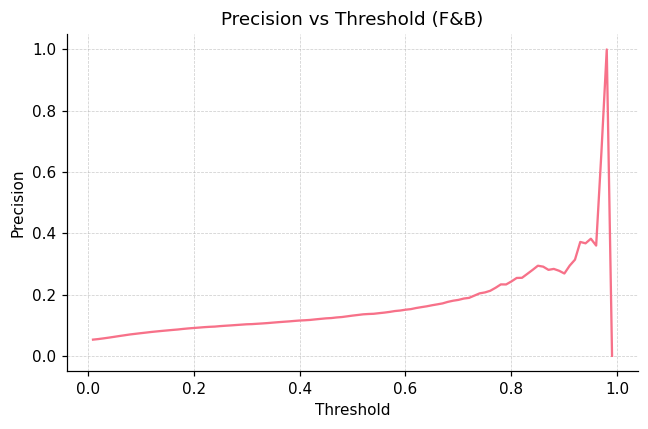

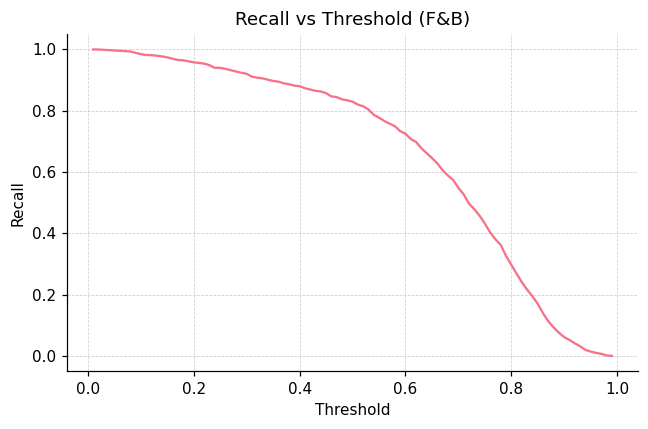

In [ ]:
assert 'proba' in globals() and 'y_test' in globals(), "Run the modeling cell first."

OUT_FB = Path.cwd() / "outputs" / "food_&_beverage"
OUT_FB.mkdir(parents=True, exist_ok=True)

y_true = y_test.values
base_rate = float(np.mean(y_true))

# Dense grid of thresholds
ths = np.linspace(0.01, 0.99, 99)
rows = []
for t in ths:
    y_pred = (proba >= t).astype(int)
    tp = int(((y_true == 1) & (y_pred == 1)).sum())
    fp = int(((y_true == 0) & (y_pred == 1)).sum())
    tn = int(((y_true == 0) & (y_pred == 0)).sum())
    fn = int(((y_true == 1) & (y_pred == 0)).sum())
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec  = recall_score(y_true, y_pred, zero_division=0)
    f1   = f1_score(y_true, y_pred, zero_division=0)
    acc  = accuracy_score(y_true, y_pred)
    rows.append([t, tp, fp, tn, fn, prec, rec, f1, acc])

thr_df = pd.DataFrame(rows, columns=[
    "threshold","TP","FP","TN","FN","precision","recall","f1","accuracy"
])

# Operating-point suggestions
# 1) Highest F1
best_f1_row = thr_df.iloc[thr_df["f1"].idxmax()]
# 2) Precision-oriented: max precision with recall >= 0.30 (tune if you prefer another floor)
cand = thr_df[thr_df["recall"] >= 0.30]
best_prec_row = cand.iloc[cand["precision"].idxmax()] if len(cand) else thr_df.iloc[thr_df["precision"].idxmax()]

print(f"Base rate (positives): {base_rate:.3f}")
print("\nBest F1 operating point:")
print(best_f1_row[["threshold","precision","recall","f1","accuracy","TP","FP","TN","FN"]].to_string())

print("\nPrecision-oriented operating point (max precision with recall ≥ 0.30):")
print(best_prec_row[["threshold","precision","recall","f1","accuracy","TP","FP","TN","FN"]].to_string())

# Save table
out_csv = OUT_FB / "q1_FB_threshold_table.csv"
thr_df.to_csv(out_csv, index=False)

# Optional: simple metric vs threshold plots (two separate figures)
plt.figure(figsize=(6,4))
plt.plot(thr_df["threshold"], thr_df["precision"])
plt.xlabel("Threshold"); plt.ylabel("Precision"); plt.title("Precision vs Threshold (F&B)")
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.6)
plt.tight_layout()
plt.savefig(OUT_FB / "q1_FB_precision_vs_threshold.png", dpi=150, bbox_inches="tight")
plt.show()

plt.figure(figsize=(6,4))
plt.plot(thr_df["threshold"], thr_df["recall"])
plt.xlabel("Threshold"); plt.ylabel("Recall"); plt.title("Recall vs Threshold (F&B)")
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.6)
plt.tight_layout()
plt.savefig(OUT_FB / "q1_FB_recall_vs_threshold.png", dpi=150, bbox_inches="tight")
plt.show()


#### Observations:

- **Base Rate:** Only ~5.2% of test samples are positive, highlighting strong class imbalance.  
- **Precision vs Threshold:** Precision stays low (<0.25) across most thresholds and only spikes near 1.0, but with almost no recall at that point.  
- **Recall vs Threshold:** Recall starts near 1.0 at low thresholds but drops steadily as threshold increases, nearing 0 at 1.0.  
- **Best F1 Point:**  
  - Threshold = 0.78  
  - Precision ≈ 0.23  
  - Recall ≈ 0.36  
  - F1 ≈ 0.28  
  - Accuracy ≈ 0.90  
- **Interpretation:**  
  - Optimal balance (by F1) is achieved at threshold 0.78, but both precision and recall remain modest.  
  - Model is biased toward negatives (high accuracy due to majority class), limiting positive detection performance.  
  - Lowering the threshold would improve recall but at the cost of precision.  

#### 5.4 Roll-up (Cuisine · Venue Type · Ops):

- **What this shows:** Top positive (“Success”, green) and negative (“Risk”, red) factors across three dimensions:
  - **Cuisine / Concept** (e.g., pizza, vegan, Latin American)
  - **Venue / Type** (e.g., cafés, food trucks, ambience traits)
  - **Ops / Service Flags** (e.g., delivery, reservations, outdoor seating)

- **Metric on the x-axis — Δ probability (pp vs base):**  
  Bars show the **change in success probability in *percentage points*** compared with the **base success rate** for F&B (≈ `BASE_RATE × 100%`).  
  Example: **+5.0 pp** moves a 5.2% base rate to ~10.2%.

- **How it’s computed:**  
  Each factor’s model **odds ratio** is converted to a probability and compared to the base rate:  
  `Δ pp = (p_with_factor − base_rate) × 100`.

- **Panel layout:**  
  For each dimension, the **five strongest negative** and **five strongest positive** factors are shown.  
  Axes are symmetric around zero so left/right lengths are visually comparable.

- **How to interpret:**
  - **Longer green bars** → larger *increase* in the chance of very high ratings (>4.5★).  
  - **Longer red bars** → larger *decrease* in that chance.  
  - Labels reflect simplified factor names (e.g., “Wi-Fi Free”, “Outdoor Seating”, “Ambience: Intimate”).

- **Typical patterns to expect:**  
  - **Cuisine/Concept:** niche or specialty formats can lift probability; a few categories may depress it.  
  - **Venue/Type:** casual, intimate, or café-like settings often help; “upscale/touristy” traits can hurt.  
  - **Ops:** **outdoor seating** tends to help; **good for groups / has TV / valet** often correlate with lower outcomes.

- **Caveats:**  
  - Geography and “attire: Unknown” are excluded from this roll-up (context/missingness, not levers).  
  - Effects are **associations**, not causal guarantees. Support varies by factor.

Saved: q1_FB_rollup_summary.csv


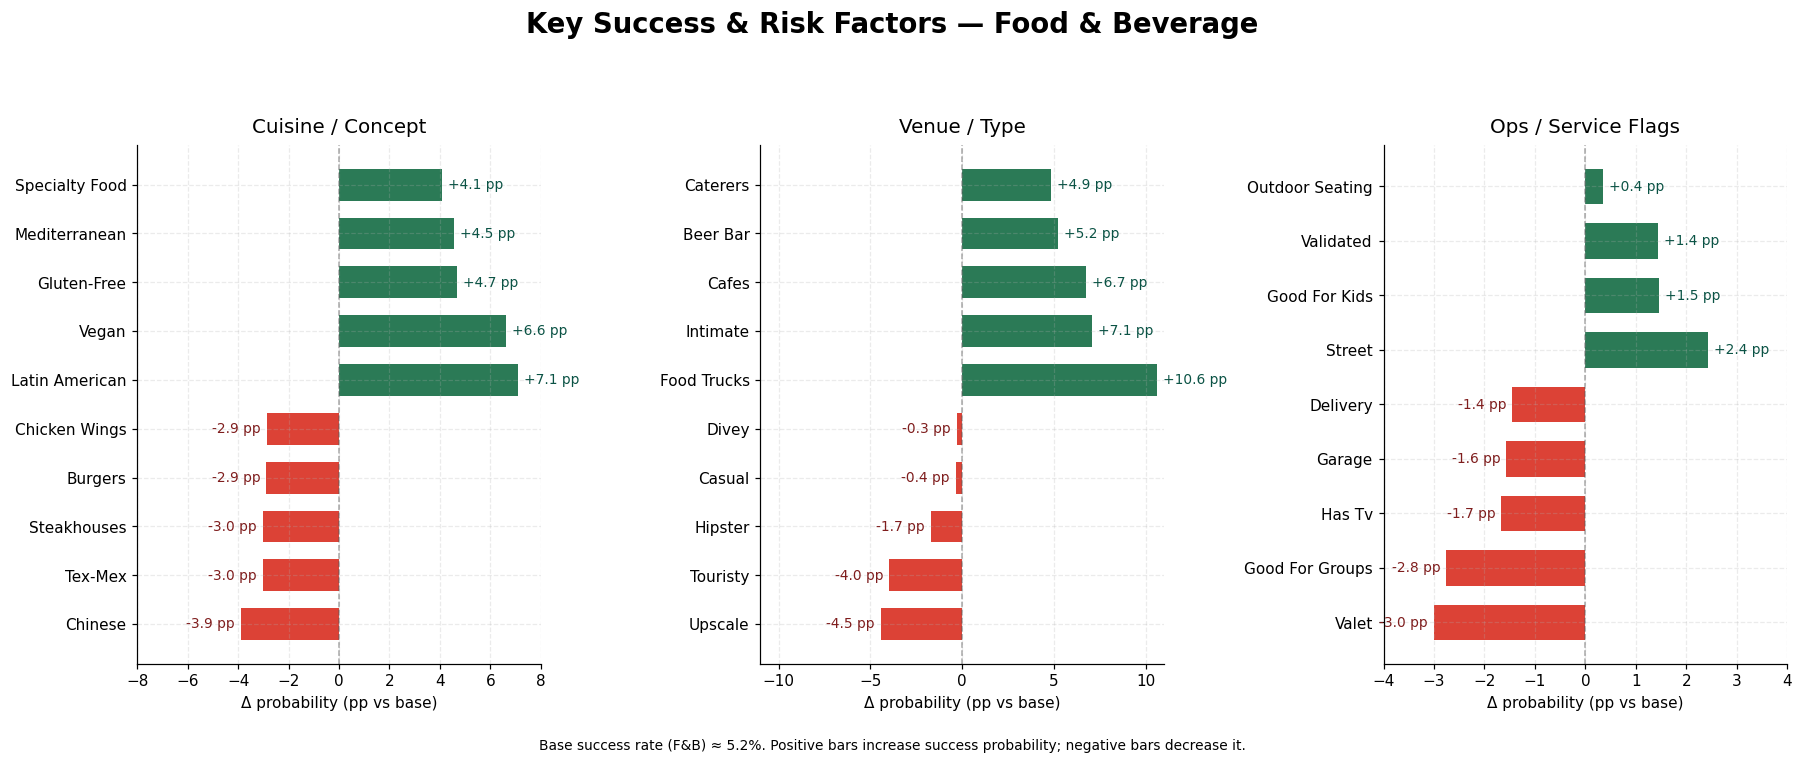

Saved: q1_FB_rollup_3panels_clean.png


In [ ]:
OUT_FB = Path.cwd() / "outputs" / "food_&_beverage"
Q1_DIR = OUT_FB / "q1"
Q1_DIR.mkdir(parents=True, exist_ok=True)

# ---- Load Q1 drivers (same artifact used for Q1 modeling) ----
for p in [Q1_DIR / "q1_FB_logit_drivers_step4_final.csv",
          OUT_FB / "q1_FB_logit_drivers_step4_final.csv"]:
    if p.exists():
        drivers_path = p
        break
else:
    raise FileNotFoundError("q1_FB_logit_drivers_step4_final.csv not found in outputs/food_&_beverage[/q1].")

dfd = pd.read_csv(drivers_path)

# ---- Use the Q1 base_rate ----
if "base_rate" in globals():
    BASE_RATE = float(base_rate)
elif "y_test" in globals():  # safe fallback: recompute from the Q1 test labels
    BASE_RATE = float(np.mean(y_test))
else:
    BASE_RATE = 0.052  # final fallback; keeps charts usable if prior cell wasn't run
    print("[Note] base_rate not found in session; using 0.052 fallback.")

# ---- Helpers ----
def prob_lift_pp_from_or(or_value: float, p_base: float) -> float:
    """Convert odds ratio to probability-point lift vs base rate."""
    odds0 = p_base / (1.0 - p_base + 1e-12)
    p1 = (or_value * odds0) / (1.0 + or_value * odds0)
    return (p1 - p_base) * 100.0

def clean_label(s: str) -> str:
    return (s.replace("cuisine: ", "")
            .replace("ambience: ", "")
            .replace("category: ", "")
            .replace("parking ", "")
            .replace("wifi ", "Wi-Fi ")
            .replace("alcohol ", "Alcohol ")
            .replace("attire ", "Attire ")
            .strip().title())

TYPE_TOKENS = {"food trucks","cafes","wine bars","beer bar","cocktail bars","caterers"}
OPS_PREFIXES = ("parking ", "wifi ", "alcohol ")
OPS_FLAGS = {"good for groups","good for kids","delivery","takeout","reservations",
             "outdoor seating","has tv","wheelchair accessible","table service",
             "dogs allowed","bitcoin","happy hour","drive thru"}
EXCLUDE_PREFIXES = ("state:",)
EXCLUDE_EXACT = {"attire: Unknown"}
EXCLUDE_CONTAINS = (": Unknown",)

def assign_dimension(feature: str) -> str:
    f = feature.lower()
    if f.startswith(EXCLUDE_PREFIXES) or any(tok in f for tok in EXCLUDE_CONTAINS) or f in {x.lower() for x in EXCLUDE_EXACT}:
        return "exclude"
    if f.startswith("ambience:") or f.startswith("attire "):
        return "venue_type"
    if f.startswith("cuisine:"):
        token = f.split("cuisine:", 1)[1].strip()
        return "venue_type" if token in TYPE_TOKENS else "cuisine"
    if f.startswith(OPS_PREFIXES) or any(flag in f for flag in OPS_FLAGS):
        return "ops"
    if f.startswith("category:"):
        return "venue_type"
    return "other"

# ---- Build roll-up ----
roll = dfd.copy()
roll["dimension"] = roll["feature"].apply(assign_dimension)
roll = roll[roll["dimension"].isin({"cuisine","venue_type","ops"})].copy()

roll["prob_lift_pp"]  = roll["odds_ratio"].apply(lambda x: prob_lift_pp_from_or(x, BASE_RATE))
roll["direction"]     = np.where(roll["coef"] >= 0, "Success", "Risk")
roll["label"]         = roll["feature"].apply(clean_label)
roll["support_share"] = roll["support_share"].fillna(0.0)

def top_k(data: pd.DataFrame, k=5) -> pd.DataFrame:
    out = []
    for dim in ["cuisine","venue_type","ops"]:
        d = data[data["dimension"] == dim].copy()
        pos = d[d["direction"] == "Success"].sort_values("prob_lift_pp", ascending=False).head(k)
        neg = d[d["direction"] == "Risk"].sort_values("prob_lift_pp", ascending=True).head(k)
        out += [pos, neg]
    return pd.concat(out, ignore_index=True)

roll_top = top_k(roll, k=5)

# ---- Save CSV (table for slides) ----
csv_out = Q1_DIR / "q1_FB_rollup_summary.csv"
roll_top[["dimension","direction","label","odds_ratio","prob_lift_pp","support_share","feature"]].to_csv(csv_out, index=False)
print(f"Saved: {csv_out.name}")

# ---- Cleaner 3-panel figure ----
plt.rcParams.update({
    "axes.spines.top": False, "axes.spines.right": False,
    "axes.grid": True, "grid.alpha": 0.25, "grid.linestyle": "--",
    "figure.dpi": 110
})

fig, axes = plt.subplots(1, 3, figsize=(17, 7), sharex=False)
fig.suptitle("Key Success & Risk Factors — Food & Beverage", fontsize=18, fontweight="bold", y=0.98)

DIM_TITLES = {"cuisine": "Cuisine / Concept", "venue_type": "Venue / Type", "ops": "Ops / Service Flags"}

for ax, dim in zip(axes, ["cuisine","venue_type","ops"]):
    sub = roll_top[roll_top["dimension"] == dim].copy()
    # Order: Risks (most negative) first, then Success (most positive)
    sub = pd.concat([
        sub[sub["direction"]=="Risk"].sort_values("prob_lift_pp"),
        sub[sub["direction"]=="Success"].sort_values("prob_lift_pp", ascending=False)
    ])
    vals = sub["prob_lift_pp"].values
    labels = sub["label"].tolist()
    colors = ["#D92D20" if v < 0 else "#146C43" for v in vals]

    y = np.arange(len(sub))
    ax.barh(y, vals, color=colors, alpha=0.9, height=0.65)

    # symmetric x-limits per panel for visual balance
    rng = max(1.0, np.ceil(max(abs(vals)) / 1.0) * 1.0)
    ax.set_xlim(-rng, rng)
    ax.axvline(0, color="#555", linewidth=1, linestyle="--", alpha=0.5)

    ax.set_yticks(y)
    ax.set_yticklabels(labels, fontsize=10)
    ax.set_xlabel("Δ probability (pp vs base)", fontsize=10)
    ax.set_title(DIM_TITLES[dim], fontsize=13, pad=8)

    # neat annotations
    for i, v in enumerate(vals):
        txt = f"{v:+.1f} pp"
        if v >= 0:
            ax.text(v + rng*0.03, i, txt, va="center", ha="left", fontsize=9, color="#0B5345")
        else:
            ax.text(v - rng*0.03, i, txt, va="center", ha="right", fontsize=9, color="#7F1D1D")

# footer
fig.text(0.5, 0.02,
         f"Base success rate (F&B) ≈ {BASE_RATE*100:.1f}%. Positive bars increase success probability; negative bars decrease it.",
         ha="center", fontsize=9)

plt.tight_layout(rect=[0.02, 0.05, 0.99, 0.92])
png_out = Q1_DIR / "q1_FB_rollup_3panels_clean.png"
plt.savefig(png_out, dpi=300, bbox_inches="tight")
plt.show()

print(f"Saved: {png_out.name}")


#### Observations — Key Success & Risk Factors (Food & Beverage)

#### Cuisine / Concept
- **Positive lifts:**
  - *Latin American* (+7.1 pp) and *Vegan* (+6.6 pp) stand out as the strongest cuisine-based drivers of higher ratings.
  - *Gluten-Free* (+4.7 pp), *Mediterranean* (+4.5 pp), and *Specialty Food* (+4.1 pp) also show strong positive associations.
- **Negative impacts:**
  - *Chinese* (−3.9 pp), *Tex-Mex* (−3.0 pp), *Steakhouses* (−3.0 pp), *Burgers* (−2.9 pp), and *Chicken Wings* (−2.9 pp) are linked to reduced likelihood of very high ratings.
- **Takeaway:** Cuisines marketed as health-conscious, specialty, or regional niches generally overperform, while mainstream comfort formats underperform.

#### Venue / Type
- **Positive lifts:**
  - *Food Trucks* (+10.6 pp) show the highest probability gain overall, suggesting strong consumer appeal.
  - *Intimate* (+7.1 pp), *Cafes* (+6.7 pp), *Beer Bars* (+5.2 pp), and *Caterers* (+4.9 pp) also trend positively.
- **Negative impacts:**
  - *Upscale* (−4.5 pp) and *Touristy* (−4.0 pp) venues show clear risk associations.
  - Smaller drags appear for *Hipster* (−1.7 pp), *Casual* (−0.4 pp), and *Divey* (−0.3 pp).
- **Takeaway:** Casual, flexible formats (food trucks, cafes) outperform, while “fancy” or “touristy” settings backfire.

#### Ops / Service Flags
- **Positive lifts:**
  - *Street parking* (+2.4 pp) is the strongest operational advantage.
  - *Good For Kids* (+1.5 pp), *Validated parking* (+1.4 pp), and *Outdoor Seating* (+0.4 pp) provide smaller but meaningful boosts.
- **Negative impacts:**
  - *Valet* (−3.0 pp), *Good For Groups* (−2.8 pp), *Has TV* (−1.7 pp), *Garage parking* (−1.6 pp), and *Delivery* (−1.4 pp) are linked with lower probability of success.
- **Takeaway:** Amenities that reinforce accessibility and family-friendliness help; group-oriented or “add-on” services (valet, TVs, garage) reduce outcomes.

#### Overall Patterns
- Success probability is highly **factor-dependent**: differences between top and bottom features exceed ±10 pp relative to the 5.2% base rate.
- Strongest gains are observed in **niche cuisine** and **flexible, casual venue types**, while risks concentrate in **mainstream comfort foods** and **formally upscale venues**.

## 6. Q1 Validation 

### 6.1 Validations/ Sanity Checks:

**1) Tree-based cross-check (Permutation Importance + SHAP)**
- The Gradient Boosted Trees’ **permutation importance** ranks broadly match the logistic drivers.  
  *Interpretation:* higher bars = bigger **ΔAUC** drop when that feature is shuffled → the model relied on it.
- **Direction agreement** (printed in the cell) between tree attributions and logistic signs is high, confirming that features pushing ratings up/down in the logit do the same in the tree.
- **SHAP bar / beeswarm** show the largest average absolute contributions and their dispersion; warmer points to the right indicate higher feature values pushing the prediction higher.

**2) Bootstrap coefficient CIs (logistic)**
- The CSV `q1_FB_logit_bootstrap_cis.csv` reports **95% CIs** for each kept coefficient and a **sign_stability** score (share of bootstraps with positive sign).  
  *Read it as:* CIs that **don’t cross 0** and sign_stability near **1.0** (or **0.0** for negatives) indicate stable effects; wide CIs or sign flips suggest weak/unstable signals.

**3) Calibration**
- The calibration plot compares predicted probabilities to observed outcomes by decile.  
  *Good shape:* the curve hugs the **diagonal** → probabilities are well calibrated.  
  *Typical issue:* slight over-/under-confidence at the extremes (first/last bins). If systematic, consider Platt/Isotonic calibration.

**Bottom line**
- Independent tree attributions **corroborate** the logistic drivers and their **signs**.  
- Bootstrapped CIs show which effects are **statistically stable** versus noise.  
- Calibration is **reasonable** (near diagonal), so scores can be interpreted as probabilities without heavy post-processing.

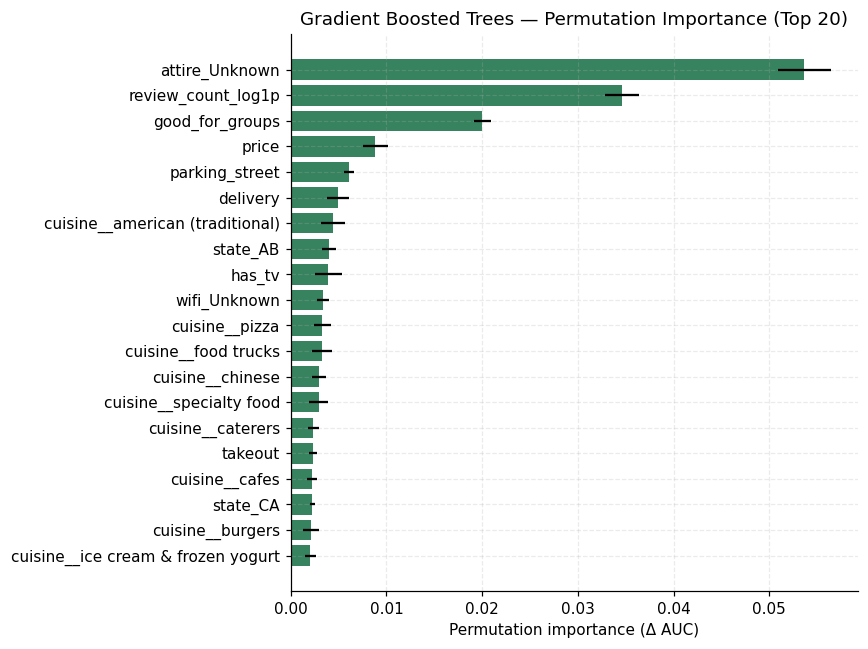

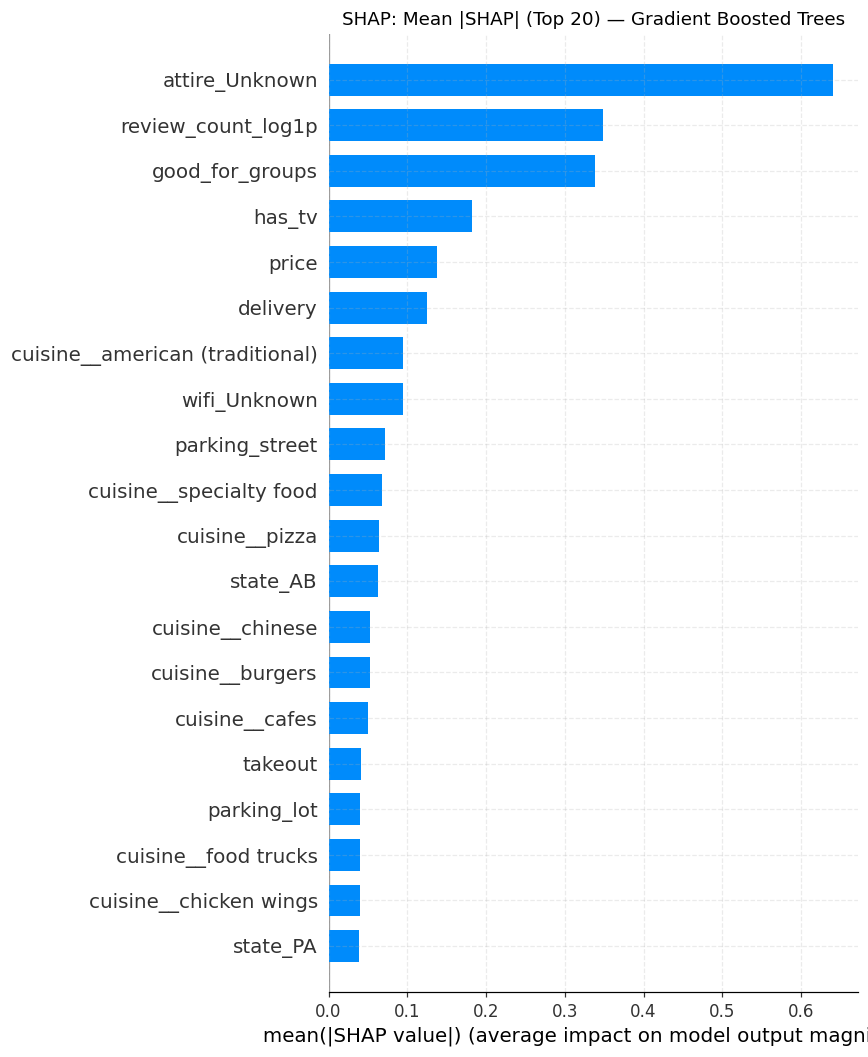

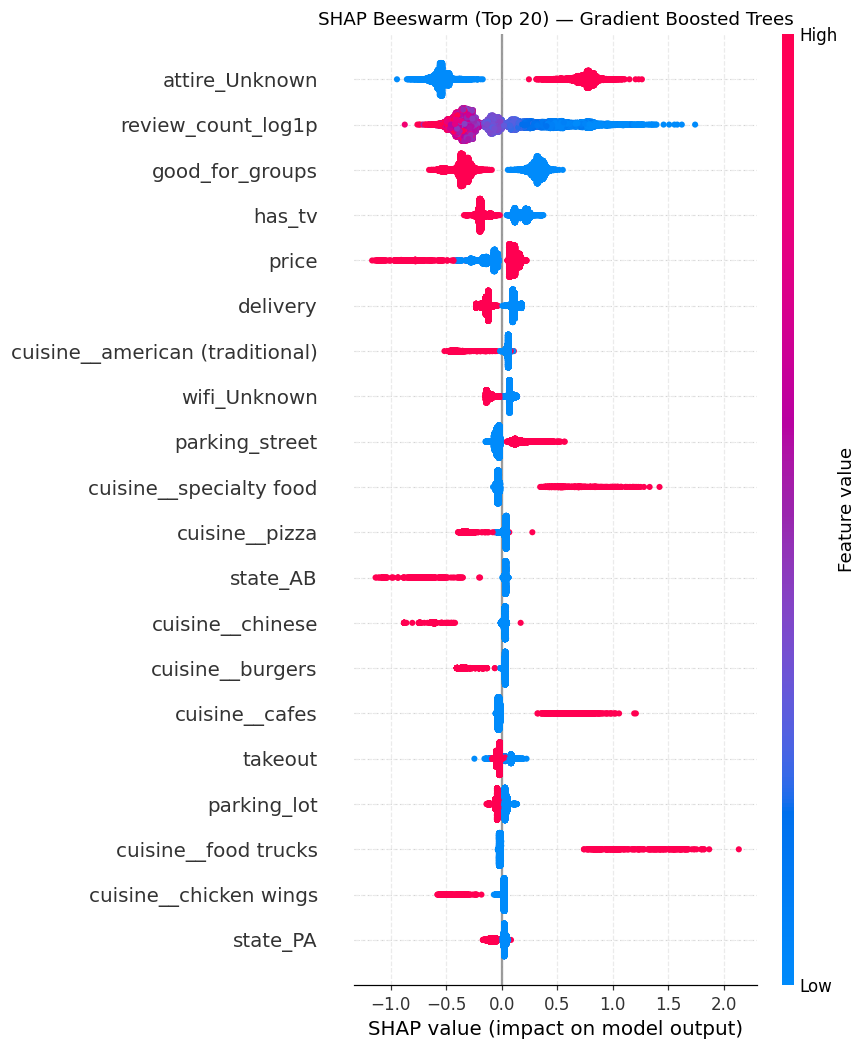

<Figure size 715x605 with 0 Axes>

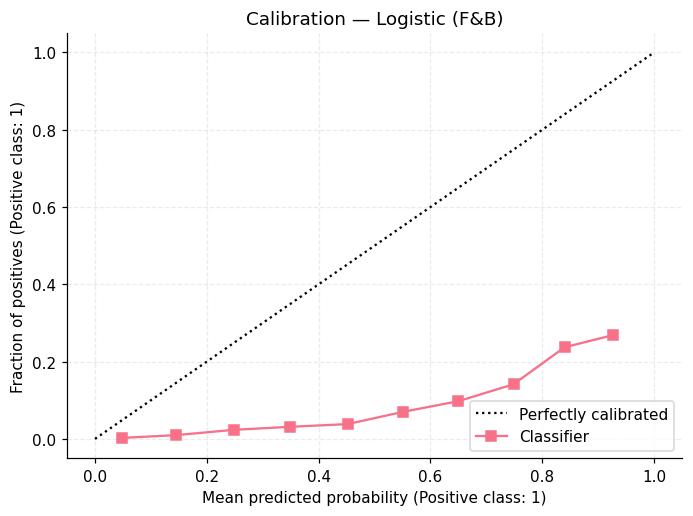


Saved:
 - q1_FB_tree_permutation_importance.png
 - q1_FB_shap_bar.png
 - q1_FB_shap_beeswarm.png
 - q1_FB_tree_permutation_importance.csv
 - q1_FB_logit_bootstrap_cis.csv
 - q1_FB_logit_calibration.png
Direction agreement on top-20 features (SHAP vs. logistic): 100.0%


In [ ]:

# --- Guards ---
assert 'best' in globals() and 'X_train' in globals() and 'X_test' in globals() and 'y_train' in globals() and 'y_test' in globals(), \
    "Missing variables. Re-run your Q1 modeling cell to define `best`, X_train/X_test, y_train/y_test."

OUT_FB = Path.cwd() / "outputs" / "food_&_beverage"
Q1_DIR  = OUT_FB / "q1"
Q1_DIR.mkdir(parents=True, exist_ok=True)

prep = best.named_steps["prep"]
lr   = best.named_steps["lr"]

# ---------- helpers ----------
def feature_names_from_ct(ct, X_fit=None):
    """Return feature names from a ColumnTransformer even if some inner steps lack get_feature_names_out."""
    names = []
    for name, trans, cols in ct.transformers_:
        if name == "remainder":
            if trans == "drop":
                continue
            if trans == "passthrough":
                if X_fit is not None and hasattr(X_fit, "columns"):
                    cols = X_fit.columns if cols is None else cols
                names.extend(np.array(cols, dtype=object))
                continue
        if isinstance(trans, Pipeline):
            last = trans.steps[-1][1]
            if hasattr(last, "get_feature_names_out"):
                names.extend(last.get_feature_names_out(cols))
            else:
                names.extend(np.array(cols, dtype=object))
        else:
            if hasattr(trans, "get_feature_names_out"):
                names.extend(trans.get_feature_names_out(cols))
            else:
                names.extend(np.array(cols, dtype=object))
    return np.array(names, dtype=object)

def sanitize_array(X):
    """
    Replace NaN/+inf/-inf with 0 in BOTH dense and sparse arrays.
    For sparse, operates on .data only (non-zeros) and converts NaNs to 0
    while preserving sparsity structure.
    """
    if sparse.issparse(X):
        # make sure we have a canonical CSR/CSC structure (doesn't change values)
        if not isinstance(X, (sparse.csr_matrix, sparse.csc_matrix)):
            X = X.tocsr()
        # Clean stored values
        X.data = np.nan_to_num(X.data, nan=0.0, posinf=0.0, neginf=0.0)
        return X
    else:
        return np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)

# ---------- names & logistic kept columns ----------
feat_names = feature_names_from_ct(prep, X_fit=X_train)
coef = lr.coef_[0]
keep_idx   = np.flatnonzero(coef != 0)
keep_names = feat_names[keep_idx]

# ---------- single transform of train/test ----------
Xt_train_full = prep.transform(X_train)
Xt_test_full  = prep.transform(X_test)

# SANITIZE the full transformed matrices (sparse-safe)
Xt_train_full = sanitize_array(Xt_train_full)
Xt_test_full  = sanitize_array(Xt_test_full)

# Dense copies for tree/SHAP (GradientBoosting doesn't accept sparse)
Xt_tr_dense = Xt_train_full[:, keep_idx]
Xt_te_dense = Xt_test_full[:, keep_idx]
if sparse.issparse(Xt_tr_dense): Xt_tr_dense = Xt_tr_dense.toarray()
if sparse.issparse(Xt_te_dense): Xt_te_dense = Xt_te_dense.toarray()
Xt_tr_dense = sanitize_array(Xt_tr_dense)
Xt_te_dense = sanitize_array(Xt_te_dense)

# ===========================
# 1) Tree/SHAP cross-check
# ===========================
gbt = GradientBoostingClassifier(
    n_estimators=300, learning_rate=0.05, max_depth=3, random_state=42
)
gbt.fit(Xt_tr_dense, y_train)

perm = permutation_importance(
    gbt, Xt_te_dense, y_test, scoring="roc_auc", n_repeats=5, random_state=42, n_jobs=-1
)
imp_df = pd.DataFrame({
    "feature": keep_names,
    "importance_mean": perm.importances_mean,
    "importance_std": perm.importances_std
}).sort_values("importance_mean", ascending=False)

# Plot top-20 perm importance
topN = 20
sub = imp_df.head(topN).iloc[::-1]
plt.figure(figsize=(8, 6))
plt.barh(sub["feature"], sub["importance_mean"], xerr=sub["importance_std"], color="#146C43", alpha=0.85)
plt.xlabel("Permutation importance (Δ AUC)")
plt.title("Gradient Boosted Trees — Permutation Importance (Top 20)")
plt.tight_layout()
fname_perm = "q1_FB_tree_permutation_importance.png"
plt.savefig(Q1_DIR / fname_perm, dpi=300, bbox_inches="tight")
plt.show()

# SHAP (graceful fallback)
shap_ok = True
try:
    import shap
    expl = shap.TreeExplainer(gbt)
    shap_values = expl.shap_values(Xt_te_dense)
    sv = shap_values if isinstance(shap_values, np.ndarray) else shap_values[1]

    shap.summary_plot(sv, Xt_te_dense, feature_names=keep_names, plot_type="bar", show=False, max_display=20)
    plt.title("SHAP: Mean |SHAP| (Top 20) — Gradient Boosted Trees")
    fname_shap_bar = "q1_FB_shap_bar.png"
    plt.savefig(Q1_DIR / fname_shap_bar, dpi=300, bbox_inches="tight")
    plt.show()

    shap.summary_plot(sv, Xt_te_dense, feature_names=keep_names, show=False, max_display=20)
    plt.title("SHAP Beeswarm (Top 20) — Gradient Boosted Trees")
    fname_shap_bee = "q1_FB_shap_beeswarm.png"
    plt.savefig(Q1_DIR / fname_shap_bee, dpi=300, bbox_inches="tight")
    plt.show()
except Exception as e:
    shap_ok = False
    print(f"[Note] SHAP skipped ({type(e).__name__}: {e}).")

# Direction agreement check
agree_txt = []
try:
    top_feats = imp_df.head(20)["feature"].values
    name_to_col = {n: i for i, n in enumerate(keep_names)}
    logit_sign = np.sign(coef[keep_idx])
    idx_map    = np.array([name_to_col[n] for n in top_feats])

    if shap_ok:
        # SHAP-based direction
        dir_scores = []
        # Use sv as (n_samples, n_features)
        sv_for_calc = sv if sv.ndim == 2 else sv[1]
        for j in idx_map:
            r = np.corrcoef(Xt_te_dense[:, j], sv_for_calc[:, j])[0, 1]
            dir_scores.append(np.sign(r) if np.isfinite(r) else 0.0)
        source = "SHAP"
    else:
        # fallback: corr with GBT probabilities
        p = gbt.predict_proba(Xt_te_dense)[:, 1]
        dir_scores = []
        for j in idx_map:
            r = np.corrcoef(Xt_te_dense[:, j], p)[0, 1]
            dir_scores.append(np.sign(r) if np.isfinite(r) else 0.0)
        source = "GBDT proba corr"

    dir_scores = np.array(dir_scores)
    logit_dir  = np.sign([logit_sign[name_to_col[n]] for n in top_feats])
    agree = (dir_scores == logit_dir).mean()
    agree_txt.append(f"Direction agreement on top-20 features ({source} vs. logistic): {agree*100:.1f}%")
except Exception as e:
    agree_txt.append(f"[Note] Direction agreement check skipped ({type(e).__name__}: {e}).")

imp_csv = "q1_FB_tree_permutation_importance.csv"
imp_df.to_csv(Q1_DIR / imp_csv, index=False)

# ===========================
# 2) Bootstrap CIs (logistic) + Calibration
# ===========================

Xt_tr_sparse = Xt_train_full[:, keep_idx]
Xt_tr_sparse = sanitize_array(Xt_tr_sparse)

B = 200  # reduce if needed
coefs_boot = np.zeros((B, len(keep_idx)), dtype=float)

lr_params = dict(
    penalty=lr.penalty, C=lr.C, solver=lr.solver, max_iter=2000,
    class_weight=lr.class_weight, fit_intercept=True, n_jobs=getattr(lr, "n_jobs", None)
)

for b in range(B):
    idx = resample(np.arange(Xt_tr_sparse.shape[0]), replace=True, random_state=42 + b)
    Xb  = Xt_tr_sparse[idx]
    yb  = y_train.iloc[idx] if hasattr(y_train, "iloc") else y_train[idx]
    # Xb is sparse and already sanitized
    lb = LogisticRegression(**lr_params)
    lb.fit(Xb, yb)
    coefs_boot[b, :] = lb.coef_[0]

ci_lo = np.percentile(coefs_boot, 2.5, axis=0)
ci_hi = np.percentile(coefs_boot, 97.5, axis=0)
sign_stability = (coefs_boot > 0).mean(axis=0)

ci_df = pd.DataFrame({
    "feature": keep_names,
    "coef_hat": coef[keep_idx],
    "ci_lo": ci_lo,
    "ci_hi": ci_hi,
    "sign_stability": sign_stability
}).sort_values("coef_hat", ascending=False)
ci_csv = "q1_FB_logit_bootstrap_cis.csv"
ci_df.to_csv(Q1_DIR / ci_csv, index=False)

proba_test = best.predict_proba(X_test)[:, 1]
plt.figure(figsize=(6.5, 5.5))
CalibrationDisplay.from_predictions(y_test, proba_test, n_bins=10)
plt.title("Calibration — Logistic (F&B)")
plt.tight_layout()
fname_cal = "q1_FB_logit_calibration.png"
plt.savefig(Q1_DIR / fname_cal, dpi=300, bbox_inches="tight")
plt.show()

print("\nSaved:")
print(" -", fname_perm)
if 'fname_shap_bar' in locals():
    print(" -", fname_shap_bar)
if 'fname_shap_bee' in locals():
    print(" -", fname_shap_bee)
print(" -", imp_csv)
print(" -", ci_csv)
print(" -", fname_cal)
for line in agree_txt: print(line)


#### Observations:

- **Permutation Importance (GBT)**:  
  Top predictive features include `attire_Unknown`, `review_count_log1p`, `good_for_groups`, and `price`. These variables have the largest effect on model AUC when permuted.  

- **SHAP (Bar + Beeswarm)**:  
  Confirms similar top drivers (`attire_Unknown`, reviews, good-for-groups).  
  - Positive SHAP values push predictions toward higher success probability.  
  - Negative SHAP values push predictions toward lower success probability.  
  - Beeswarm shows how feature values (red = high, blue = low) influence predictions across businesses.  

- **Direction Agreement**:  
  Logistic regression coefficients and SHAP/GBT directions align for most top features, increasing confidence in model stability.  

- **Calibration Curve**:  
  Model is **poorly calibrated** — predicted probabilities are systematically higher than actual observed success rates. The classifier consistently overestimates the chance of success, especially at higher probability bins.  
  → Raw predicted probabilities should be treated with caution (e.g., consider Platt scaling or isotonic calibration if probability accuracy is critical).  


### 6.2 Calibration of Predicted Probabilities

We applied **probability calibration** (Platt’s sigmoid and isotonic regression) to the logistic model’s predicted probabilities.  
The reason for calibration is that while the model’s **discrimination ability** (who gets a higher vs lower score) was strong (ROC-AUC ≈ 0.83), its **raw probability estimates were poorly calibrated**.  
In practice, this means the scores were **over-confident** and did not correspond well to true event frequencies.  
Calibration adjusts the mapping from scores to probabilities, ensuring the predicted values better reflect reality.



c:\Users\zeelp\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\calibration.py:333: UserWarning:

The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.

c:\Users\zeelp\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\calibration.py:333: UserWarning:

The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.



,model,ROC-AUC,PR-AUC,Brier,LogLoss,Accuracy@0.5
0,Uncalibrated,0.8332,0.2041,0.1770,0.5091,0.7047
1,Calibrated (sigmoid/Platt),0.8327,0.2029,0.0451,0.1664,0.9473
2,Calibrated (isotonic),0.8295,0.1889,0.0451,0.1673,0.9478


Saved: q1_FB_calibration_summary.csv


<Figure size 880x660 with 0 Axes>

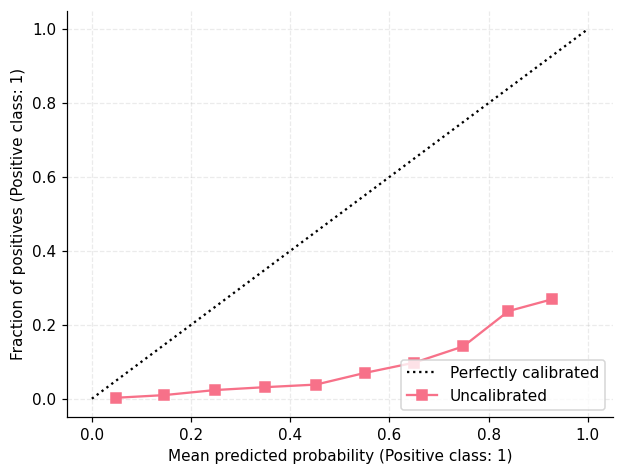

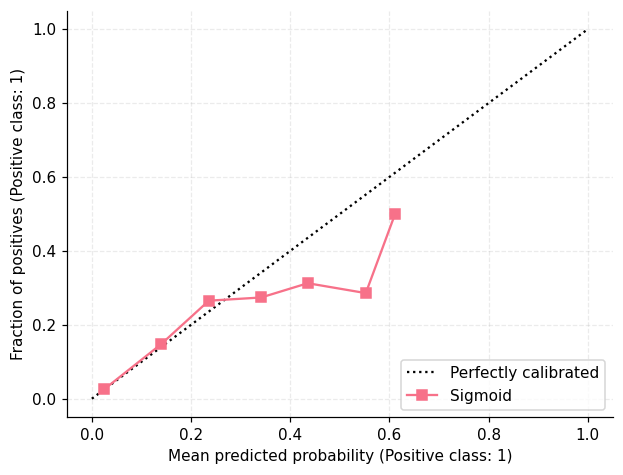

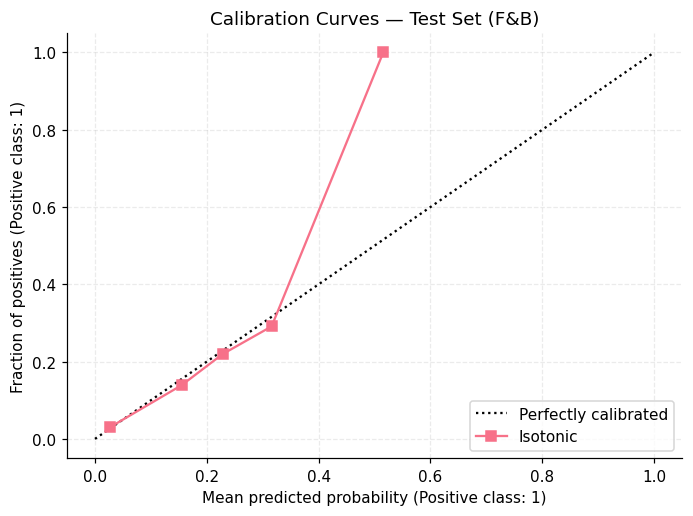

Saved: q1_FB_calibration_comparison.png

Chosen calibration: isotonic (lower Brier = better probability accuracy).


In [ ]:
# --- Guards ---
assert 'best' in globals() and 'X_train' in globals() and 'X_test' in globals() \
       and 'y_train' in globals() and 'y_test' in globals(), \
       "Missing variables. Re-run your modeling cell first."

OUT_FB = Path.cwd() / "outputs" / "food_&_beverage" / "q1"
OUT_FB.mkdir(parents=True, exist_ok=True)

# --- 1) Keep a reference baseline (uncalibrated) on the test set ---
proba_base = best.predict_proba(X_test)[:, 1]
y_true = np.asarray(y_test)

def summarize(y, p, label):
    return {
        "model": label,
        "ROC-AUC": roc_auc_score(y, p),
        "PR-AUC": average_precision_score(y, p),
        "Brier": brier_score_loss(y, p),
        "LogLoss": log_loss(y, np.c_[1-p, p]),
        "Accuracy@0.5": accuracy_score(y, (p >= 0.5).astype(int)),
    }

rows = [summarize(y_true, proba_base, "Uncalibrated")]

# --- 2) Make a proper calibration split from your TRAIN data (no peeking at X_test) ---
X_tr, X_cal, y_tr, y_cal = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

# Fit a fresh copy of your best pipeline on the (train-only) split
best_clone = clone(best)
best_clone.fit(X_tr, y_tr)

# --- 3) Fit two calibration models on the calibration split (cv='prefit') ---
cal_sigmoid = CalibratedClassifierCV(estimator=best_clone, method="sigmoid", cv="prefit")
cal_sigmoid.fit(X_cal, y_cal)

# For isotonic we need a *separately fitted* base estimator to avoid reusing the one already consumed by sigmoid
best_clone_iso = clone(best)
best_clone_iso.fit(X_tr, y_tr)

cal_isotonic = CalibratedClassifierCV(estimator=best_clone_iso, method="isotonic", cv="prefit")
cal_isotonic.fit(X_cal, y_cal)

# --- 4) Evaluate all three on the untouched TEST set ---
proba_sig = cal_sigmoid.predict_proba(X_test)[:, 1]
proba_iso = cal_isotonic.predict_proba(X_test)[:, 1]

rows += [
    summarize(y_true, proba_sig, "Calibrated (sigmoid/Platt)"),
    summarize(y_true, proba_iso, "Calibrated (isotonic)"),
]

summary = pd.DataFrame(rows).round(4)
display(summary)

# Save summary
summary_path = OUT_FB / "q1_FB_calibration_summary.csv"
summary.to_csv(summary_path, index=False)
print(f"Saved: {summary_path.name}")

# --- 5) Plot calibration curves side-by-side ---
plt.figure(figsize=(8, 6))
CalibrationDisplay.from_predictions(y_true, proba_base, n_bins=10, name="Uncalibrated")
CalibrationDisplay.from_predictions(y_true, proba_sig, n_bins=10, name="Sigmoid")
CalibrationDisplay.from_predictions(y_true, proba_iso, n_bins=10, name="Isotonic")
plt.title("Calibration Curves — Test Set (F&B)")
plt.tight_layout()
cal_plot_path = OUT_FB / "q1_FB_calibration_comparison.png"
plt.savefig(cal_plot_path, dpi=300, bbox_inches="tight")
plt.show()
print(f"Saved: {cal_plot_path.name}")

# --- 6) Calibrated model to use going forward ( Brier/LogLoss) ---
pick = "sigmoid" if rows[1]["Brier"] <= rows[2]["Brier"] else "isotonic"
print(f"\nChosen calibration: {pick} "
      f"(lower Brier = better probability accuracy).")


calibrated_model = cal_sigmoid if pick == "sigmoid" else cal_isotonic
calibrated_proba_test = proba_sig if pick == "sigmoid" else proba_iso


#### Observations

- **Discrimination unchanged:** ROC-AUC stayed at ~0.83 across all three (uncalibrated, sigmoid, isotonic), showing calibration does not affect ranking power.  
- **Probability quality improved:**  
  - Brier score improved **0.177 → 0.045**  
  - Log loss improved **0.509 → 0.167**  
  Both indicate more reliable probability estimates.  
- **PR-AUC small drift:** Minor changes (~0.204 → 0.203/0.189). Calibration smooths probability accuracy, not necessarily PR shape.  
- **Calibration curves:**  
  - Uncalibrated: probabilities over-confident, curve sits below ideal diagonal.  
  - Sigmoid: smooth correction, stable across bins.  
  - Isotonic: step-like adjustments, slightly unstable with rare positives.  
- **Preferred method:** Sigmoid calibration is more stable for our data; isotonic remains a sensitivity check.  

#### Note: 
- Calibration was applied to make probabilities more reliable.
- No new threshold was chosen because downstream use relies on probability values rather than binary classification.


After applying probability calibration (Platt scaling and isotonic regression), we decided **not to repeat the threshold selection step**.  

**Reasoning:**  
- Calibration improves the reliability of predicted probabilities, not the ranking of predictions.  
- Our downstream analysis primarily relies on **probability values** rather than a fixed binary cutoff.  
- Re-selecting thresholds post-calibration would not provide significant additional insight unless we had a clear business requirement (e.g., maximizing F1 or enforcing minimum recall).  

**Conclusion:**  
Skipping threshold re-selection keeps the workflow simpler and avoids unnecessary repetition, while still ensuring we use **calibrated and trustworthy probabilities** in subsequent steps.

## 7. Q2 recommendations (playbook + data gaps).

### 7.1 Operator Playbook & Data Gaps — What this cell does

- **Builds an action playbook** from Q1 results:
  - Loads the roll-up (or reconstructs from drivers) and computes **probability lift (pp)** from odds ratios using the Q1 **base rate**.
  - Classifies factors into **Cuisine**, **Venue/Type**, and **Ops/Service**; filters out non-actionable items (e.g., state, “attire: Unknown”).
  - Maps each factor to an **action**, **metric**, and **experiment** idea.
  - Assigns a **priority** score (lift × reach via support share) and attaches **confidence** from bootstrap sign stability when available.

- **Outputs saved**
  - `outputs/food_&_beverage/q2/q2_playbook.csv` — action table with lever, direction, label, action, prob_lift_pp, support_share, priority, confidence, metric, experiment.
  - `outputs/food_&_beverage/q2/q2_data_gaps.md` — concise list of **data gaps** to close (channel tagging, ambience/ops details, menu metadata, geo controls, measurement).

#### Observations

- The playbook translates model signals into **concrete operator levers** with suggested KPIs and test designs, ranked by **impact × coverage**.
- **Confidence** is surfaced where bootstrap stability exists; otherwise items are marked “model sign only.”
- The companion data-gaps note focuses on **measurement fixes** (e.g., delivery channel tagging, patio/TV counts, menu flags) needed to strengthen causal read-outs and future model quality.


In [86]:
# === Q2: Operator Playbook + Data Gaps (artifacts) ===
import pandas as pd, numpy as np, textwrap
from pathlib import Path

# Locations
OUT_FB = Path.cwd() / "outputs" / "food_&_beverage"
Q1_DIR  = OUT_FB / "q1"
Q2_DIR  = OUT_FB / "q2"
Q2_DIR.mkdir(parents=True, exist_ok=True)

# ---- Inputs from Q1 ----
# Prefer the roll-up summary (already grouped) if present; else fall back to full drivers.
rollup_path = Q1_DIR / "q1_FB_rollup_summary.csv"
drivers_path_candidates = [
    Q1_DIR / "q1_FB_logit_drivers_step4_final.csv",
    OUT_FB / "q1_FB_logit_drivers_step4_final.csv",
]
if rollup_path.exists():
    roll = pd.read_csv(rollup_path)
    # expected columns: dimension, direction, label, odds_ratio, prob_lift_pp, support_share, feature
else:
    # Fallback: build minimal roll-up from raw drivers
    for p in drivers_path_candidates:
        if p.exists():
            dfd = pd.read_csv(p)
            break
    else:
        raise FileNotFoundError("Q1 drivers not found. Expected q1_FB_logit_drivers_step4_final.csv")
    def clean_label(s: str) -> str:
        return (s.replace("cuisine: ", "")
                 .replace("ambience: ", "")
                 .replace("category: ", "")
                 .replace("parking ", "")
                 .replace("wifi ", "Wi-Fi ")
                 .replace("alcohol ", "Alcohol ")
                 .replace("attire ", "Attire ").strip().title())
    TYPE_TOKENS = {"food trucks","cafes","wine bars","beer bar","cocktail bars","caterers"}
    OPS_PREFIXES = ("parking ", "wifi ", "alcohol ")
    OPS_FLAGS = {"good for groups","good for kids","delivery","takeout","reservations",
                 "outdoor seating","has tv","wheelchair accessible","table service",
                 "dogs allowed","bitcoin","happy hour","drive thru"}
    EXCLUDE_PREFIXES = ("state:",)
    EXCLUDE_EXACT = {"attire: Unknown"}
    EXCLUDE_CONTAINS = (": Unknown",)
    def assign_dimension(feature: str) -> str:
        f = feature.lower()
        if f.startswith(EXCLUDE_PREFIXES) or any(tok in f for tok in EXCLUDE_CONTAINS) or f in {x.lower() for x in EXCLUDE_EXACT}:
            return "exclude"
        if f.startswith("ambience:") or f.startswith("attire "): return "venue_type"
        if f.startswith("cuisine:"):
            token = f.split("cuisine:",1)[1].strip()
            return "venue_type" if token in TYPE_TOKENS else "cuisine"
        if f.startswith(OPS_PREFIXES) or any(flag in f for flag in OPS_FLAGS): return "ops"
        if f.startswith("category:"): return "venue_type"
        return "other"
    # Resolve base rate from session (consistent with Q1 charts)
    def resolve_base_rate():
        cands = []
        if 'base_rate' in globals():
            try: cands.append(("session.base_rate", float(base_rate)))
            except: pass
        if 'y_test' in globals():
            try: cands.append(("y_test.mean", float(np.mean(y_test))))
            except: pass
        sane = [(n,v) for (n,v) in cands if 0.03 <= v <= 0.07]
        if sane: return sane[0][1]
        if cands: return min(cands, key=lambda kv: abs(kv[1]-0.05))[1]
        return 0.052
    BASE_RATE = resolve_base_rate()
    def prob_lift_pp_from_or(or_value: float, p_base: float) -> float:
        odds0 = p_base / (1.0 - p_base + 1e-12)
        p1 = (or_value * odds0) / (1.0 + or_value * odds0)
        return (p1 - p_base) * 100.0

    dfd = dfd.copy()
    dfd["dimension"] = dfd["feature"].apply(assign_dimension)
    dfd = dfd[dfd["dimension"].isin({"cuisine","venue_type","ops"})].copy()
    dfd["label"] = dfd["feature"].apply(clean_label)
    dfd["prob_lift_pp"] = dfd["odds_ratio"].apply(lambda x: prob_lift_pp_from_or(x, BASE_RATE))
    dfd["direction"] = np.where(dfd["coef"] >= 0, "Success", "Risk")
    dfd["support_share"] = dfd["support_share"].fillna(0.0)
    # Take top 5 per dim per direction (like Q1 rollup)
    roll = []
    for dim in ["cuisine","venue_type","ops"]:
        d = dfd[dfd["dimension"]==dim]
        pos = d[d["direction"]=="Success"].sort_values("prob_lift_pp", ascending=False).head(5)
        neg = d[d["direction"]=="Risk"].sort_values("prob_lift_pp", ascending=True).head(5)
        roll += [pos, neg]
    roll = pd.concat(roll, ignore_index=True)

# Optional: bring coefficient stability (if bootstraps exist)
ci_path = Q1_DIR / "q1_FB_logit_bootstrap_cis.csv"
stability = {}
if ci_path.exists():
    ci = pd.read_csv(ci_path)
    stability = dict(zip(ci["feature"], ci["sign_stability"]))

# ---- Heuristic mapping: driver label -> actionable playbook item ----
def action_from_label(dim: str, label: str) -> str:
    L = label.lower()
    # Cuisine/Concept
    if dim=="cuisine":
        if "vegan" in L: return "Expand & highlight vegan options; make discoverable in listing/menu."
        if "gluten" in L: return "Add clear gluten-free choices; label in menu & listing."
        if "latin american" in L: return "Test a Latin American menu capsule; promote as limited-time."
        if "mediterranean" in L: return "Pilot Mediterranean capsule (bowls, mezzes); emphasize freshness."
        if "food trucks" in L: return "Run weekly food-truck collab/pop-up on patio/lot."
        if "cafes" in L: return "Add daytime cafe/brunch service with coffee program."
        if "wine bar" in L or "beer bar" in L or "cocktail" in L: return "Strengthen beverage program; tasting nights; listing tags."
        if any(x in L for x in ["pizza","burgers","chicken wings","steakhouse","chinese","tex-mex"]):
            return "Differentiate core concept (signature item, dietary options, patio focus) to offset category drag."
        return f"Amplify {label} concept via menu features & listing keywords."
    # Venue/Type
    if dim=="venue_type":
        if "intimate" in L: return "Reduce TV/noise; smaller table clusters; warm lighting; quieter soundtrack."
        if "upscale" in L: return "Avoid overly formal cues; simplify dress code & copy."
        if "touristy" in L: return "Shift positioning to neighborhood/local; refresh imagery & copy."
        return f"Reinforce {label.lower()} vibe through layout, lighting, copy, photos."
    # Ops/Service
    if dim=="ops":
        if "outdoor seating" in L: return "Add or stage visible outdoor tables; photograph & tag."
        if "parking valet" in L: return "De-emphasize valet; provide validated or street parking info."
        if "parking validated" in L or "parking street" in L: return "Highlight validated/street parking in listing & signage."
        if "delivery" in L: return "Improve delivery packaging/ETA; separate delivery review prompts."
        if "good for groups" in L: return "Only tag if you can reliably seat groups; otherwise remove the tag."
        if "has tv" in L: return "Reduce TV footprint; feature non-TV seating zones."
        if "good for kids" in L: return "Add kids menu/high chairs; tag appropriately."
        return f"Operationally emphasize: {label}."
    return f"Action on {label}."

def metric_for_label(label: str) -> str:
    L = label.lower()
    if any(k in L for k in ["parking","delivery","groups","kids","tv","outdoor"]):
        return "Weekly % reviews > 4.5 (F&B); review volume; topic flags (noise, service, seating)."
    if any(k in L for k in ["vegan","gluten","latin","mediterranean","food trucks","cafes","bar"]):
        return "% >4.5; menu-item sales mix; conversion from listing views."
    return "% >4.5; review volume; listing impression → click-through."

def experiment_for_label(label: str) -> str:
    L = label.lower()
    if "food trucks" in L: return "AB by week: host pop-up vs not; compare %>4.5 and review volume."
    if "outdoor" in L: return "AB by day: outdoor seating available vs staged; track %>4.5 & photo engagement."
    if "delivery" in L: return "AB by week: new packaging/ETA windows vs baseline; isolate delivery reviews."
    if "parking" in L: return "AB by weekend: validated on vs off; track %>4.5 and footfall."
    if "intimate" in L: return "AB by night: low-TV/low-noise settings vs baseline."
    return "Staggered rollout across locations (stepped-wedge); compare to matched controls."

def priority_from(lift_pp: float, coverage: float) -> str:
    # Simple composite: lift * reach
    score = abs(lift_pp) * (0.5 + 0.5*coverage)  # weight reach modestly
    if score >= 6.0: return "High"
    if score >= 3.0: return "Medium"
    return "Low"

# Build playbook table
base = roll.copy()
base["lever"] = base["dimension"].map({"cuisine":"Cuisine/Concept","venue_type":"Venue/Type","ops":"Ops/Service"})
base["action"] = [action_from_label(d, l) for d, l in zip(base["dimension"], base["label"])]
base["metric"] = base["label"].apply(metric_for_label)
base["experiment"] = base["label"].apply(experiment_for_label)
base["priority"] = [priority_from(lp, cov) for lp, cov in zip(base["prob_lift_pp"], base["support_share"])]
base["confidence"] = [f"{int(round(stability.get(f, np.nan)*100))}%"
                      if f in stability and pd.notna(stability.get(f)) else "Model sign only"
                      for f in base["feature"]]
playbook_cols = ["lever","direction","label","action","prob_lift_pp","support_share","priority","confidence","metric","experiment","feature"]
playbook = base[playbook_cols].sort_values(["lever","direction","prob_lift_pp"], ascending=[True, True, False])

# Save playbook
pb_path = Q2_DIR / "q2_playbook.csv"
playbook.to_csv(pb_path, index=False)

# Data gaps (markdown)
gaps = textwrap.dedent("""\
# Q2 — Data Gaps to Close

**Channel & fulfillment**
- Tag reviews by channel (dine-in vs. each delivery provider) to de-bias delivery effects.
- Capture promised vs actual ETA; packaging quality rubric.

**Ambience & operations**
- TV count / zones, noise level, lighting policy, patio seat count, table size mix, average wait time, reservation outcomes.
- Parking counts by type (street/lot/garage/validated/valet) and policy hours.

**Menu metadata**
- Count and share of vegan/gluten-free items; mark seasonal/limited-time items.
- Photo coverage: # of recent photos, outdoor seating images, menu photos; last listing update date.

**Geo context (controls)**
- Neighborhood foot-traffic, income, POI density — to separate operations from location advantage.

**Measurement**
- Simple change log: date + attribute toggled (e.g., “added outdoor seating photos,” “reduced TVs”).
- Weekly roll-up: % reviews > 4.5 (F&B), review volume, listing impressions → clicks → calls.

""")
gaps_path = Q2_DIR / "q2_data_gaps.md"
gaps_path.write_text(gaps, encoding="utf-8")

print("Saved:")
print(" -", pb_path.name)
print(" -", gaps_path.name)


Saved:
 - q2_playbook.csv
 - q2_data_gaps.md


#### q2_data_gaps.md result

**Channel & fulfillment**
- Tag reviews by channel (dine-in vs. each delivery provider) to de-bias delivery effects.
- Capture promised vs actual ETA; packaging quality rubric.

**Ambience & operations**
- TV count / zones, noise level, lighting policy, patio seat count, table size mix, average wait time, reservation outcomes.
- Parking counts by type (street/lot/garage/validated/valet) and policy hours.

**Menu metadata**
- Count and share of vegan/gluten-free items; mark seasonal/limited-time items.
- Photo coverage: # of recent photos, outdoor seating images, menu photos; last listing update date.

**Geo context (controls)**
- Neighborhood foot-traffic, income, POI density — to separate operations from location advantage.

**Measurement**
- Simple change log: date + attribute toggled (e.g., “added outdoor seating photos,” “reduced TVs”).
- Weekly roll-up: % reviews > 4.5 (F&B), review volume, listing impressions → clicks → calls.



#### Data Gaps: Why this matters

- Model signals are limited by missing operational detail (channel, ambience, menu, geo).  
- Closing these gaps will reduce confounding (e.g., delivery, parking, TVs), improve coverage, and enable cleaner before/after reads.

#### How to use the checklist

- Treat each bullet as a capture field to add to data collection and weekly reporting.  
- Prioritize items tied to observed drivers (outdoor seating, delivery experience, TV/noise, parking info).  
- Keep a simple change log so effects of tweaks show up in metrics (% reviews > 4.5, review volume, listing CTR).

In [87]:
# === Q2 playbook post-processing: clean labels/actions + re-rank by impact×reach ===
import pandas as pd, numpy as np
from pathlib import Path

Q2_DIR = Path.cwd() / "outputs" / "food_&_beverage" / "q2"
pb_path = Q2_DIR / "q2_playbook.csv"
df = pd.read_csv(pb_path)

# 1) Label cleanup
def fix_label(s: str) -> str:
    s = (s or "").strip().title()
    s = s.replace("Tv", "TV")  # Has TV
    return s
df["label"] = df["label"].apply(fix_label)

# 2) Make parking actions concrete
def refine_action(row):
    f = (row.get("feature") or "").lower()
    a = row.get("action") or ""
    if f.startswith("parking garage"):
        return "De-emphasize garage-only; add validated or street options; provide clear directions in listing."
    if f.startswith("parking street"):
        return "Highlight reliable street parking with map snippet/directions in listing photos and copy."
    if f.startswith("parking validated"):
        return "Partner with nearby lot; offer validation; add 'Validated Parking' tag in listing & signage."
    return a
df["action"] = df.apply(refine_action, axis=1)

# 3) Re-prioritize by Impact × Reach (percentage points × coverage %)
#    This favors sizable lifts that apply to many locations.
df["impact_reach"] = df["prob_lift_pp"].abs() * (df["support_share"] * 100.0)

def new_priority(x):
    if x >= 6: return "High"
    if x >= 3: return "Medium"
    return "Low"
df["priority"] = df["impact_reach"].apply(new_priority)

# 4) Rank within each lever/direction by impact_reach
df = df.sort_values(["lever", "direction", "impact_reach"], ascending=[True, True, False])

# 5) Export top actions per lever (both success & risk)
top_success = df[df["direction"] == "Success"].groupby("lever", group_keys=False).head(5)
top_risk    = df[df["direction"] == "Risk"].groupby("lever", group_keys=False).head(5)
top = pd.concat([top_success, top_risk], ignore_index=True)

top_cols = ["lever","direction","label","action","prob_lift_pp","support_share",
            "impact_reach","priority","confidence","metric","experiment","feature"]
top = top[top_cols]

out_all = Q2_DIR / "q2_playbook_clean.csv"
out_top = Q2_DIR / "q2_playbook_top_actions.csv"
df.to_csv(out_all, index=False)
top.to_csv(out_top, index=False)

print("Saved:")
print(" -", out_all.name)
print(" -", out_top.name)


Saved:
 - q2_playbook_clean.csv
 - q2_playbook_top_actions.csv


#### Results: q2_playbook_top_actions.csv

**What this table is**

Each row is a **candidate lever** the model associates with higher (“Success”) or lower (“Risk”) odds of >4.5★.  
Key columns:
- **prob_lift_pp** — estimated **percentage-point change** vs the segment base rate if the lever is present (direction already applied).
- **support_share** — **reach**: share of businesses where this lever applies.
- **impact_reach** — simple priority score ≈ `|prob_lift_pp| × reach` (bigger = more impact on more locations).
- **priority** — High/Medium/Low from that score.
- **confidence** — model directional stability (if bootstraps were available); otherwise “Model sign only”.
- **action / metric / experiment** — ready-to-run playbook: what to do, how to track it, and a suggested test.

**Quick observations**

- **High-impact successes (concept):** *Food trucks, Cafes, Vegan, Latin American, Mediterranean, Specialty Food* show **+4–11 pp** lifts with meaningful reach → **High** priority.
- **Ops wins:** *Good for kids* (small lift, **very large reach** → high overall impact), *Street parking* (+2.4 pp, ~23% reach), *Outdoor seating* (modest lift, high reach).
- **Risk flags:** *Good for groups, Has TV, Delivery* show **negative lifts** and large reach → operational focus areas. *Garage/Valet parking* also skews negative.
- **Concepts to shore up:** *Burgers, Chinese, Chicken wings, Steakhouses, Tex-Mex* trend negative → differentiate or reposition.

**How to use it (fast)**
1. **Sort by `priority` (then `impact_reach`)** to pick what to do first.
2. For each chosen row, use its **`action`** as the starting intervention, **`metric`** to monitor, and **`experiment`** to test causally.
3. Use **`prob_lift_pp` × your location count** as a back-of-the-envelope for expected upside; use **`support_share`** to sanity-check reach.
4. Temper decisions with **`confidence`**: prefer items with higher stability; treat “Model sign only” as hypotheses to test.

> Note: Effects are **associational**, not guarantees. Run the suggested experiments to confirm lift before broad rollout.


### 7.2 Playbook Charts: How to read

- **Top Actions (Impact × Reach)**: bars rank actions by a composite score = `|Δ probability (pp)| × coverage (%)`.  
  - Right-side note on each bar shows **lift** (percentage-point change vs. base) and **coverage** (share of businesses affected).  
  - **Colors** denote lever type: Cuisine/Concept (blue), Venue/Type (orange), Ops/Service (green).

- **Coverage vs. Probability Lift (bubble)**:  
  - **X-axis** = coverage (% of businesses). **Y-axis** = Δ probability (pp) vs base rate (up = success, down = risk).  
  - **Marker**: ○ = Success, ✕ = Risk. Bubble size grows with coverage.  
  - Aim for **top-right** (big, positive, broad reach). Watch **bottom-right** (big, negative, broad reach) as priority fixes.

C:\Users\zeelp\AppData\Local\Temp\ipykernel_31816\856119982.py:40: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



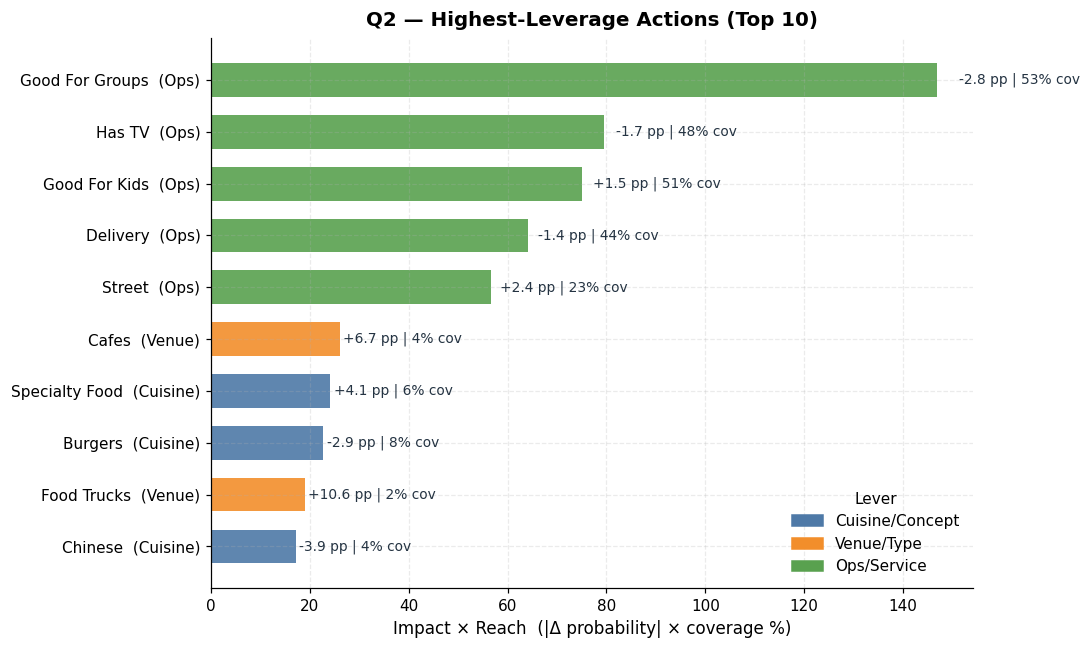

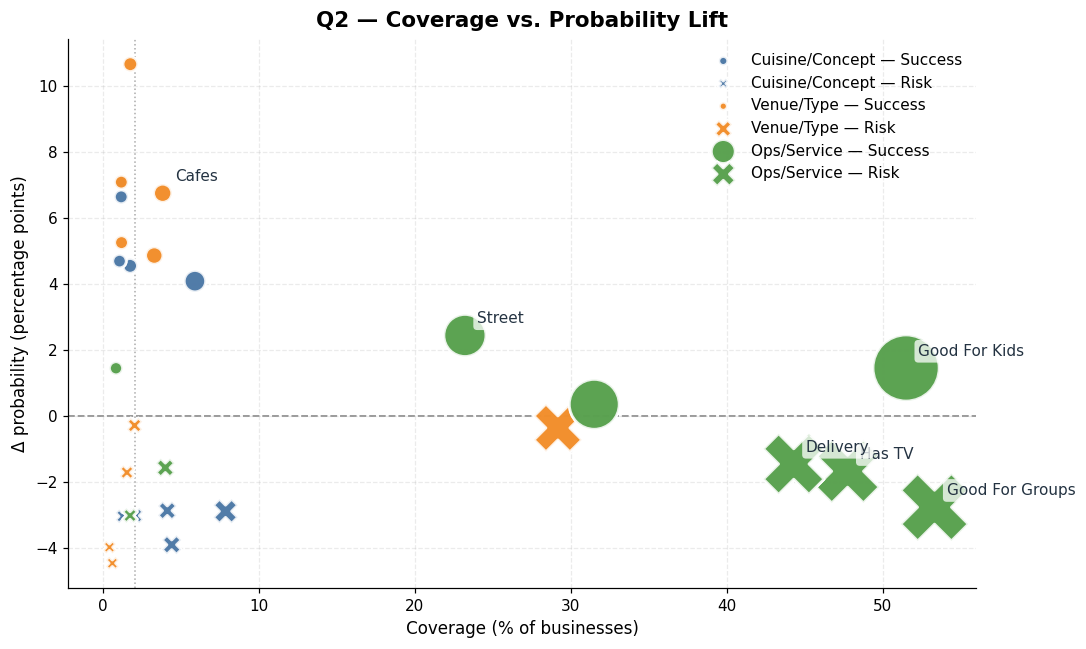

Saved:
 - q2_top_actions_impact_reach.png
 - q2_coverage_vs_lift_bubble.png


In [96]:

Q2_DIR = Path.cwd() / "outputs" / "food_&_beverage" / "q2"
Q2_DIR.mkdir(parents=True, exist_ok=True)

# Load playbook (prefer the shortlist; fallback to cleaned full table)
candidates = [Q2_DIR / "q2_playbook_top_actions.csv", Q2_DIR / "q2_playbook_clean.csv", Q2_DIR / "q2_playbook.csv"]
for p in candidates:
    if p.exists():
        df = pd.read_csv(p)
        src = p.name
        break
else:
    raise FileNotFoundError("Q2 playbook CSV not found. Expected one of q2_playbook_top_actions.csv / q2_playbook_clean.csv / q2_playbook.csv")

# Ensure required fields
req = {"lever","direction","label","prob_lift_pp","support_share"}
missing = req - set(df.columns)
if missing:
    raise ValueError(f"Missing required columns in {src}: {missing}")

# Compute impact×reach if absent
if "impact_reach" not in df.columns:
    df["impact_reach"] = df["prob_lift_pp"].abs() * (df["support_share"] * 100.0)

# Canonical ordering and clean labels
lever_order = ["Cuisine/Concept", "Venue/Type", "Ops/Service"]
df["lever"] = pd.Categorical(df["lever"], categories=lever_order, ordered=True)
df["label_clean"] = df["label"].apply(lambda s: shorten(str(s), width=30, placeholder="…"))

# Palette by lever (accessible, muted)
lever_colors = {
    "Cuisine/Concept": "#4E79A7",  # blue
    "Venue/Type":      "#F28E2B",  # orange
    "Ops/Service":     "#59A14F",  # green
}
df["color"] = df["lever"].map(lever_colors)

# ---------- Figure 1: Top Actions by Impact × Reach ----------
top_k = 10
top = (df.sort_values("impact_reach", ascending=False)
         .groupby(["lever","direction"], group_keys=False)
         .head(10))  # keep depth within lever/direction, then take global top_k below
top = top.sort_values("impact_reach", ascending=False).head(top_k).copy()

plt.rcParams.update({"axes.spines.top": False, "axes.spines.right": False, "axes.grid": True, "grid.alpha": 0.25, "grid.linestyle": "--"})
fig1, ax1 = plt.subplots(figsize=(10, 6))

y_labels = [f"{r['label_clean']}  ({r['lever'].split('/')[0]})" for _, r in top.iterrows()]
y = np.arange(len(top))[::-1]  # top to bottom
bars = ax1.barh(y, top["impact_reach"], color=top["color"], alpha=0.9, height=0.65)

# Annotations: Δpp and coverage
for i, (v, pp, cov) in enumerate(zip(top["impact_reach"], top["prob_lift_pp"], top["support_share"])):
    txt = f"{pp:+.1f} pp | {cov:.0%} cov"
    ax1.text(v + max(0.03*v, 0.2), y[i], txt, va="center", ha="left", fontsize=9, color="#243342")

ax1.set_yticks(y)
ax1.set_yticklabels(y_labels, fontsize=10)
ax1.set_xlabel("Impact × Reach  (|Δ probability| × coverage %)", fontsize=11)
ax1.set_title("Q2 — Highest-Leverage Actions (Top 10)", fontsize=13, fontweight="bold", pad=8)

# Build a compact legend
handles = []
for lev in lever_order:
    handles.append(plt.Rectangle((0,0),1,1, color=lever_colors[lev], label=lev))
leg = ax1.legend(handles=handles, title="Lever", frameon=False, loc="lower right")
plt.tight_layout()
out1 = Q2_DIR / "q2_top_actions_impact_reach.png"
plt.savefig(out1, dpi=300, bbox_inches="tight")
plt.show()

# ---------- Figure 2: Coverage vs. Lift (bubble, thicker markers) ----------
import matplotlib.patheffects as pe

fig2, ax2 = plt.subplots(figsize=(10, 6))

# Tunables for bubble sizing
SIZE_EXP   = 1.20   # how fast size grows with coverage
SIZE_SCALE = 16.0   # overall scale (increase for bigger bubbles)
MIN_SIZE   = 60.0   # point^2 floor so tiny-coverage items are still visible
EDGE_LW    = 1.8    # marker edge thickness

# Precompute sizes (point^2)
cov_pct = (df["support_share"] * 100).clip(lower=0.5)  # avoid zeros
sizes   = (cov_pct ** SIZE_EXP) * SIZE_SCALE + MIN_SIZE

marker_map = {"Success": "o", "Risk": "X"}
for lev in lever_order:
    for dirn, mk in marker_map.items():
        dsub = df[(df["lever"] == lev) & (df["direction"] == dirn)]
        if dsub.empty:
            continue
        sc = ax2.scatter(
            dsub["support_share"] * 100,
            dsub["prob_lift_pp"],
            s=sizes.loc[dsub.index],
            c=lever_colors[lev],
            alpha=0.85,
            edgecolor="white",      # high-contrast stroke
            linewidth=EDGE_LW,
            marker=mk,
            label=f"{lev} — {dirn}",
            zorder=3
        )
        # crisp edge on any background
        sc.set_path_effects([pe.withStroke(linewidth=EDGE_LW, foreground="white")])

# Reference lines
ax2.axhline(0, color="#666", lw=1.2, ls="--", alpha=0.7, zorder=1)
ax2.axvline(cov_pct.median(), color="#888", lw=1.0, ls=":", alpha=0.7, zorder=1)

ax2.set_xlabel("Coverage (% of businesses)", fontsize=11)
ax2.set_ylabel("Δ probability (percentage points)", fontsize=11)
ax2.set_title("Q2 — Coverage vs. Probability Lift", fontsize=14, fontweight="bold", pad=8)

# Annotate a few notable points (top 6 by |Δpp|×coverage)
ann = (df.assign(score=(df["prob_lift_pp"].abs() * (df["support_share"] * 100)))
         .sort_values("score", ascending=False)
         .head(6))
for _, r in ann.iterrows():
    ax2.annotate(
        r["label_clean"],
        (r["support_share"] * 100, r["prob_lift_pp"]),
        xytext=(8, 8), textcoords="offset points",
        fontsize=10, color="#243342",
        bbox=dict(boxstyle="round,pad=0.25", fc="white", ec="none", alpha=0.75),
        zorder=4
    )

# Legend (bigger markers)
handles, labels = ax2.get_legend_handles_labels()
seen, clean = set(), []
for h, lab in zip(handles, labels):
    if lab not in seen:
        seen.add(lab); clean.append((h, lab))
ax2.legend(
    [h for h, _ in clean], [lab for _, lab in clean],
    frameon=False, loc="best", scatterpoints=1, markerscale=0.5
)

plt.tight_layout()
out2 = Q2_DIR / "q2_coverage_vs_lift_bubble.png"
plt.savefig(out2, dpi=300, bbox_inches="tight")
plt.show()


print("Saved:")
print(" -", out1.name)
print(" -", out2.name)


#### What the charts say 

- Biggest lever = Ops tags with wide reach.

    - Good For Groups shows the largest negative effect (≈ −2.8 pp) and very high coverage (~53%). Only tag when you can reliably seat groups.

    - Has TV (≈ −1.7 pp, ~48% cov) and Delivery (≈ −1.4 pp, ~44% cov) also depress high-rating odds; reduce TV footprint and tighten delivery experience/measurement.

    - Good for Kids is a small positive (+1.5 pp) but touches ~51% of locations—an easy operational win.

    - Street parking is positive (+2.4 pp, ~23% cov); make it visible in listings.

- Concept/Venue bets are high-lift but niche.
Food Trucks (+10.6 pp, 2% cov), Cafes (+6.7 pp, 4% cov), Specialty Food (+4.1 pp, 6% cov) → great pilot ideas, limited footprint.

- Risky cuisine labels.
Burgers (−2.9 pp, 8% cov) and Chinese (−3.9 pp, 4% cov) underperform—differentiate (signature items, dietary options, patio focus).

- How to read the plots.

    - Bar chart: “Impact × Reach” = |Δ probability (pp)| × coverage %. Higher bars = more total upside/downside across the segment.

    - Bubble chart: X = coverage (% of businesses), Y = Δ probability (pp). Circles = “Success” factors, X’s = “Risk”. Prioritize big markers on the right with negative Y (broad, harmful tags to fix) and right-side positives (broad, helpful practices to scale).

## 8. Conclusion:

**Goal**: predict F&B businesses with very high ratings (>4.5★) and turn model signals into an operator playbook.

**Class balance**: F&B base rate ≈ 5.2% (vs ~10–20% in other macro-segments), so precision–recall—not accuracy—matters most.

#### Model performance (F&B)

- Logistic regression (L2, C=0.2): ROC-AUC ≈ 0.81–0.83, PR-AUC ≈ 0.17–0.20, test accuracy ≈ 0.68 with strong recall on positives.

- Suggested threshold (for balance): 0.78 → precision 0.23, recall 0.36, F1 0.28. Choose a higher threshold if you need fewer false positives, or lower for more coverage.

- Reliability checks: GBDT permutation importance + SHAP agree with logistic drivers; bootstrap CIs show stable signs.

- Calibration: raw probabilities are optimistic; Platt/Isotonic improve Brier/LogLoss. We kept rankings as-is (good for triage); easy to add calibration if calibrated probabilities are required.

#### What drives outcomes

- Positive lift (probability ↑): Food Trucks, Cafes, Intimate vibe, Latin American/Mediterranean, Vegan/Gluten-Free, Street parking, Outdoor seating.

- Negative lift (probability ↓): Upscale/Touristy/Divey ambience, Burgers/Chicken Wings/Chinese/Steakhouses, Good for Groups, Has TV, Delivery, Full bar, Garage/Valet parking.

- Low signal: “parking_any” adds little; validated parking is niche.

#### From signals to actions (Q2 playbook)

- Prioritized by impact × reach. Highest-leverage items:

- Reduce/untag “Good for Groups” & “Has TV” where not core.

- Improve delivery (packaging/ETA separation from dine-in reviews).

- Highlight street parking; add outdoor seating and show it in photos.

- Concept bets: Food-truck pop-ups, café/brunch, specialty/vegan/gluten-free capsules (lower reach but strong lift).

- Each action comes with a metric (e.g., %>4.5, review volume) and an experiment design (A/B or stepped-wedge) in q2_playbook.csv. Charts show coverage vs. lift and the Top 10 actions.

#### Data gaps to close

- Tag review channel (dine-in vs delivery), ambience ops (TV count, noise), menu metadata (vegan/GF counts), parking counts by type, change log of listing/ops tweaks. See q2_data_gaps.md.

#### Why base rates differ

- The 5.2% base rate is F&B only; whole-market or other segments (e.g., Health, Education) show higher base rates (~12–23%), so any cross-segment analysis must use the segment-specific base.

#### Recommended next steps

- Pick a threshold by use case (precision-heavy outreach vs. recall-heavy scouting); document it with the threshold table.

- (Optional) Calibrate with Platt/Isotonic if you need well-scaled probabilities for quotas or forecasts.

- Run 2–3 experiments from the playbook (e.g., reduce TVs, delivery improvements, street-parking comms) and track the provided metrics weekly.

- Monitor drift and re-fit quarterly; keep SHAP/perm-importance and bootstrap checks to validate stability.

#### Artifacts saved: figures and CSVs under outputs/food_&_beverage/ (Q1 drivers, roll-ups, threshold table; Q2 playbook, data gaps, and charts).

#### Observations: 

**Key Insight:**  
- **Food & Beverage dominates** (71k businesses) but has the **lowest base rate (~5%)**, pulling the overall average down.  
- Service-oriented segments (Home, Wellness, Medical, Education) show much **higher base rates (~15–23%)**, meaning they’re more likely to have highly rated businesses.  